In [3]:
import torch
import numpy as np
import os
import cma
from eval import play
from gan.config import SmallModelConfig
from gan.models.small_models import Generator
from play_rl.zelda_astar import play_astar
from gan.utils import tensor_to_level_str,check_playable
from gan.level_visualizer import GVGAILevelVisualizer
from gan.env import Env
from play_rl.wrappers import GridGame
from play_rl.policy import Policy
from PIL import Image

In [4]:
config = SmallModelConfig()
config.set_env()
config.cuda = False
if config.cuda:
    device = torch.device(
        "cuda" if torch.cuda.is_available else "cpu")
    print("device : cuda")
else:
    device = torch.device("cpu")
    print("device : cpu")
generator = Generator(
    out_ch=config.input_shape[0],
    shapes=config.model_shapes,
    z_shape=(config.latent_size,),
    filters=config.generator_filters,
    use_linear4z2features_g=config.use_linear4z2features_g,
    use_self_attention=config.use_self_attention_g,
    use_conditional=config.use_conditional,
    use_deconv_g=config.use_deconv_g
).to(device)

env_def = Env(config.env_name,config.env_version)
level_visualizer = GVGAILevelVisualizer(env=env_def)

# model_path = os.path.join(
#     "/root/mnt/GVGAI-GAN/gan/checkpoints/_ours-152", "models_3800.tar")
# model_path = os.path.join(
#     "/root/mnt/GVGAI-GAN/gan/checkpoints/_boot_baseline-161", "models_3500.tar")
# model_path = os.path.join(
#     '/root/mnt/GVGAI-GAN/gan/checkpoints/_only5-121','models_1240.tar'
# )

# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_only5/models_10000.tar"
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_baseline-boot-371/latest.tar"
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_ours1-366/models_3000.tar"
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_ours2-369/models_1660.tar"

# only5
# 

# baseline
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-700/latest.tar"

# # ours1
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-706/latest.tar"

# # ours2
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-714/latest.tar"
# model_dict = torch.load(model_path)


load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
x = torch.randn(config.latent_size).to(device)


device : cpu


(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=490575, Wed Nov  2 07:12:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.400000000000000e+01 1.0e+00 4.80e-01  5e-01  5e-01 0:00.1


/root/.pyenv/versions/3.8.0/lib/python3.8/site-packages/cma/interfaces.py:188: UserWarning: ignoring unkown argument {'max_iterations': 150} in OOOptimizer.optimize
  warnings.warn(


    2     28 -1.000000000000000e+02 1.1e+00 4.78e-01  5e-01  5e-01 0:00.2
    3     42 -9.200000000000000e+01 1.1e+00 4.71e-01  5e-01  5e-01 0:00.3
   39    546 -1.380000000000000e+02 1.8e+00 6.89e-01  7e-01  7e-01 0:03.4
   88   1232 -1.490000000000000e+02 2.0e+00 4.52e-01  4e-01  5e-01 0:07.4
  100   1400 -1.510000000000000e+02 2.1e+00 5.97e-01  6e-01  7e-01 0:08.3
  177   2478 -1.600000000000000e+02 3.3e+00 3.57e-01  3e-01  4e-01 0:14.3
  184   2576 -1.600000000000000e+02 3.3e+00 2.91e-01  3e-01  3e-01 0:14.8
INIT:  [ 0.8044762   1.9000423   0.1435097  -0.04054641  0.47958356 -0.56575984
  1.15649009 -1.66548133  0.04754723 -0.75799865 -0.16095413 -0.86007214
 -1.02603996  2.22960544  1.22850084  0.58424091 -0.24880096  0.35225156
  0.01170472 -0.83084875 -0.8830862   1.12115204 -1.30528796 -0.03915489
  1.03968227 -0.4271971   1.25888193  0.59365517 -0.97153276 -0.00471613
  0.90027684 -0.74392736]
BEST:  [  6.91045131  -5.65457144  -1.40272975   1.75535864  -3.6336611
   6.0856022

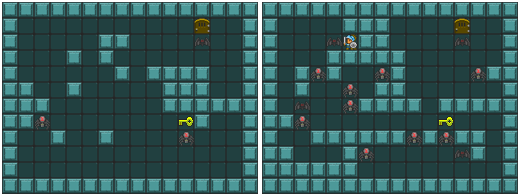

In [6]:
def f1(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return - wall - 5 * enemy


def f2(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return wall + 5 * enemy

# # env = GridGame(config.env_name, 200, env_def.state_shape)
# # actor = Policy(env.observation_space.shape, env.action_space,base_kwargs={"recurrent": True})
# # actor.load_state_dict(torch.load('/root/mnt/GVGAI-GAN/play_rl/checkpoints/ppo/zelda_20220825102126.pt'))

def fitnessf1(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1, 1, 1)
    level = generator(latent)
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0],config.env_fullname)
    if not playable:
        return 100
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)

    # return -(reward*100+step)
    ev = f1(level_str)
    return ev


def fitnessf2(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1, 1, 1)
    level = generator(latent)
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0], config.env_fullname)
    if not playable:
        return 100
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)

    # return -(reward*100+step)
    ev = f2(level_str)
    return ev

def show(x):
    p_level = torch.nn.Softmax2d()(generator(x))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img = np.array(level_visualizer.draw_level(level_strs[0]))
    image = Image.fromarray(p_level_img)
    image.show()


def show2(x,x2):
    p_level = torch.nn.Softmax2d()(generator(x))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img1 = np.array(level_visualizer.draw_level(level_strs[0]))
    p_level = torch.nn.Softmax2d()(generator(x2))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img2 = np.array(level_visualizer.draw_level(level_strs[0]))
    concated = np.concatenate([p_level_img1,p_level_img2],axis=1)
    image = Image.fromarray(concated)
    image.show()

    
x = torch.randn(config.latent_size).to(device)
es = cma.CMAEvolutionStrategy(x.tolist(), 0.5)
# es.optimize(fitness,iterations=30,min_iterations=30)
es.optimize(fitnessf1,min_iterations=150,max_iterations=150)
best = np.array(es.best.get()[0])
print("INIT: ", np.array(x.tolist()))
print("BEST: ", best)
print("Fitness: ", fitnessf1(best))
# show(x)
# show(torch.FloatTensor(best))
show2(x,torch.FloatTensor(best))

# # sum = 0
# # N = 10
# # for i in range(N):
# #     x = torch.randn(config.latent_size).to(device)
# #     es = cma.CMAEvolutionStrategy(x.tolist(), 0.5)
# #     es.optimize(fitness)
# #     best = np.array(es.best.get()[0])
# #     sum += fitness(best)

# # print("mean:",best/N)


In [4]:
def check(generator,fitness):
    scores = []

    wall_and_enemy_scores = []
    wall_and_enemy_changes = []

    playables = []
    playable_levels = []
    def check_level_hamming(level1: str, level2: str):
        hit = 0
        for c1, c2 in zip(level1, level2):
            if c1 == "\n":
                continue
            if c1 != c2:
                hit += 1
        return hit

    def count_wall_and_enemy(level_str: str):
        hit = 0
        for j, c in enumerate(level_str):
            if c == 'w':
                hit += 1
            if c in ['1', '2', '3']:
                hit += 5
        return hit

    for i in range(50):
        x = torch.randn(config.latent_size).to(device)
        es = cma.CMAEvolutionStrategy(x.tolist(),0.5)
        es.optimize(fitness,iterations=150,min_iterations=150)
        
        # es.optimize(fitness)
        best = np.array(es.best.get()[0])
        level_first = generator(x)
        level_str_first = tensor_to_level_str('zelda',level_first)
        wall_and_enemy_first = count_wall_and_enemy(level_str_first[0])

        level_target = generator(torch.FloatTensor(best))
        level_str_target = tensor_to_level_str('zelda', level_target)
        wall_and_enemy_target = count_wall_and_enemy(level_str_target[0])

        playable = check_playable(level_str_target[0], config.env_fullname)
        playables.append(1 if playable else 0)
        if playable:
            scores.append(fitness(best))
            wall_and_enemy_scores.append(wall_and_enemy_target)
            wall_and_enemy_changes.append(wall_and_enemy_target-wall_and_enemy_first)
            playable_levels.append(level_str_target[0])
        show(torch.FloatTensor(best))

    hamming_dist_sum = 0
    n = 0
    for i in range(len(playable_levels)):
        for j in range(len(playable_levels)):
            if i==j: 
                continue
            hamming_dist_sum += check_level_hamming(playable_levels[i], playable_levels[j])
            n+=1

    print(f"mean score:{np.array(scores).mean()}")
    print(f"mean counts:{np.array(wall_and_enemy_scores).mean()}")
    print(f"mean changes:{np.array(wall_and_enemy_changes).mean()}")
    print(f"mean playability:{np.array(playables).mean()}")
    print(f"mean hamming dist:{hamming_dist_sum/n}")
    

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=281127, Sun Oct 30 12:33:47 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.300000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 -9.400000000000000e+01 1.1e+00 4.71e-01  5e-01  5e-01 0:00.3
    3     42 -9.200000000000000e+01 1.1e+00 4.71e-01  5e-01  5e-01 0:00.4
   37    518 -1.140000000000000e+02 2.0e+00 7.30e-01  7e-01  8e-01 0:03.4
   61    854 -1.150000000000000e+02 2.2e+00 6.11e-01  6e-01  7e-01 0:05.6
   62    868 -1.150000000000000e+02 2.2e+00 6.01e-01  6e-01  7e-01 0:05.7
  100   1400 -1.150000000000000e+02 2.4e+00 5.92e-01  5e-01  7e-01 0:09.0
  125   1750 -1.150000000000000e+02 2.6e+00 6.69e-01  6e-01  8e-01 0:11.1
  126   1764 -1.150000000000000e+02 2.6e+00 6.73e-01  6e-01  8e-01 0:11.1
  127   1778 -1.150000000000000e+02 2.6e+00 6.75e-01  6e-01  8e-01 0:11.2
  132   1848 -1.150000000000000e+02 2.7e+00 6.25e-01  5e-01  8e-01 0:11.7
  133   1862 -1.150000

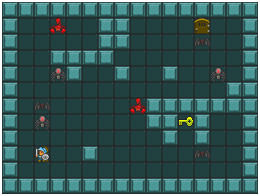

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=253369, Sun Oct 30 12:34:01 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.400000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -9.500000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 -1.000000000000000e+02 1.1e+00 4.63e-01  5e-01  5e-01 0:00.3
   34    476 -1.190000000000000e+02 1.6e+00 5.21e-01  5e-01  6e-01 0:03.4
   82   1148 -1.260000000000000e+02 2.1e+00 4.17e-01  4e-01  5e-01 0:07.5
  100   1400 -1.260000000000000e+02 2.2e+00 4.23e-01  4e-01  5e-01 0:09.1
  146   2044 -1.260000000000000e+02 2.4e+00 3.12e-01  3e-01  4e-01 0:13.4


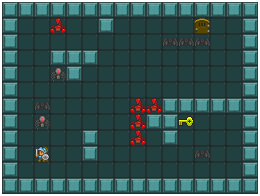

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=199303, Sun Oct 30 12:34:15 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.600000000000000e+01 1.0e+00 4.77e-01  5e-01  5e-01 0:00.1
    2     28 -1.010000000000000e+02 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 -1.050000000000000e+02 1.1e+00 4.51e-01  4e-01  5e-01 0:00.3
   37    518 -1.240000000000000e+02 1.7e+00 4.47e-01  4e-01  5e-01 0:03.3
   85   1190 -1.250000000000000e+02 2.3e+00 3.42e-01  3e-01  4e-01 0:07.3
   86   1204 -1.250000000000000e+02 2.3e+00 3.44e-01  3e-01  4e-01 0:07.4
   87   1218 -1.250000000000000e+02 2.3e+00 3.49e-01  3e-01  4e-01 0:07.5
   88   1232 -1.250000000000000e+02 2.3e+00 3.58e-01  3e-01  4e-01 0:07.6
  100   1400 -1.250000000000000e+02 2.4e+00 3.17e-01  3e-01  4e-01 0:08.7
  106   1484 -1.250000000000000e+02 2.4e+00 3.22e-01  3e-01  4e-01 0:09.3
  110   1540 -1.250000000000000e+02 2.5e+00 3.24e-01  3e-01  4e-01 0:09.6
  116   1624 -1.250000

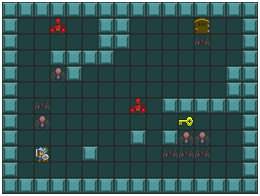

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=176216, Sun Oct 30 12:34:29 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.200000000000000e+01 1.0e+00 4.79e-01  5e-01  5e-01 0:00.1
    2     28 -9.600000000000000e+01 1.1e+00 4.67e-01  5e-01  5e-01 0:00.2
    3     42 -9.400000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.3
   35    490 -1.050000000000000e+02 1.8e+00 8.00e-01  7e-01  9e-01 0:03.4
   75   1050 -1.070000000000000e+02 2.1e+00 6.40e-01  6e-01  7e-01 0:07.1
   76   1064 -1.070000000000000e+02 2.1e+00 6.44e-01  6e-01  7e-01 0:07.2
   79   1106 -1.070000000000000e+02 2.2e+00 6.38e-01  6e-01  7e-01 0:07.4
   80   1120 -1.070000000000000e+02 2.2e+00 6.32e-01  6e-01  7e-01 0:07.5
   81   1134 -1.070000000000000e+02 2.2e+00 6.25e-01  5e-01  7e-01 0:07.6
   82   1148 -1.070000000000000e+02 2.2e+00 6.15e-01  5e-01  7e-01 0:07.7
   83   1162 -1.070000000000000e+02 2.2e+00 6.05e-01  5e-01  7e-01 0:07.8
   84   1176 -1.070000

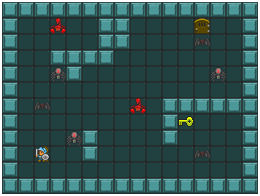

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=253026, Sun Oct 30 12:34:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.200000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 -9.300000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.2
    3     42 -9.200000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.3
   38    532 -9.900000000000000e+01 1.8e+00 5.20e-01  5e-01  5e-01 0:03.4
   86   1204 -1.040000000000000e+02 2.1e+00 4.59e-01  4e-01  5e-01 0:07.4
  100   1400 -1.040000000000000e+02 2.2e+00 3.82e-01  3e-01  4e-01 0:08.7
  104   1456 -1.040000000000000e+02 2.2e+00 3.50e-01  3e-01  4e-01 0:09.0
  105   1470 -1.040000000000000e+02 2.2e+00 3.46e-01  3e-01  4e-01 0:09.1
  108   1512 -1.040000000000000e+02 2.3e+00 3.33e-01  3e-01  4e-01 0:09.3
  109   1526 -1.040000000000000e+02 2.3e+00 3.31e-01  3e-01  4e-01 0:09.4
  110   1540 -1.040000000000000e+02 2.3e+00 3.25e-01  3e-01  4e-01 0:09.5
  111   1554 -1.040000

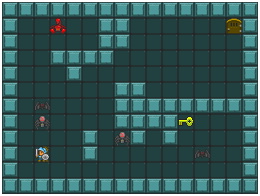

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=247360, Sun Oct 30 12:34:56 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.500000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 -9.100000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.2
    3     42 -9.600000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
   36    504 -1.120000000000000e+02 1.8e+00 4.98e-01  5e-01  5e-01 0:03.4
   83   1162 -1.170000000000000e+02 2.2e+00 3.90e-01  4e-01  4e-01 0:07.4
  100   1400 -1.170000000000000e+02 2.3e+00 3.93e-01  4e-01  4e-01 0:09.2
  110   1540 -1.170000000000000e+02 2.4e+00 3.39e-01  3e-01  4e-01 0:10.0
  111   1554 -1.170000000000000e+02 2.4e+00 3.41e-01  3e-01  4e-01 0:10.1
  112   1568 -1.170000000000000e+02 2.4e+00 3.42e-01  3e-01  4e-01 0:10.1
  119   1666 -1.170000000000000e+02 2.4e+00 3.02e-01  3e-01  3e-01 0:10.7
  120   1680 -1.170000000000000e+02 2.4e+00 2.92e-01  3e-01  3e-01 0:10.8
  121   1694 -1.170000

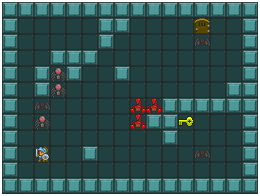

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=270481, Sun Oct 30 12:35:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.700000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -9.600000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 -1.010000000000000e+02 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
   35    490 -1.180000000000000e+02 1.9e+00 6.82e-01  7e-01  8e-01 0:03.4
   70    980 -1.200000000000000e+02 2.1e+00 4.84e-01  5e-01  6e-01 0:06.5
   71    994 -1.200000000000000e+02 2.1e+00 4.76e-01  5e-01  5e-01 0:06.6
   81   1134 -1.200000000000000e+02 2.2e+00 4.54e-01  4e-01  5e-01 0:07.5
   86   1204 -1.200000000000000e+02 2.2e+00 4.61e-01  4e-01  5e-01 0:07.9
   87   1218 -1.200000000000000e+02 2.2e+00 4.49e-01  4e-01  5e-01 0:08.0
   88   1232 -1.200000000000000e+02 2.2e+00 4.39e-01  4e-01  5e-01 0:08.1
   95   1330 -1.200000000000000e+02 2.3e+00 3.89e-01  4e-01  4e-01 0:08.7
   96   1344 -1.200000

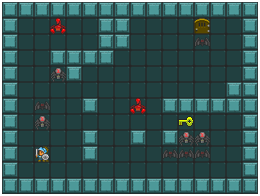

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=224437, Sun Oct 30 12:35:24 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.500000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 -9.200000000000000e+01 1.1e+00 4.34e-01  4e-01  4e-01 0:00.2
    3     42 -9.500000000000000e+01 1.1e+00 4.15e-01  4e-01  4e-01 0:00.3
   35    490 -1.100000000000000e+02 1.7e+00 4.21e-01  4e-01  5e-01 0:03.4
   83   1162 -1.170000000000000e+02 2.1e+00 3.05e-01  3e-01  3e-01 0:07.5
  100   1400 -1.190000000000000e+02 2.1e+00 2.16e-01  2e-01  2e-01 0:08.9
  146   2044 -1.190000000000000e+02 2.3e+00 1.21e-01  1e-01  1e-01 0:12.7
  147   2058 -1.190000000000000e+02 2.3e+00 1.21e-01  1e-01  1e-01 0:12.8
  148   2072 -1.190000000000000e+02 2.3e+00 1.21e-01  1e-01  1e-01 0:12.9


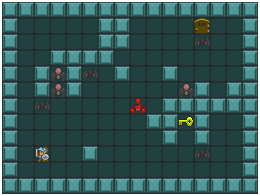

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=177237, Sun Oct 30 12:35:38 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.000000000000000e+02 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -1.010000000000000e+02 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 -1.020000000000000e+02 1.1e+00 4.55e-01  4e-01  5e-01 0:00.3
   39    546 -1.130000000000000e+02 1.6e+00 3.61e-01  3e-01  4e-01 0:03.3
   84   1176 -1.220000000000000e+02 1.8e+00 3.07e-01  3e-01  3e-01 0:07.4
  100   1400 -1.230000000000000e+02 1.9e+00 2.56e-01  2e-01  3e-01 0:08.9
  128   1792 -1.230000000000000e+02 2.0e+00 1.57e-01  1e-01  2e-01 0:11.4
  134   1876 -1.230000000000000e+02 2.0e+00 1.50e-01  1e-01  2e-01 0:11.9
  135   1890 -1.230000000000000e+02 2.1e+00 1.48e-01  1e-01  2e-01 0:12.0
  136   1904 -1.230000000000000e+02 2.1e+00 1.46e-01  1e-01  2e-01 0:12.1
  140   1960 -1.230000000000000e+02 2.1e+00 1.33e-01  1e-01  1e-01 0:12.5
  141   1974 -1.230000

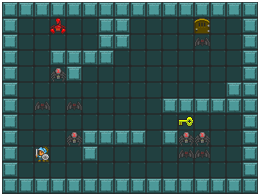

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=156028, Sun Oct 30 12:35:52 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.400000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 -8.800000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.2
    3     42 -9.100000000000000e+01 1.1e+00 4.46e-01  4e-01  5e-01 0:00.3
   38    532 -1.200000000000000e+02 1.8e+00 7.50e-01  7e-01  8e-01 0:03.3
   84   1176 -1.220000000000000e+02 2.3e+00 4.88e-01  4e-01  6e-01 0:07.4
   85   1190 -1.220000000000000e+02 2.3e+00 4.88e-01  5e-01  6e-01 0:07.5
   92   1288 -1.220000000000000e+02 2.3e+00 5.22e-01  5e-01  6e-01 0:08.0
   93   1302 -1.220000000000000e+02 2.3e+00 5.09e-01  5e-01  6e-01 0:08.1
   97   1358 -1.220000000000000e+02 2.4e+00 4.70e-01  4e-01  5e-01 0:08.4
   98   1372 -1.220000000000000e+02 2.4e+00 4.63e-01  4e-01  5e-01 0:08.5
   99   1386 -1.220000000000000e+02 2.4e+00 4.65e-01  4e-01  5e-01 0:08.6
  100   1400 -1.220000

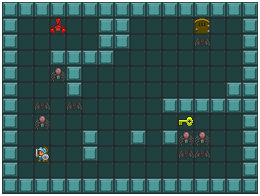

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=261374, Sun Oct 30 12:36:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.300000000000000e+01 1.0e+00 4.64e-01  5e-01  5e-01 0:00.1
    2     28 -9.300000000000000e+01 1.1e+00 4.54e-01  5e-01  5e-01 0:00.2
    3     42 -9.900000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.3
   38    532 -1.220000000000000e+02 2.1e+00 9.26e-01  9e-01  1e+00 0:03.3
   85   1190 -1.240000000000000e+02 2.5e+00 7.82e-01  7e-01  9e-01 0:07.3
   86   1204 -1.240000000000000e+02 2.6e+00 7.61e-01  7e-01  9e-01 0:07.4
   87   1218 -1.240000000000000e+02 2.6e+00 7.33e-01  7e-01  8e-01 0:07.5
   90   1260 -1.240000000000000e+02 2.6e+00 6.88e-01  6e-01  8e-01 0:07.7
   98   1372 -1.240000000000000e+02 2.6e+00 6.16e-01  6e-01  7e-01 0:08.5
  100   1400 -1.240000000000000e+02 2.6e+00 5.90e-01  5e-01  7e-01 0:08.6
  102   1428 -1.240000000000000e+02 2.7e+00 5.91e-01  5e-01  7e-01 0:08.8
  103   1442 -1.240000

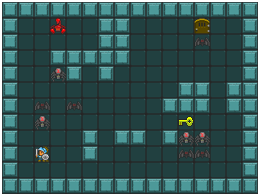

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=268815, Sun Oct 30 12:36:18 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.050000000000000e+02 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -1.040000000000000e+02 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 -1.050000000000000e+02 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
   37    518 -1.170000000000000e+02 1.9e+00 6.55e-01  6e-01  7e-01 0:03.3
   59    826 -1.170000000000000e+02 2.1e+00 4.59e-01  4e-01  5e-01 0:05.2
   62    868 -1.170000000000000e+02 2.1e+00 4.35e-01  4e-01  5e-01 0:05.5
   66    924 -1.170000000000000e+02 2.1e+00 4.25e-01  4e-01  5e-01 0:05.8
   67    938 -1.170000000000000e+02 2.2e+00 4.39e-01  4e-01  5e-01 0:05.9
   68    952 -1.170000000000000e+02 2.2e+00 4.46e-01  4e-01  5e-01 0:06.0
   69    966 -1.170000000000000e+02 2.2e+00 4.55e-01  4e-01  5e-01 0:06.1
   70    980 -1.170000000000000e+02 2.2e+00 4.57e-01  4e-01  5e-01 0:06.2
   95   1330 -1.180000

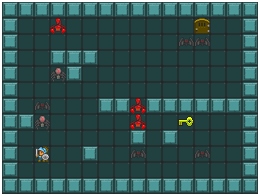

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=160811, Sun Oct 30 12:36:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.100000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 -9.400000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.2
    3     42 -9.900000000000000e+01 1.1e+00 4.51e-01  4e-01  5e-01 0:00.3
   37    518 -1.130000000000000e+02 1.9e+00 7.45e-01  7e-01  8e-01 0:03.4
   61    854 -1.130000000000000e+02 2.4e+00 7.60e-01  7e-01  9e-01 0:05.4
   62    868 -1.130000000000000e+02 2.5e+00 7.44e-01  7e-01  9e-01 0:05.5
   63    882 -1.130000000000000e+02 2.5e+00 7.34e-01  7e-01  9e-01 0:05.6
   66    924 -1.130000000000000e+02 2.5e+00 6.78e-01  6e-01  8e-01 0:05.9
   67    938 -1.130000000000000e+02 2.5e+00 6.70e-01  6e-01  8e-01 0:06.0
   68    952 -1.130000000000000e+02 2.5e+00 6.52e-01  6e-01  8e-01 0:06.1
   69    966 -1.130000000000000e+02 2.6e+00 6.48e-01  6e-01  8e-01 0:06.1
   70    980 -1.130000

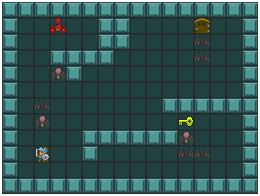

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=307044, Sun Oct 30 12:36:45 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.000000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -8.700000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.2
    3     42 -9.100000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.3
   37    518 -1.000000000000000e+02 1.7e+00 5.94e-01  6e-01  6e-01 0:03.3
   67    938 -1.000000000000000e+02 2.1e+00 5.52e-01  5e-01  6e-01 0:05.9
   68    952 -1.000000000000000e+02 2.1e+00 5.47e-01  5e-01  6e-01 0:06.0
   73   1022 -1.000000000000000e+02 2.1e+00 4.96e-01  5e-01  5e-01 0:06.4
   74   1036 -1.000000000000000e+02 2.1e+00 4.86e-01  4e-01  5e-01 0:06.5
   75   1050 -1.000000000000000e+02 2.1e+00 4.79e-01  4e-01  5e-01 0:06.6
  100   1400 -1.030000000000000e+02 2.5e+00 5.08e-01  4e-01  6e-01 0:08.8
  131   1834 -1.030000000000000e+02 2.7e+00 4.89e-01  4e-01  6e-01 0:11.5
  132   1848 -1.030000

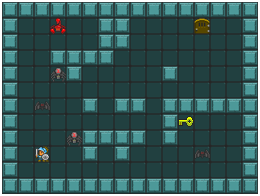

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=215606, Sun Oct 30 12:36:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.500000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -1.030000000000000e+02 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 -1.010000000000000e+02 1.1e+00 4.42e-01  4e-01  4e-01 0:00.3
   33    462 -1.210000000000000e+02 1.7e+00 4.98e-01  5e-01  6e-01 0:03.3
   54    756 -1.210000000000000e+02 1.9e+00 4.31e-01  4e-01  5e-01 0:05.2
   62    868 -1.210000000000000e+02 2.0e+00 3.83e-01  4e-01  4e-01 0:05.9
   68    952 -1.210000000000000e+02 2.0e+00 3.38e-01  3e-01  4e-01 0:06.5
   72   1008 -1.210000000000000e+02 2.0e+00 2.92e-01  3e-01  3e-01 0:06.9
   73   1022 -1.210000000000000e+02 2.0e+00 2.78e-01  3e-01  3e-01 0:07.0
   74   1036 -1.210000000000000e+02 2.0e+00 2.70e-01  2e-01  3e-01 0:07.1
   75   1050 -1.210000000000000e+02 2.0e+00 2.63e-01  2e-01  3e-01 0:07.2
   76   1064 -1.210000

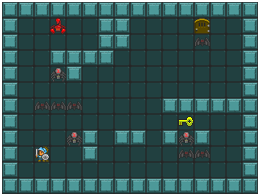

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=200116, Sun Oct 30 12:37:13 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.100000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -8.800000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.2
    3     42 -9.400000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
   37    518 -1.150000000000000e+02 1.7e+00 1.04e+00  1e+00  1e+00 0:03.4
   84   1176 -1.210000000000000e+02 2.2e+00 1.00e+00  9e-01  1e+00 0:07.4
  100   1400 -1.210000000000000e+02 2.3e+00 8.86e-01  8e-01  1e+00 0:08.8
  115   1610 -1.210000000000000e+02 2.3e+00 7.02e-01  7e-01  8e-01 0:10.1
  120   1680 -1.210000000000000e+02 2.3e+00 6.78e-01  6e-01  7e-01 0:10.6
  121   1694 -1.210000000000000e+02 2.3e+00 6.66e-01  6e-01  7e-01 0:10.7
  122   1708 -1.210000000000000e+02 2.3e+00 6.54e-01  6e-01  7e-01 0:10.7
  123   1722 -1.210000000000000e+02 2.3e+00 6.55e-01  6e-01  7e-01 0:10.8
  129   1806 -1.210000

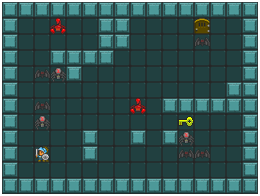

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=233768, Sun Oct 30 12:37:26 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.100000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -1.030000000000000e+02 1.1e+00 4.44e-01  4e-01  4e-01 0:00.2
    3     42 -9.500000000000000e+01 1.1e+00 4.21e-01  4e-01  4e-01 0:00.3
   36    504 -1.120000000000000e+02 1.5e+00 3.78e-01  4e-01  4e-01 0:03.3
   80   1120 -1.180000000000000e+02 2.0e+00 4.27e-01  4e-01  5e-01 0:07.4
  100   1400 -1.190000000000000e+02 2.1e+00 3.01e-01  3e-01  3e-01 0:09.1
  114   1596 -1.190000000000000e+02 2.2e+00 2.52e-01  2e-01  3e-01 0:10.5
  115   1610 -1.190000000000000e+02 2.2e+00 2.52e-01  2e-01  3e-01 0:10.6
  116   1624 -1.190000000000000e+02 2.3e+00 2.46e-01  2e-01  3e-01 0:10.6
  117   1638 -1.190000000000000e+02 2.3e+00 2.41e-01  2e-01  3e-01 0:10.7
  118   1652 -1.190000000000000e+02 2.3e+00 2.38e-01  2e-01  3e-01 0:10.8
  119   1666 -1.190000

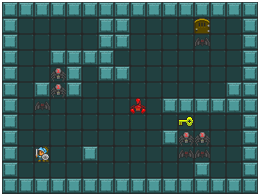

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=314724, Sun Oct 30 12:37:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.000000000000000e+02 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 -1.030000000000000e+02 1.1e+00 4.44e-01  4e-01  4e-01 0:00.2
    3     42 -1.030000000000000e+02 1.1e+00 4.39e-01  4e-01  4e-01 0:00.3
   36    504 -1.170000000000000e+02 1.9e+00 6.20e-01  6e-01  7e-01 0:03.3
   72   1008 -1.170000000000000e+02 2.2e+00 5.64e-01  5e-01  6e-01 0:06.6
   73   1022 -1.170000000000000e+02 2.2e+00 5.66e-01  5e-01  6e-01 0:06.7
   74   1036 -1.170000000000000e+02 2.2e+00 5.68e-01  5e-01  6e-01 0:06.7
  100   1400 -1.180000000000000e+02 2.4e+00 5.35e-01  5e-01  6e-01 0:09.2
  115   1610 -1.190000000000000e+02 2.7e+00 5.67e-01  5e-01  7e-01 0:10.5


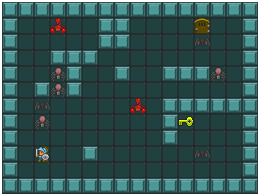

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=165357, Sun Oct 30 12:37:55 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.100000000000000e+01 1.0e+00 4.59e-01  5e-01  5e-01 0:00.1
    2     28 -9.500000000000000e+01 1.1e+00 4.37e-01  4e-01  4e-01 0:00.3
    3     42 -9.300000000000000e+01 1.1e+00 4.27e-01  4e-01  4e-01 0:00.4
   37    518 -1.080000000000000e+02 1.8e+00 4.53e-01  4e-01  5e-01 0:03.4
   82   1148 -1.130000000000000e+02 2.3e+00 9.77e-01  9e-01  1e+00 0:07.5
  100   1400 -1.140000000000000e+02 2.6e+00 1.10e+00  1e+00  1e+00 0:09.1
  125   1750 -1.140000000000000e+02 3.1e+00 1.18e+00  1e+00  2e+00 0:11.3
  126   1764 -1.140000000000000e+02 3.1e+00 1.15e+00  1e+00  1e+00 0:11.4
  127   1778 -1.140000000000000e+02 3.1e+00 1.12e+00  1e+00  1e+00 0:11.4
  128   1792 -1.140000000000000e+02 3.1e+00 1.09e+00  1e+00  1e+00 0:11.5
  131   1834 -1.140000000000000e+02 3.1e+00 9.98e-01  9e-01  1e+00 0:11.8
  132   1848 -1.140000

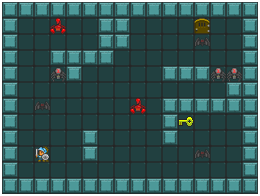

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=221631, Sun Oct 30 12:38:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.400000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 -8.900000000000000e+01 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 -8.900000000000000e+01 1.1e+00 4.35e-01  4e-01  4e-01 0:00.3
   36    504 -1.140000000000000e+02 2.0e+00 7.62e-01  7e-01  9e-01 0:03.3
   80   1120 -1.150000000000000e+02 2.6e+00 6.51e-01  6e-01  8e-01 0:07.3
   82   1148 -1.150000000000000e+02 2.6e+00 6.19e-01  6e-01  8e-01 0:07.5
   85   1190 -1.150000000000000e+02 2.7e+00 5.98e-01  5e-01  7e-01 0:07.7
   86   1204 -1.150000000000000e+02 2.7e+00 5.93e-01  5e-01  7e-01 0:07.8
   92   1288 -1.150000000000000e+02 2.7e+00 5.89e-01  5e-01  7e-01 0:08.3
   93   1302 -1.150000000000000e+02 2.7e+00 5.91e-01  5e-01  7e-01 0:08.4
   94   1316 -1.150000000000000e+02 2.7e+00 5.95e-01  5e-01  7e-01 0:08.5
   95   1330 -1.150000

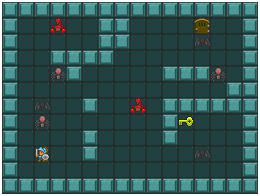

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=312542, Sun Oct 30 12:38:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.700000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -9.900000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.3
    3     42 -9.900000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.4
   38    532 -1.200000000000000e+02 1.7e+00 5.34e-01  5e-01  6e-01 0:03.5
   84   1176 -1.260000000000000e+02 1.9e+00 4.27e-01  4e-01  5e-01 0:07.5
  100   1400 -1.270000000000000e+02 1.9e+00 3.54e-01  3e-01  4e-01 0:09.0
  130   1820 -1.270000000000000e+02 2.0e+00 3.21e-01  3e-01  4e-01 0:11.7
  145   2030 -1.270000000000000e+02 2.1e+00 3.14e-01  3e-01  3e-01 0:13.0
  146   2044 -1.270000000000000e+02 2.1e+00 3.04e-01  3e-01  3e-01 0:13.1
  147   2058 -1.270000000000000e+02 2.2e+00 3.02e-01  3e-01  3e-01 0:13.1


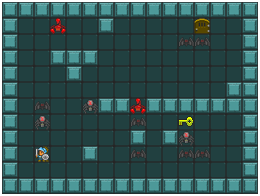

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=252439, Sun Oct 30 12:38:36 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.000000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 -1.000000000000000e+02 1.1e+00 4.66e-01  5e-01  5e-01 0:00.2
    3     42 -1.000000000000000e+02 1.1e+00 4.59e-01  5e-01  5e-01 0:00.3
   37    518 -1.210000000000000e+02 1.7e+00 5.06e-01  5e-01  6e-01 0:03.3
   83   1162 -1.280000000000000e+02 2.3e+00 5.06e-01  5e-01  6e-01 0:07.4
  100   1400 -1.280000000000000e+02 2.4e+00 3.90e-01  3e-01  5e-01 0:08.9
  102   1428 -1.280000000000000e+02 2.4e+00 3.79e-01  3e-01  4e-01 0:09.0
  103   1442 -1.280000000000000e+02 2.4e+00 3.70e-01  3e-01  4e-01 0:09.1
  106   1484 -1.280000000000000e+02 2.4e+00 3.66e-01  3e-01  4e-01 0:09.4
  107   1498 -1.280000000000000e+02 2.4e+00 3.69e-01  3e-01  4e-01 0:09.4
  116   1624 -1.280000000000000e+02 2.4e+00 2.99e-01  3e-01  4e-01 0:10.2
  117   1638 -1.280000

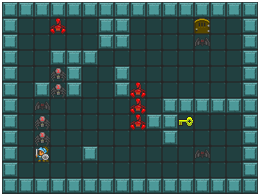

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=153943, Sun Oct 30 12:38:50 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.800000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 -9.900000000000000e+01 1.1e+00 4.73e-01  5e-01  5e-01 0:00.2
    3     42 -1.050000000000000e+02 1.1e+00 4.79e-01  5e-01  5e-01 0:00.3
   40    560 -1.230000000000000e+02 1.9e+00 7.59e-01  7e-01  9e-01 0:03.3
   87   1218 -1.240000000000000e+02 2.3e+00 8.78e-01  8e-01  1e+00 0:07.3
  100   1400 -1.250000000000000e+02 2.4e+00 7.64e-01  7e-01  9e-01 0:08.4
  111   1554 -1.250000000000000e+02 2.5e+00 6.29e-01  6e-01  8e-01 0:09.3
  117   1638 -1.250000000000000e+02 2.5e+00 6.46e-01  6e-01  8e-01 0:09.8
  118   1652 -1.250000000000000e+02 2.6e+00 6.54e-01  6e-01  8e-01 0:09.9
  121   1694 -1.250000000000000e+02 2.6e+00 6.62e-01  6e-01  8e-01 0:10.1
  122   1708 -1.250000000000000e+02 2.6e+00 6.53e-01  6e-01  8e-01 0:10.2
  125   1750 -1.250000

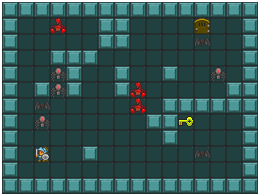

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=216491, Sun Oct 30 12:39:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.400000000000000e+01 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 -9.400000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.2
    3     42 -9.500000000000000e+01 1.1e+00 4.28e-01  4e-01  4e-01 0:00.3
   38    532 -1.050000000000000e+02 1.7e+00 6.39e-01  6e-01  7e-01 0:03.3
   84   1176 -1.070000000000000e+02 2.0e+00 4.55e-01  4e-01  5e-01 0:07.4
  100   1400 -1.070000000000000e+02 2.3e+00 5.13e-01  5e-01  6e-01 0:08.8
  133   1862 -1.070000000000000e+02 2.6e+00 3.59e-01  3e-01  4e-01 0:11.5
  134   1876 -1.070000000000000e+02 2.6e+00 3.57e-01  3e-01  4e-01 0:11.6
  137   1918 -1.070000000000000e+02 2.6e+00 3.42e-01  3e-01  4e-01 0:11.8
  146   2044 -1.070000000000000e+02 2.7e+00 2.80e-01  2e-01  3e-01 0:12.6
  147   2058 -1.070000000000000e+02 2.7e+00 2.78e-01  2e-01  3e-01 0:12.6
  148   2072 -1.070000

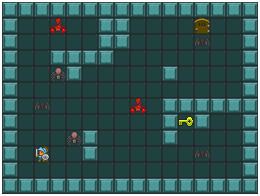

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=195297, Sun Oct 30 12:39:16 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.020000000000000e+02 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -1.040000000000000e+02 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 -1.050000000000000e+02 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
   38    532 -1.180000000000000e+02 1.6e+00 6.04e-01  6e-01  6e-01 0:03.4
   86   1204 -1.190000000000000e+02 2.0e+00 4.84e-01  4e-01  5e-01 0:07.3
   87   1218 -1.190000000000000e+02 2.0e+00 4.76e-01  4e-01  5e-01 0:07.4
   90   1260 -1.190000000000000e+02 2.0e+00 4.63e-01  4e-01  5e-01 0:07.7
   91   1274 -1.190000000000000e+02 2.0e+00 4.58e-01  4e-01  5e-01 0:07.8
   96   1344 -1.190000000000000e+02 2.0e+00 3.96e-01  4e-01  4e-01 0:08.2
   97   1358 -1.190000000000000e+02 2.1e+00 3.86e-01  3e-01  4e-01 0:08.3
  100   1400 -1.190000000000000e+02 2.1e+00 3.59e-01  3e-01  4e-01 0:08.5
  101   1414 -1.190000

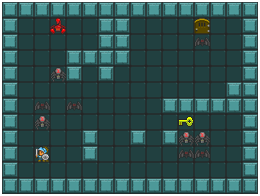

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=248951, Sun Oct 30 12:39:29 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.400000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -9.600000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.2
    3     42 -9.300000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.3
   36    504 -1.180000000000000e+02 1.6e+00 5.58e-01  5e-01  6e-01 0:03.4
   82   1148 -1.290000000000000e+02 2.3e+00 8.79e-01  8e-01  1e+00 0:07.4
  100   1400 -1.300000000000000e+02 2.6e+00 8.75e-01  8e-01  1e+00 0:09.1


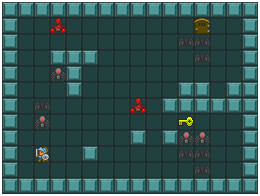

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=169009, Sun Oct 30 12:39:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.300000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -9.900000000000000e+01 1.1e+00 4.65e-01  5e-01  5e-01 0:00.2
    3     42 -9.400000000000000e+01 1.1e+00 4.68e-01  5e-01  5e-01 0:00.3
   37    518 -1.170000000000000e+02 1.9e+00 6.15e-01  6e-01  7e-01 0:03.3
   81   1134 -1.210000000000000e+02 2.3e+00 3.87e-01  4e-01  4e-01 0:07.4
  100   1400 -1.210000000000000e+02 2.4e+00 3.34e-01  3e-01  4e-01 0:09.0
  101   1414 -1.210000000000000e+02 2.4e+00 3.34e-01  3e-01  4e-01 0:09.1
  114   1596 -1.210000000000000e+02 2.5e+00 3.29e-01  3e-01  4e-01 0:10.3
  115   1610 -1.210000000000000e+02 2.5e+00 3.32e-01  3e-01  4e-01 0:10.4
  116   1624 -1.210000000000000e+02 2.5e+00 3.40e-01  3e-01  4e-01 0:10.4
  117   1638 -1.210000000000000e+02 2.5e+00 3.42e-01  3e-01  4e-01 0:10.5
  118   1652 -1.210000

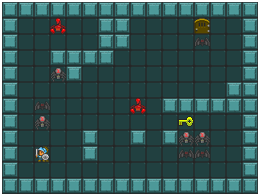

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=304710, Sun Oct 30 12:39:56 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.300000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -9.200000000000000e+01 1.1e+00 4.54e-01  5e-01  5e-01 0:00.2
    3     42 -8.900000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
   36    504 -1.160000000000000e+02 1.7e+00 5.10e-01  5e-01  6e-01 0:03.4
   71    994 -1.160000000000000e+02 1.9e+00 3.63e-01  3e-01  4e-01 0:06.5
  100   1400 -1.160000000000000e+02 2.1e+00 2.97e-01  3e-01  3e-01 0:09.2
  118   1652 -1.160000000000000e+02 2.2e+00 2.88e-01  3e-01  3e-01 0:10.8
  138   1932 -1.170000000000000e+02 2.4e+00 3.12e-01  3e-01  3e-01 0:12.6
  139   1946 -1.170000000000000e+02 2.4e+00 3.17e-01  3e-01  3e-01 0:12.7
  146   2044 -1.170000000000000e+02 2.4e+00 3.18e-01  3e-01  3e-01 0:13.3
  147   2058 -1.170000000000000e+02 2.5e+00 3.13e-01  3e-01  3e-01 0:13.4
  148   2072 -1.170000

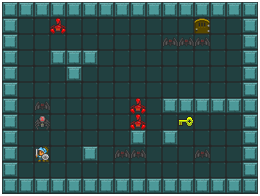

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=245564, Sun Oct 30 12:40:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.900000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -9.400000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
    3     42 -9.900000000000000e+01 1.1e+00 4.44e-01  4e-01  4e-01 0:00.3
   36    504 -1.200000000000000e+02 1.8e+00 6.88e-01  7e-01  8e-01 0:03.3
   81   1134 -1.260000000000000e+02 2.2e+00 4.85e-01  4e-01  6e-01 0:07.3
  100   1400 -1.260000000000000e+02 2.3e+00 4.72e-01  4e-01  6e-01 0:09.1
  104   1456 -1.260000000000000e+02 2.4e+00 4.44e-01  4e-01  5e-01 0:09.5
  110   1540 -1.260000000000000e+02 2.4e+00 4.42e-01  4e-01  5e-01 0:10.0
  111   1554 -1.260000000000000e+02 2.4e+00 4.32e-01  4e-01  5e-01 0:10.1
  112   1568 -1.260000000000000e+02 2.4e+00 4.24e-01  4e-01  5e-01 0:10.2
  113   1582 -1.260000000000000e+02 2.4e+00 4.20e-01  4e-01  5e-01 0:10.3
  114   1596 -1.260000

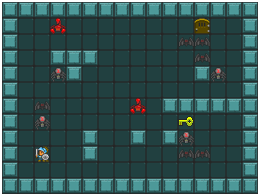

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=259389, Sun Oct 30 12:40:24 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.700000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -9.100000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 -9.700000000000000e+01 1.1e+00 4.43e-01  4e-01  4e-01 0:00.3
   36    504 -1.170000000000000e+02 1.8e+00 5.75e-01  5e-01  6e-01 0:03.3
   73   1022 -1.170000000000000e+02 2.1e+00 3.85e-01  3e-01  4e-01 0:06.4
   76   1064 -1.170000000000000e+02 2.2e+00 3.47e-01  3e-01  4e-01 0:06.7
   81   1134 -1.170000000000000e+02 2.2e+00 2.93e-01  3e-01  3e-01 0:07.1
   82   1148 -1.170000000000000e+02 2.2e+00 2.85e-01  3e-01  3e-01 0:07.2
   83   1162 -1.170000000000000e+02 2.2e+00 2.76e-01  2e-01  3e-01 0:07.3
   84   1176 -1.170000000000000e+02 2.2e+00 2.72e-01  2e-01  3e-01 0:07.4
   85   1190 -1.170000000000000e+02 2.2e+00 2.69e-01  2e-01  3e-01 0:07.4
   86   1204 -1.170000

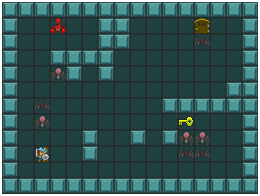

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=208704, Sun Oct 30 12:40:38 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.400000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -1.000000000000000e+02 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 -9.900000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.3
   37    518 -1.200000000000000e+02 2.1e+00 7.54e-01  7e-01  9e-01 0:03.3
   81   1134 -1.230000000000000e+02 2.4e+00 5.82e-01  5e-01  7e-01 0:07.3
  100   1400 -1.270000000000000e+02 2.5e+00 5.85e-01  5e-01  7e-01 0:08.9
  108   1512 -1.230000000000000e+02 2.5e+00 4.90e-01  5e-01  6e-01 0:09.6
  109   1526 -1.230000000000000e+02 2.5e+00 4.78e-01  4e-01  6e-01 0:09.7


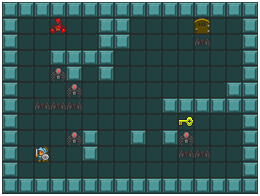

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=233844, Sun Oct 30 12:40:51 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.600000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -1.010000000000000e+02 1.1e+00 4.53e-01  4e-01  5e-01 0:00.3
    3     42 -1.010000000000000e+02 1.1e+00 4.40e-01  4e-01  4e-01 0:00.4
   37    518 -1.230000000000000e+02 1.6e+00 4.13e-01  4e-01  4e-01 0:03.4
   83   1162 -1.280000000000000e+02 2.2e+00 3.34e-01  3e-01  4e-01 0:07.4
  100   1400 -1.280000000000000e+02 2.2e+00 2.16e-01  2e-01  2e-01 0:08.9
  106   1484 -1.280000000000000e+02 2.3e+00 1.99e-01  2e-01  2e-01 0:09.4
  113   1582 -1.280000000000000e+02 2.4e+00 2.19e-01  2e-01  2e-01 0:10.0
  119   1666 -1.280000000000000e+02 2.5e+00 2.26e-01  2e-01  2e-01 0:10.5
  120   1680 -1.280000000000000e+02 2.5e+00 2.27e-01  2e-01  2e-01 0:10.5
  132   1848 -1.280000000000000e+02 2.6e+00 2.01e-01  2e-01  2e-01 0:11.6
  140   1960 -1.280000

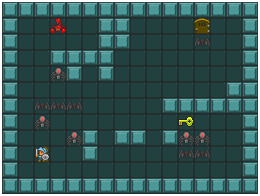

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=212318, Sun Oct 30 12:41:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.700000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -9.300000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.3
    3     42 -9.400000000000000e+01 1.1e+00 4.65e-01  5e-01  5e-01 0:00.4
   38    532 -1.100000000000000e+02 1.9e+00 8.44e-01  8e-01  1e+00 0:03.4
   82   1148 -1.120000000000000e+02 2.1e+00 7.44e-01  7e-01  9e-01 0:07.4
   90   1260 -1.120000000000000e+02 2.2e+00 6.64e-01  6e-01  8e-01 0:08.1
   91   1274 -1.120000000000000e+02 2.2e+00 6.52e-01  6e-01  7e-01 0:08.1
   92   1288 -1.120000000000000e+02 2.2e+00 6.38e-01  6e-01  7e-01 0:08.2
   93   1302 -1.120000000000000e+02 2.2e+00 6.18e-01  6e-01  7e-01 0:08.3
   94   1316 -1.120000000000000e+02 2.2e+00 5.98e-01  5e-01  7e-01 0:08.4
   95   1330 -1.120000000000000e+02 2.2e+00 5.78e-01  5e-01  7e-01 0:08.5
   96   1344 -1.120000

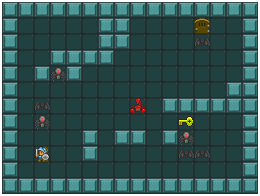

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=232356, Sun Oct 30 12:41:18 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.900000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -1.010000000000000e+02 1.1e+00 4.63e-01  5e-01  5e-01 0:00.2
    3     42 -9.800000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.3
   37    518 -1.150000000000000e+02 1.6e+00 3.79e-01  4e-01  4e-01 0:03.4
   65    910 -1.150000000000000e+02 1.8e+00 2.44e-01  2e-01  3e-01 0:05.9
   66    924 -1.150000000000000e+02 1.8e+00 2.41e-01  2e-01  3e-01 0:06.1
   72   1008 -1.150000000000000e+02 1.8e+00 2.14e-01  2e-01  2e-01 0:06.6
   76   1064 -1.150000000000000e+02 1.8e+00 2.11e-01  2e-01  2e-01 0:06.9
   77   1078 -1.150000000000000e+02 1.8e+00 2.11e-01  2e-01  2e-01 0:07.0
   78   1092 -1.150000000000000e+02 1.8e+00 2.12e-01  2e-01  2e-01 0:07.1
   79   1106 -1.150000000000000e+02 1.8e+00 2.08e-01  2e-01  2e-01 0:07.2
   80   1120 -1.150000

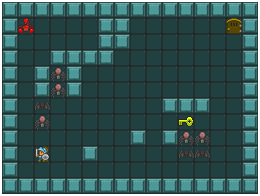

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=278208, Sun Oct 30 12:41:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.600000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 -9.900000000000000e+01 1.1e+00 4.60e-01  5e-01  5e-01 0:00.3
    3     42 -1.080000000000000e+02 1.1e+00 4.56e-01  5e-01  5e-01 0:00.4
   36    504 -1.200000000000000e+02 1.6e+00 4.81e-01  5e-01  5e-01 0:03.4
   85   1190 -1.220000000000000e+02 1.9e+00 2.53e-01  2e-01  3e-01 0:07.5
   96   1344 -1.220000000000000e+02 1.9e+00 2.09e-01  2e-01  2e-01 0:08.3
  100   1400 -1.220000000000000e+02 1.9e+00 2.02e-01  2e-01  2e-01 0:08.7
  103   1442 -1.220000000000000e+02 1.9e+00 1.95e-01  2e-01  2e-01 0:09.0
  104   1456 -1.220000000000000e+02 1.9e+00 1.96e-01  2e-01  2e-01 0:09.1
  110   1540 -1.220000000000000e+02 1.9e+00 2.02e-01  2e-01  2e-01 0:09.5
  111   1554 -1.220000000000000e+02 1.9e+00 2.00e-01  2e-01  2e-01 0:09.6
  116   1624 -1.220000

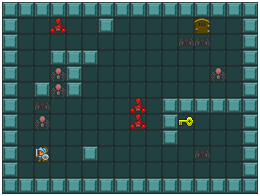

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=238347, Sun Oct 30 12:41:46 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.000000000000000e+01 1.0e+00 4.62e-01  5e-01  5e-01 0:00.1
    2     28 -8.900000000000000e+01 1.1e+00 4.47e-01  4e-01  4e-01 0:00.3
    3     42 -9.300000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.4
   38    532 -1.120000000000000e+02 1.7e+00 6.17e-01  6e-01  7e-01 0:03.4
   85   1190 -1.270000000000000e+02 2.2e+00 4.55e-01  4e-01  5e-01 0:07.5
  100   1400 -1.270000000000000e+02 2.3e+00 4.61e-01  4e-01  5e-01 0:08.8
  115   1610 -1.270000000000000e+02 2.3e+00 3.49e-01  3e-01  4e-01 0:10.0
  116   1624 -1.270000000000000e+02 2.3e+00 3.55e-01  3e-01  4e-01 0:10.1
  125   1750 -1.270000000000000e+02 2.4e+00 3.32e-01  3e-01  4e-01 0:10.8
  129   1806 -1.270000000000000e+02 2.4e+00 3.24e-01  3e-01  3e-01 0:11.0
  130   1820 -1.270000000000000e+02 2.4e+00 3.15e-01  3e-01  3e-01 0:11.2
  131   1834 -1.270000

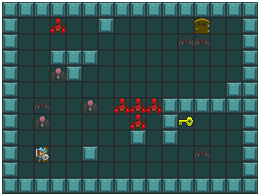

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=227483, Sun Oct 30 12:41:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.000000000000000e+02 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -9.600000000000000e+01 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 -1.040000000000000e+02 1.1e+00 4.32e-01  4e-01  4e-01 0:00.3
   37    518 -1.190000000000000e+02 1.8e+00 6.14e-01  6e-01  7e-01 0:03.4
   70    980 -1.200000000000000e+02 2.1e+00 4.65e-01  4e-01  5e-01 0:06.3
   71    994 -1.200000000000000e+02 2.1e+00 4.59e-01  4e-01  5e-01 0:06.4
   83   1162 -1.200000000000000e+02 2.1e+00 3.97e-01  4e-01  4e-01 0:07.4
   84   1176 -1.200000000000000e+02 2.1e+00 3.99e-01  4e-01  5e-01 0:07.4
   85   1190 -1.200000000000000e+02 2.1e+00 3.91e-01  4e-01  4e-01 0:07.5
   86   1204 -1.200000000000000e+02 2.1e+00 3.84e-01  3e-01  4e-01 0:07.6
   87   1218 -1.200000000000000e+02 2.1e+00 3.73e-01  3e-01  4e-01 0:07.7
   88   1232 -1.200000

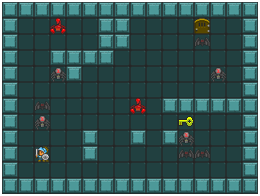

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=296567, Sun Oct 30 12:42:12 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.800000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -9.000000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.2
    3     42 -9.400000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.4
   39    546 -1.150000000000000e+02 1.9e+00 9.05e-01  9e-01  1e+00 0:03.4
   74   1036 -1.160000000000000e+02 2.3e+00 6.12e-01  6e-01  7e-01 0:06.4
   82   1148 -1.160000000000000e+02 2.4e+00 5.77e-01  5e-01  7e-01 0:07.1
   83   1162 -1.160000000000000e+02 2.4e+00 5.61e-01  5e-01  7e-01 0:07.1
   84   1176 -1.160000000000000e+02 2.4e+00 5.52e-01  5e-01  7e-01 0:07.2
   85   1190 -1.160000000000000e+02 2.4e+00 5.52e-01  5e-01  7e-01 0:07.3
   86   1204 -1.160000000000000e+02 2.4e+00 5.46e-01  5e-01  7e-01 0:07.4
   87   1218 -1.160000000000000e+02 2.4e+00 5.44e-01  5e-01  6e-01 0:07.5
   88   1232 -1.160000

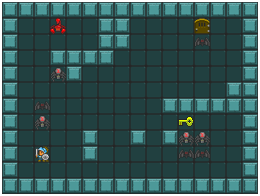

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=200512, Sun Oct 30 12:42:26 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.300000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 -9.400000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 -9.500000000000000e+01 1.1e+00 4.45e-01  4e-01  5e-01 0:00.3
   38    532 -1.160000000000000e+02 1.9e+00 8.40e-01  8e-01  9e-01 0:03.3
   74   1036 -1.220000000000000e+02 2.3e+00 7.28e-01  7e-01  8e-01 0:06.4
   75   1050 -1.220000000000000e+02 2.3e+00 7.15e-01  7e-01  8e-01 0:06.5
   89   1246 -1.220000000000000e+02 2.3e+00 5.97e-01  5e-01  7e-01 0:07.7
   90   1260 -1.220000000000000e+02 2.3e+00 5.93e-01  5e-01  7e-01 0:07.8
   93   1302 -1.220000000000000e+02 2.3e+00 5.88e-01  5e-01  7e-01 0:08.0
   94   1316 -1.220000000000000e+02 2.3e+00 5.91e-01  5e-01  7e-01 0:08.1
   95   1330 -1.220000000000000e+02 2.3e+00 6.00e-01  5e-01  7e-01 0:08.2
   98   1372 -1.220000

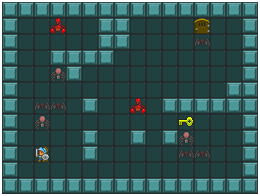

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=192502, Sun Oct 30 12:42:39 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.300000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 -8.500000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.2
    3     42 -1.000000000000000e+02 1.1e+00 4.42e-01  4e-01  4e-01 0:00.3
   35    490 -1.110000000000000e+02 1.7e+00 5.43e-01  5e-01  6e-01 0:03.3
   69    966 -1.110000000000000e+02 2.1e+00 5.79e-01  5e-01  7e-01 0:06.4
   72   1008 -1.110000000000000e+02 2.1e+00 5.58e-01  5e-01  7e-01 0:06.7
   73   1022 -1.110000000000000e+02 2.1e+00 5.56e-01  5e-01  6e-01 0:06.8
   74   1036 -1.110000000000000e+02 2.1e+00 5.53e-01  5e-01  6e-01 0:06.9
   80   1120 -1.110000000000000e+02 2.1e+00 5.15e-01  5e-01  6e-01 0:07.4
   81   1134 -1.110000000000000e+02 2.1e+00 5.19e-01  5e-01  6e-01 0:07.5
   82   1148 -1.110000000000000e+02 2.1e+00 5.27e-01  5e-01  6e-01 0:07.6
   83   1162 -1.110000

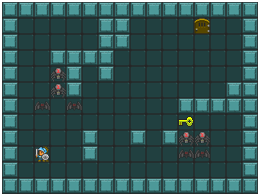

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=212383, Sun Oct 30 12:42:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.900000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -9.000000000000000e+01 1.1e+00 4.47e-01  4e-01  4e-01 0:00.2
    3     42 -9.100000000000000e+01 1.1e+00 4.32e-01  4e-01  4e-01 0:00.3
   37    518 -1.240000000000000e+02 1.9e+00 5.68e-01  5e-01  6e-01 0:03.4
   83   1162 -1.260000000000000e+02 2.4e+00 4.74e-01  4e-01  5e-01 0:07.4
  100   1400 -1.260000000000000e+02 2.7e+00 5.14e-01  5e-01  6e-01 0:08.9
  105   1470 -1.260000000000000e+02 2.8e+00 5.30e-01  5e-01  6e-01 0:09.3
  111   1554 -1.260000000000000e+02 3.0e+00 5.40e-01  5e-01  6e-01 0:09.8
  112   1568 -1.260000000000000e+02 3.0e+00 5.36e-01  5e-01  6e-01 0:09.9
  113   1582 -1.260000000000000e+02 3.0e+00 5.33e-01  5e-01  6e-01 0:09.9
  116   1624 -1.260000000000000e+02 3.0e+00 5.15e-01  5e-01  6e-01 0:10.2
  117   1638 -1.260000

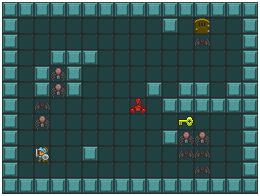

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=266671, Sun Oct 30 12:43:06 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.400000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 -8.500000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 -8.600000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.3
   38    532 -9.900000000000000e+01 1.6e+00 4.33e-01  4e-01  5e-01 0:03.3
   78   1092 -1.000000000000000e+02 2.0e+00 2.72e-01  2e-01  3e-01 0:06.9
   79   1106 -1.000000000000000e+02 2.0e+00 2.63e-01  2e-01  3e-01 0:07.0
   80   1120 -1.000000000000000e+02 2.0e+00 2.55e-01  2e-01  3e-01 0:07.1
   81   1134 -1.000000000000000e+02 2.0e+00 2.48e-01  2e-01  3e-01 0:07.2
   82   1148 -1.000000000000000e+02 2.0e+00 2.40e-01  2e-01  3e-01 0:07.3
   83   1162 -1.000000000000000e+02 2.0e+00 2.29e-01  2e-01  2e-01 0:07.3
   84   1176 -1.000000000000000e+02 2.0e+00 2.20e-01  2e-01  2e-01 0:07.4
   85   1190 -1.000000

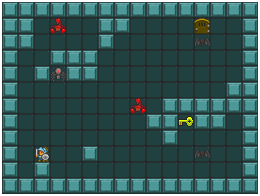

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=234995, Sun Oct 30 12:43:20 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.300000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 -9.500000000000000e+01 1.1e+00 4.55e-01  4e-01  5e-01 0:00.3
    3     42 -1.000000000000000e+02 1.1e+00 4.53e-01  4e-01  5e-01 0:00.3
   36    504 -1.110000000000000e+02 1.7e+00 4.52e-01  4e-01  5e-01 0:03.4
   83   1162 -1.170000000000000e+02 2.0e+00 5.34e-01  5e-01  6e-01 0:07.4
  100   1400 -1.170000000000000e+02 2.2e+00 4.66e-01  4e-01  5e-01 0:08.9
  101   1414 -1.170000000000000e+02 2.2e+00 4.62e-01  4e-01  5e-01 0:09.0
  102   1428 -1.170000000000000e+02 2.2e+00 4.55e-01  4e-01  5e-01 0:09.1
  110   1540 -1.170000000000000e+02 2.2e+00 3.76e-01  3e-01  4e-01 0:09.8
  115   1610 -1.170000000000000e+02 2.3e+00 3.33e-01  3e-01  4e-01 0:10.2
  116   1624 -1.170000000000000e+02 2.3e+00 3.28e-01  3e-01  4e-01 0:10.3
  117   1638 -1.170000

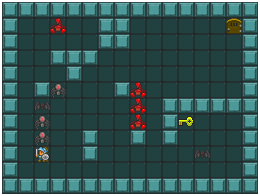

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=279068, Sun Oct 30 12:43:33 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.200000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -8.900000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 -8.700000000000000e+01 1.1e+00 4.36e-01  4e-01  4e-01 0:00.3
   38    532 -1.210000000000000e+02 1.7e+00 4.03e-01  4e-01  4e-01 0:03.4
   86   1204 -1.230000000000000e+02 2.0e+00 3.94e-01  4e-01  5e-01 0:07.5
  100   1400 -1.250000000000000e+02 2.2e+00 4.84e-01  4e-01  6e-01 0:08.7
  122   1708 -1.250000000000000e+02 2.3e+00 3.29e-01  3e-01  4e-01 0:10.6


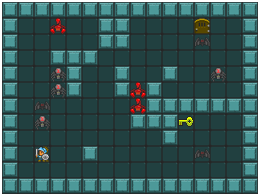

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=150782, Sun Oct 30 12:43:47 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.090000000000000e+02 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -1.050000000000000e+02 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 -1.040000000000000e+02 1.1e+00 4.38e-01  4e-01  4e-01 0:00.3
   38    532 -1.150000000000000e+02 1.5e+00 3.88e-01  4e-01  4e-01 0:03.4
   49    686 -1.150000000000000e+02 1.6e+00 3.27e-01  3e-01  3e-01 0:04.3
   50    700 -1.150000000000000e+02 1.6e+00 3.25e-01  3e-01  3e-01 0:04.4
   51    714 -1.150000000000000e+02 1.6e+00 3.23e-01  3e-01  3e-01 0:04.5
   58    812 -1.150000000000000e+02 1.6e+00 3.00e-01  3e-01  3e-01 0:05.1
   59    826 -1.150000000000000e+02 1.6e+00 2.93e-01  3e-01  3e-01 0:05.2
   60    840 -1.150000000000000e+02 1.6e+00 2.92e-01  3e-01  3e-01 0:05.3
   61    854 -1.150000000000000e+02 1.6e+00 2.94e-01  3e-01  3e-01 0:05.4
   64    896 -1.150000

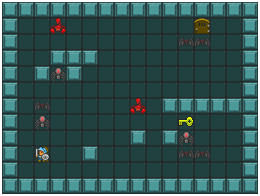

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=266773, Sun Oct 30 12:44:00 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.300000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 -8.600000000000000e+01 1.1e+00 4.45e-01  4e-01  4e-01 0:00.2
    3     42 -9.100000000000000e+01 1.1e+00 4.33e-01  4e-01  4e-01 0:00.3
   39    546 -1.090000000000000e+02 1.8e+00 4.99e-01  5e-01  6e-01 0:03.4
   86   1204 -1.150000000000000e+02 2.4e+00 4.92e-01  5e-01  6e-01 0:07.5
  100   1400 -1.200000000000000e+02 2.4e+00 5.23e-01  5e-01  6e-01 0:08.7
  109   1526 -1.200000000000000e+02 2.5e+00 5.45e-01  5e-01  6e-01 0:09.5
  123   1722 -1.200000000000000e+02 2.9e+00 5.21e-01  5e-01  6e-01 0:10.7
  126   1764 -1.200000000000000e+02 2.9e+00 4.78e-01  4e-01  6e-01 0:10.9
  137   1918 -1.200000000000000e+02 2.9e+00 4.35e-01  4e-01  5e-01 0:11.9
  138   1932 -1.200000000000000e+02 3.0e+00 4.47e-01  4e-01  5e-01 0:12.0
  139   1946 -1.200000

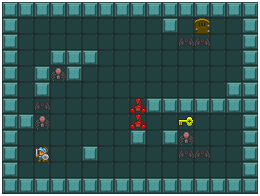

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=184412, Sun Oct 30 12:44:14 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.300000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -8.000000000000000e+01 1.1e+00 4.65e-01  5e-01  5e-01 0:00.2
    3     42 -9.000000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.3
   38    532 -1.050000000000000e+02 1.9e+00 6.22e-01  6e-01  7e-01 0:03.4
   57    798 -1.060000000000000e+02 2.0e+00 5.16e-01  5e-01  6e-01 0:05.0
   60    840 -1.060000000000000e+02 2.1e+00 5.12e-01  5e-01  6e-01 0:05.3
   61    854 -1.060000000000000e+02 2.1e+00 5.06e-01  5e-01  6e-01 0:05.4
   62    868 -1.060000000000000e+02 2.1e+00 4.97e-01  5e-01  6e-01 0:05.4
   65    910 -1.060000000000000e+02 2.1e+00 4.72e-01  4e-01  6e-01 0:05.7
   66    924 -1.060000000000000e+02 2.1e+00 4.67e-01  4e-01  6e-01 0:05.8
   67    938 -1.060000000000000e+02 2.1e+00 4.59e-01  4e-01  5e-01 0:05.9
   68    952 -1.060000

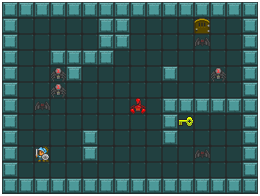

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=256439, Sun Oct 30 12:44:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.700000000000000e+01 1.0e+00 4.62e-01  5e-01  5e-01 0:00.1
    2     28 -9.300000000000000e+01 1.1e+00 4.40e-01  4e-01  4e-01 0:00.2
    3     42 -9.000000000000000e+01 1.1e+00 4.31e-01  4e-01  4e-01 0:00.3
   38    532 -1.160000000000000e+02 1.9e+00 5.67e-01  5e-01  6e-01 0:03.3
   86   1204 -1.210000000000000e+02 2.2e+00 4.24e-01  4e-01  5e-01 0:07.3
  100   1400 -1.220000000000000e+02 2.3e+00 4.67e-01  4e-01  5e-01 0:08.5


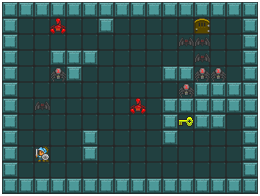

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=265734, Sun Oct 30 12:44:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.300000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -9.700000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.2
    3     42 -9.700000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
   38    532 -1.160000000000000e+02 1.6e+00 4.46e-01  4e-01  5e-01 0:03.3
   73   1022 -1.160000000000000e+02 1.9e+00 4.13e-01  4e-01  4e-01 0:06.4
   82   1148 -1.160000000000000e+02 2.0e+00 3.79e-01  3e-01  4e-01 0:07.2
  100   1400 -1.160000000000000e+02 2.1e+00 3.71e-01  3e-01  4e-01 0:08.7
  110   1540 -1.160000000000000e+02 2.1e+00 2.76e-01  2e-01  3e-01 0:09.6
  111   1554 -1.160000000000000e+02 2.1e+00 2.68e-01  2e-01  3e-01 0:09.7
  112   1568 -1.160000000000000e+02 2.1e+00 2.67e-01  2e-01  3e-01 0:09.7
  113   1582 -1.160000000000000e+02 2.2e+00 2.69e-01  2e-01  3e-01 0:09.8
  114   1596 -1.160000

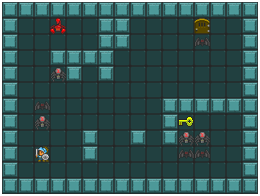

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=188628, Sun Oct 30 12:44:54 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.100000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 -9.500000000000000e+01 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 -9.300000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.3
   38    532 -1.110000000000000e+02 1.7e+00 4.59e-01  4e-01  5e-01 0:03.4
   61    854 -1.110000000000000e+02 1.8e+00 3.68e-01  3e-01  4e-01 0:05.4
   71    994 -1.110000000000000e+02 1.8e+00 3.45e-01  3e-01  4e-01 0:06.3
   75   1050 -1.110000000000000e+02 1.8e+00 3.12e-01  3e-01  3e-01 0:06.6
   76   1064 -1.110000000000000e+02 1.8e+00 3.07e-01  3e-01  3e-01 0:06.7
   79   1106 -1.110000000000000e+02 1.8e+00 2.96e-01  3e-01  3e-01 0:07.0
   80   1120 -1.110000000000000e+02 1.8e+00 2.92e-01  3e-01  3e-01 0:07.1
   81   1134 -1.110000000000000e+02 1.8e+00 2.84e-01  3e-01  3e-01 0:07.1
   86   1204 -1.110000

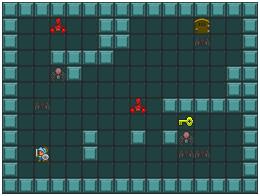

mean score:-119.24
mean counts:119.24
mean changes:35.26
mean playability:1.0
mean hamming dist:15.840816326530613


In [5]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-700/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf1)


(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=305782, Sun Oct 30 12:45:07 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.500000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 7.200000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.2
    3     42 7.000000000000000e+01 1.1e+00 4.41e-01  4e-01  4e-01 0:00.3
   38    532 6.200000000000000e+01 1.6e+00 3.10e-01  3e-01  3e-01 0:03.3
   50    700 6.200000000000000e+01 1.7e+00 3.24e-01  3e-01  3e-01 0:04.4
   54    756 6.200000000000000e+01 1.8e+00 3.16e-01  3e-01  3e-01 0:04.7
   55    770 6.200000000000000e+01 1.8e+00 3.18e-01  3e-01  3e-01 0:04.8
   56    784 6.200000000000000e+01 1.8e+00 3.22e-01  3e-01  3e-01 0:04.9
   57    798 6.200000000000000e+01 1.8e+00 3.25e-01  3e-01  4e-01 0:05.0
   58    812 6.200000000000000e+01 1.8e+00 3.27e-01  3e-01  4e-01 0:05.1
   59    826 6.200000000000000e+01 1.8e+00 3.27e-01  3e-01  4e-01 0:05.2
   65    910 6.200000000000000e+0

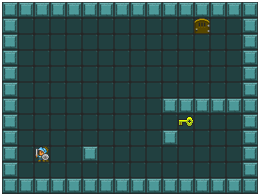

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=308856, Sun Oct 30 12:45:21 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.900000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 7.500000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.2
    3     42 7.500000000000000e+01 1.1e+00 4.49e-01  4e-01  5e-01 0:00.3
   38    532 5.800000000000000e+01 1.8e+00 6.06e-01  6e-01  6e-01 0:03.4
   77   1078 5.800000000000000e+01 2.2e+00 6.31e-01  6e-01  7e-01 0:06.9
   78   1092 5.800000000000000e+01 2.2e+00 6.16e-01  6e-01  7e-01 0:07.0
   79   1106 5.800000000000000e+01 2.2e+00 6.14e-01  6e-01  7e-01 0:07.1
   80   1120 5.800000000000000e+01 2.2e+00 6.32e-01  6e-01  7e-01 0:07.2
   81   1134 5.800000000000000e+01 2.2e+00 6.34e-01  6e-01  7e-01 0:07.3
   82   1148 5.800000000000000e+01 2.2e+00 6.31e-01  6e-01  7e-01 0:07.4
   83   1162 5.800000000000000e+01 2.2e+00 6.17e-01  6e-01  7e-01 0:07.4
   84   1176 5.800000000000000e+0

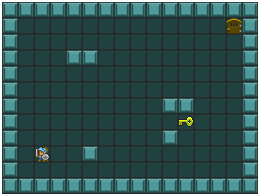

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=272999, Sun Oct 30 12:45:35 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.100000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 7.700000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.2
    3     42 7.700000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
   38    532 5.900000000000000e+01 2.0e+00 7.23e-01  7e-01  9e-01 0:03.3
   60    840 5.900000000000000e+01 2.2e+00 9.26e-01  9e-01  1e+00 0:05.2
   66    924 5.900000000000000e+01 2.3e+00 8.69e-01  8e-01  1e+00 0:05.8
   67    938 5.900000000000000e+01 2.3e+00 8.59e-01  8e-01  1e+00 0:05.9
   68    952 5.900000000000000e+01 2.3e+00 8.61e-01  8e-01  1e+00 0:06.0
   69    966 5.900000000000000e+01 2.3e+00 8.74e-01  8e-01  1e+00 0:06.1
   72   1008 5.900000000000000e+01 2.3e+00 9.13e-01  8e-01  1e+00 0:06.3
   73   1022 5.900000000000000e+01 2.3e+00 9.22e-01  8e-01  1e+00 0:06.4
   74   1036 5.900000000000000e+0

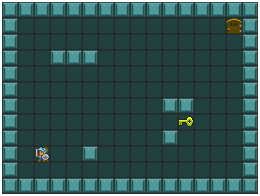

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=269454, Sun Oct 30 12:45:49 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.600000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 7.100000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 7.000000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
   37    518 6.100000000000000e+01 2.1e+00 7.43e-01  7e-01  9e-01 0:03.3
   40    560 6.100000000000000e+01 2.1e+00 7.21e-01  7e-01  9e-01 0:03.6
   41    574 6.100000000000000e+01 2.2e+00 7.21e-01  7e-01  9e-01 0:03.7
   52    728 6.100000000000000e+01 2.3e+00 6.40e-01  6e-01  8e-01 0:04.7
   53    742 6.100000000000000e+01 2.3e+00 6.57e-01  6e-01  8e-01 0:04.7
   54    756 6.100000000000000e+01 2.3e+00 6.62e-01  6e-01  8e-01 0:04.8
   57    798 6.100000000000000e+01 2.3e+00 6.51e-01  6e-01  8e-01 0:05.1
   58    812 6.100000000000000e+01 2.3e+00 6.52e-01  6e-01  8e-01 0:05.1
   59    826 6.100000000000000e+0

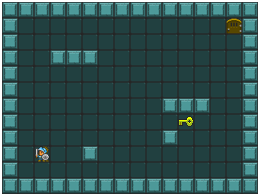

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=257486, Sun Oct 30 12:46:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.600000000000000e+01 1.0e+00 4.65e-01  5e-01  5e-01 0:00.1
    2     28 7.500000000000000e+01 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 7.400000000000000e+01 1.1e+00 4.36e-01  4e-01  4e-01 0:00.3
   35    490 6.400000000000000e+01 1.5e+00 4.41e-01  4e-01  5e-01 0:03.3
   36    504 6.400000000000000e+01 1.5e+00 4.55e-01  4e-01  5e-01 0:03.3
   37    518 6.400000000000000e+01 1.5e+00 4.64e-01  4e-01  5e-01 0:03.4
   40    560 6.400000000000000e+01 1.5e+00 4.57e-01  4e-01  5e-01 0:03.7
   41    574 6.400000000000000e+01 1.5e+00 4.54e-01  4e-01  5e-01 0:03.8
   44    616 6.400000000000000e+01 1.6e+00 4.27e-01  4e-01  5e-01 0:04.1
   48    672 6.400000000000000e+01 1.6e+00 4.07e-01  4e-01  4e-01 0:04.4
   49    686 6.400000000000000e+01 1.6e+00 4.08e-01  4e-01  4e-01 0:04.5
   50    700 6.400000000000000e+0

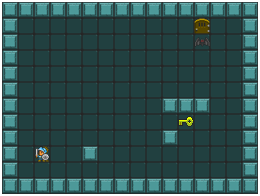

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=218349, Sun Oct 30 12:46:17 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.300000000000000e+01 1.0e+00 4.79e-01  5e-01  5e-01 0:00.1
    2     28 7.200000000000000e+01 1.1e+00 4.81e-01  5e-01  5e-01 0:00.2
    3     42 7.100000000000000e+01 1.1e+00 4.75e-01  5e-01  5e-01 0:00.3
   36    504 5.900000000000000e+01 1.8e+00 7.85e-01  7e-01  9e-01 0:03.4
   52    728 5.900000000000000e+01 2.0e+00 6.91e-01  6e-01  8e-01 0:04.8
   53    742 5.900000000000000e+01 2.0e+00 6.78e-01  6e-01  8e-01 0:04.9
   54    756 5.900000000000000e+01 2.0e+00 6.82e-01  6e-01  8e-01 0:05.0
   55    770 5.900000000000000e+01 2.0e+00 6.91e-01  6e-01  8e-01 0:05.1
   56    784 5.900000000000000e+01 2.0e+00 6.92e-01  6e-01  8e-01 0:05.2
   57    798 5.900000000000000e+01 2.0e+00 6.87e-01  6e-01  8e-01 0:05.3
   58    812 5.900000000000000e+01 2.0e+00 6.96e-01  6e-01  8e-01 0:05.4
   59    826 5.900000000000000e+0

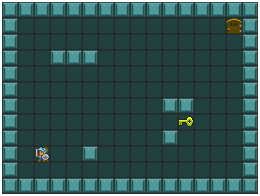

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=149468, Sun Oct 30 12:46:31 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.700000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 7.600000000000000e+01 1.1e+00 4.40e-01  4e-01  4e-01 0:00.2
    3     42 7.100000000000000e+01 1.1e+00 4.31e-01  4e-01  4e-01 0:00.3
   36    504 6.100000000000000e+01 1.6e+00 3.97e-01  4e-01  4e-01 0:03.3
   82   1148 5.900000000000000e+01 2.4e+00 4.79e-01  4e-01  5e-01 0:07.4
   83   1162 5.900000000000000e+01 2.4e+00 4.75e-01  4e-01  5e-01 0:07.5
   84   1176 5.900000000000000e+01 2.4e+00 4.77e-01  4e-01  5e-01 0:07.6
   85   1190 5.900000000000000e+01 2.4e+00 4.71e-01  4e-01  5e-01 0:07.7
   86   1204 5.900000000000000e+01 2.4e+00 4.63e-01  4e-01  5e-01 0:07.8
   91   1274 5.900000000000000e+01 2.4e+00 4.33e-01  4e-01  5e-01 0:08.2
   92   1288 5.900000000000000e+01 2.4e+00 4.31e-01  4e-01  5e-01 0:08.3
   93   1302 5.900000000000000e+0

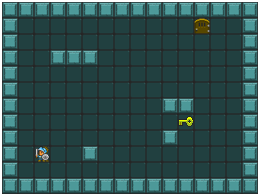

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=278331, Sun Oct 30 12:46:44 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.800000000000000e+01 1.0e+00 4.77e-01  5e-01  5e-01 0:00.1
    2     28 7.600000000000000e+01 1.1e+00 4.69e-01  5e-01  5e-01 0:00.2
    3     42 7.300000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.3
   37    518 6.100000000000000e+01 1.8e+00 4.91e-01  5e-01  6e-01 0:03.4
   62    868 6.100000000000000e+01 2.1e+00 3.79e-01  4e-01  4e-01 0:05.7
   63    882 6.100000000000000e+01 2.1e+00 3.75e-01  4e-01  4e-01 0:05.7
   64    896 6.100000000000000e+01 2.1e+00 3.68e-01  3e-01  4e-01 0:05.8
   65    910 6.100000000000000e+01 2.1e+00 3.62e-01  3e-01  4e-01 0:05.9
   66    924 6.100000000000000e+01 2.1e+00 3.55e-01  3e-01  4e-01 0:06.0
   71    994 6.100000000000000e+01 2.1e+00 3.33e-01  3e-01  4e-01 0:06.5
   78   1092 6.100000000000000e+01 2.2e+00 3.27e-01  3e-01  4e-01 0:07.2
   79   1106 6.100000000000000e+0

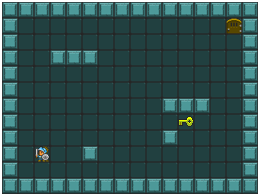

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=185467, Sun Oct 30 12:46:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.300000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 7.300000000000000e+01 1.1e+00 4.64e-01  5e-01  5e-01 0:00.2
    3     42 7.100000000000000e+01 1.1e+00 4.56e-01  5e-01  5e-01 0:00.3
   37    518 6.200000000000000e+01 1.6e+00 4.37e-01  4e-01  5e-01 0:03.4
   83   1162 5.900000000000000e+01 2.3e+00 7.79e-01  7e-01  9e-01 0:07.5
   97   1358 5.900000000000000e+01 2.4e+00 7.53e-01  7e-01  9e-01 0:08.7
  100   1400 5.900000000000000e+01 2.4e+00 7.44e-01  7e-01  9e-01 0:09.0
  103   1442 5.900000000000000e+01 2.4e+00 7.30e-01  7e-01  9e-01 0:09.3
  108   1512 5.900000000000000e+01 2.4e+00 6.77e-01  6e-01  8e-01 0:09.7
  114   1596 5.900000000000000e+01 2.4e+00 6.45e-01  6e-01  8e-01 0:10.3
  115   1610 5.900000000000000e+01 2.4e+00 6.36e-01  6e-01  8e-01 0:10.4
  116   1624 5.900000000000000e+0

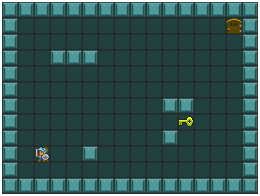

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=169619, Sun Oct 30 12:47:13 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.700000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 6.800000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.2
    3     42 6.500000000000000e+01 1.1e+00 4.44e-01  4e-01  4e-01 0:00.3
   36    504 5.900000000000000e+01 1.8e+00 6.66e-01  6e-01  8e-01 0:03.4
   69    966 5.800000000000000e+01 2.1e+00 5.53e-01  5e-01  6e-01 0:06.3
   70    980 5.800000000000000e+01 2.1e+00 5.67e-01  5e-01  6e-01 0:06.4
   71    994 5.800000000000000e+01 2.1e+00 5.71e-01  5e-01  6e-01 0:06.5
   72   1008 5.800000000000000e+01 2.1e+00 5.63e-01  5e-01  6e-01 0:06.6
   73   1022 5.800000000000000e+01 2.2e+00 5.40e-01  5e-01  6e-01 0:06.6
   81   1134 5.800000000000000e+01 2.2e+00 4.69e-01  4e-01  5e-01 0:07.4
   92   1288 5.800000000000000e+01 2.2e+00 3.85e-01  3e-01  4e-01 0:08.4
   93   1302 5.800000000000000e+0

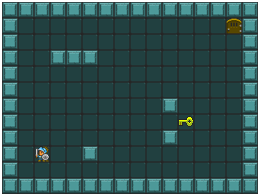

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=300483, Sun Oct 30 12:47:26 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.400000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 7.400000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 7.500000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
   37    518 6.100000000000000e+01 1.7e+00 5.74e-01  5e-01  6e-01 0:03.3
   38    532 6.100000000000000e+01 1.7e+00 5.67e-01  5e-01  6e-01 0:03.4
   39    546 6.100000000000000e+01 1.7e+00 5.68e-01  5e-01  6e-01 0:03.5
   40    560 6.100000000000000e+01 1.7e+00 5.53e-01  5e-01  6e-01 0:03.6
   41    574 6.100000000000000e+01 1.7e+00 5.46e-01  5e-01  6e-01 0:03.7
   42    588 6.100000000000000e+01 1.7e+00 5.44e-01  5e-01  6e-01 0:03.8
   43    602 6.100000000000000e+01 1.7e+00 5.36e-01  5e-01  6e-01 0:03.9
   44    616 6.100000000000000e+01 1.7e+00 5.27e-01  5e-01  6e-01 0:03.9
   45    630 6.100000000000000e+0

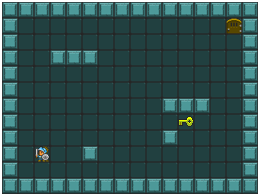

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=302999, Sun Oct 30 12:47:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.500000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 7.800000000000000e+01 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 7.200000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.3
   36    504 6.500000000000000e+01 1.7e+00 5.13e-01  5e-01  5e-01 0:03.3
   47    658 6.500000000000000e+01 1.8e+00 4.71e-01  5e-01  5e-01 0:04.3
   48    672 6.500000000000000e+01 1.8e+00 4.61e-01  4e-01  5e-01 0:04.4
   49    686 6.500000000000000e+01 1.8e+00 4.58e-01  4e-01  5e-01 0:04.5
   59    826 6.500000000000000e+01 1.9e+00 5.17e-01  5e-01  6e-01 0:05.4
   65    910 6.500000000000000e+01 1.9e+00 5.19e-01  5e-01  6e-01 0:05.9
   69    966 6.500000000000000e+01 1.9e+00 5.35e-01  5e-01  6e-01 0:06.3
   70    980 6.500000000000000e+01 1.9e+00 5.48e-01  5e-01  6e-01 0:06.4
  100   1400 6.400000000000000e+0

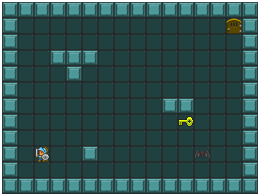

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=255537, Sun Oct 30 12:47:54 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.400000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 7.200000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
    3     42 6.800000000000000e+01 1.1e+00 4.36e-01  4e-01  4e-01 0:00.3
   38    532 6.600000000000000e+01 1.6e+00 4.29e-01  4e-01  5e-01 0:03.3
   41    574 6.600000000000000e+01 1.7e+00 4.29e-01  4e-01  5e-01 0:03.5
   42    588 6.600000000000000e+01 1.7e+00 4.30e-01  4e-01  5e-01 0:03.6
   43    602 6.600000000000000e+01 1.7e+00 4.37e-01  4e-01  5e-01 0:03.7
   53    742 6.600000000000000e+01 1.8e+00 5.19e-01  5e-01  6e-01 0:04.5
   70    980 6.600000000000000e+01 1.8e+00 3.69e-01  3e-01  4e-01 0:06.0
   73   1022 6.600000000000000e+01 1.8e+00 3.42e-01  3e-01  4e-01 0:06.2
   74   1036 6.600000000000000e+01 1.9e+00 3.33e-01  3e-01  4e-01 0:06.3
   75   1050 6.600000000000000e+0

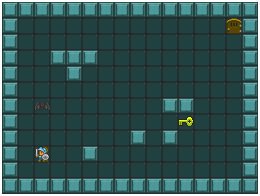

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=153791, Sun Oct 30 12:48:08 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.400000000000000e+01 1.0e+00 4.77e-01  5e-01  5e-01 0:00.1
    2     28 8.400000000000000e+01 1.1e+00 4.69e-01  5e-01  5e-01 0:00.2
    3     42 7.400000000000000e+01 1.1e+00 4.73e-01  5e-01  5e-01 0:00.3
   39    546 6.100000000000000e+01 1.7e+00 4.81e-01  4e-01  5e-01 0:03.3
   46    644 6.100000000000000e+01 1.7e+00 4.74e-01  4e-01  5e-01 0:03.9
   47    658 6.100000000000000e+01 1.7e+00 4.65e-01  4e-01  5e-01 0:04.0
   48    672 6.100000000000000e+01 1.8e+00 4.73e-01  4e-01  5e-01 0:04.1
   49    686 6.100000000000000e+01 1.8e+00 4.73e-01  4e-01  5e-01 0:04.2
   50    700 6.100000000000000e+01 1.8e+00 4.82e-01  4e-01  5e-01 0:04.3
   53    742 6.100000000000000e+01 1.8e+00 5.14e-01  5e-01  6e-01 0:04.6
   54    756 6.100000000000000e+01 1.8e+00 5.28e-01  5e-01  6e-01 0:04.7
   55    770 6.100000000000000e+0

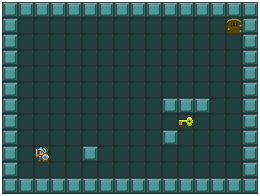

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=256182, Sun Oct 30 12:48:21 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.900000000000000e+01 1.0e+00 4.77e-01  5e-01  5e-01 0:00.1
    2     28 6.900000000000000e+01 1.1e+00 4.66e-01  5e-01  5e-01 0:00.2
    3     42 6.900000000000000e+01 1.1e+00 4.61e-01  5e-01  5e-01 0:00.3
   39    546 6.000000000000000e+01 1.8e+00 7.77e-01  7e-01  8e-01 0:03.3
   49    686 6.000000000000000e+01 1.8e+00 9.00e-01  9e-01  1e+00 0:04.2
   59    826 6.000000000000000e+01 1.9e+00 7.99e-01  8e-01  9e-01 0:05.1
   60    840 6.000000000000000e+01 1.9e+00 7.83e-01  7e-01  9e-01 0:05.2
   68    952 6.000000000000000e+01 1.9e+00 7.44e-01  7e-01  8e-01 0:05.9
   69    966 6.000000000000000e+01 1.9e+00 7.46e-01  7e-01  8e-01 0:06.0
   70    980 6.000000000000000e+01 1.9e+00 7.52e-01  7e-01  8e-01 0:06.1
   83   1162 5.900000000000000e+01 2.0e+00 6.92e-01  6e-01  8e-01 0:07.2
   84   1176 5.900000000000000e+0

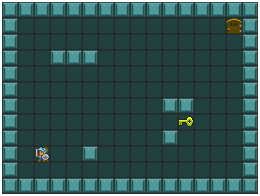

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=175268, Sun Oct 30 12:48:35 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.400000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 7.300000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.2
    3     42 7.400000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.3
   36    504 5.900000000000000e+01 1.8e+00 8.47e-01  8e-01  9e-01 0:03.3
   67    938 5.700000000000000e+01 2.3e+00 1.15e+00  1e+00  1e+00 0:06.2
   70    980 5.700000000000000e+01 2.3e+00 1.10e+00  1e+00  1e+00 0:06.5
   90   1260 5.700000000000000e+01 2.4e+00 1.12e+00  1e+00  1e+00 0:08.4
   91   1274 5.700000000000000e+01 2.4e+00 1.10e+00  1e+00  1e+00 0:08.5
   94   1316 5.700000000000000e+01 2.4e+00 1.06e+00  1e+00  1e+00 0:08.8
   95   1330 5.700000000000000e+01 2.4e+00 1.04e+00  1e+00  1e+00 0:08.9
   96   1344 5.700000000000000e+01 2.4e+00 1.02e+00  9e-01  1e+00 0:09.0
   97   1358 5.700000000000000e+0

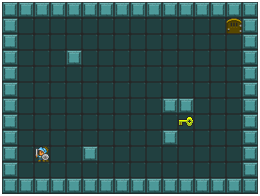

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=251460, Sun Oct 30 12:48:49 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.800000000000000e+01 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 7.800000000000000e+01 1.1e+00 4.51e-01  4e-01  5e-01 0:00.2
    3     42 7.600000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.3
   36    504 6.500000000000000e+01 1.8e+00 6.28e-01  6e-01  7e-01 0:03.3
   41    574 6.500000000000000e+01 1.8e+00 5.70e-01  5e-01  6e-01 0:03.7
   42    588 6.500000000000000e+01 1.9e+00 5.50e-01  5e-01  6e-01 0:03.8
   48    672 6.500000000000000e+01 1.9e+00 4.85e-01  5e-01  5e-01 0:04.3
   49    686 6.500000000000000e+01 1.9e+00 4.77e-01  5e-01  5e-01 0:04.3
   50    700 6.500000000000000e+01 1.9e+00 4.60e-01  4e-01  5e-01 0:04.4
   51    714 6.500000000000000e+01 1.9e+00 4.54e-01  4e-01  5e-01 0:04.5
   52    728 6.500000000000000e+01 1.9e+00 4.57e-01  4e-01  5e-01 0:04.6
   53    742 6.500000000000000e+0

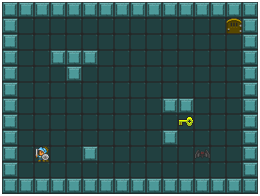

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=182082, Sun Oct 30 12:49:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.600000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 8.200000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 7.600000000000000e+01 1.1e+00 4.65e-01  5e-01  5e-01 0:00.3
   37    518 5.900000000000000e+01 1.8e+00 5.55e-01  5e-01  6e-01 0:03.4
   45    630 5.900000000000000e+01 1.9e+00 5.95e-01  6e-01  7e-01 0:04.1
   59    826 5.900000000000000e+01 2.0e+00 5.40e-01  5e-01  6e-01 0:05.4
   60    840 5.900000000000000e+01 2.0e+00 5.36e-01  5e-01  6e-01 0:05.5
   66    924 5.900000000000000e+01 2.0e+00 5.51e-01  5e-01  6e-01 0:06.1
   67    938 5.900000000000000e+01 2.0e+00 5.52e-01  5e-01  6e-01 0:06.2
   68    952 5.900000000000000e+01 2.1e+00 5.56e-01  5e-01  6e-01 0:06.3
   69    966 5.900000000000000e+01 2.1e+00 5.66e-01  5e-01  6e-01 0:06.4
   70    980 5.900000000000000e+0

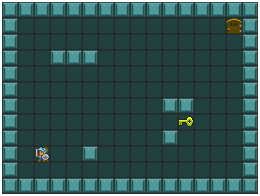

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=244915, Sun Oct 30 12:49:17 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.500000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 7.900000000000000e+01 1.1e+00 4.71e-01  5e-01  5e-01 0:00.3
    3     42 7.900000000000000e+01 1.1e+00 4.68e-01  5e-01  5e-01 0:00.4
   37    518 5.900000000000000e+01 1.7e+00 5.76e-01  6e-01  6e-01 0:03.4
   80   1120 5.700000000000000e+01 1.9e+00 4.44e-01  4e-01  5e-01 0:07.5
   87   1218 5.700000000000000e+01 1.9e+00 3.77e-01  4e-01  4e-01 0:08.1
   88   1232 5.700000000000000e+01 1.9e+00 3.75e-01  3e-01  4e-01 0:08.2
   89   1246 5.700000000000000e+01 1.9e+00 3.77e-01  3e-01  4e-01 0:08.3
   90   1260 5.700000000000000e+01 1.9e+00 3.76e-01  3e-01  4e-01 0:08.4
   91   1274 5.700000000000000e+01 1.9e+00 3.76e-01  3e-01  4e-01 0:08.5
   94   1316 5.700000000000000e+01 1.9e+00 3.86e-01  4e-01  4e-01 0:08.8
   97   1358 5.700000000000000e+0

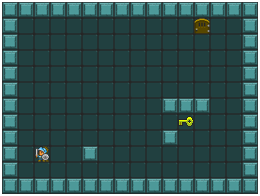

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=295607, Sun Oct 30 12:49:31 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.900000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 6.700000000000000e+01 1.1e+00 4.64e-01  5e-01  5e-01 0:00.2
    3     42 6.600000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.3
   36    504 6.000000000000000e+01 1.7e+00 5.04e-01  5e-01  5e-01 0:03.4
   66    924 5.900000000000000e+01 2.0e+00 6.00e-01  6e-01  7e-01 0:06.1
   67    938 5.900000000000000e+01 2.0e+00 5.95e-01  6e-01  7e-01 0:06.2
   68    952 5.900000000000000e+01 2.0e+00 5.98e-01  6e-01  7e-01 0:06.3
   69    966 5.900000000000000e+01 2.0e+00 5.93e-01  6e-01  7e-01 0:06.4
   70    980 5.900000000000000e+01 2.0e+00 5.89e-01  6e-01  6e-01 0:06.5
  100   1400 5.800000000000000e+01 2.1e+00 4.84e-01  4e-01  5e-01 0:09.3
  104   1456 5.800000000000000e+01 2.1e+00 4.59e-01  4e-01  5e-01 0:09.7
  105   1470 5.800000000000000e+0

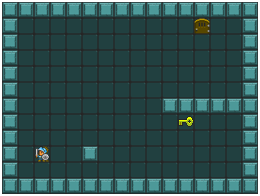

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=241648, Sun Oct 30 12:49:46 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.500000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 7.100000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.2
    3     42 7.200000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.3
   36    504 5.700000000000000e+01 1.9e+00 8.90e-01  8e-01  1e+00 0:03.3
   81   1134 5.700000000000000e+01 2.3e+00 9.77e-01  9e-01  1e+00 0:07.3
   82   1148 5.700000000000000e+01 2.3e+00 9.57e-01  9e-01  1e+00 0:07.4
   83   1162 5.700000000000000e+01 2.3e+00 9.48e-01  9e-01  1e+00 0:07.5
   84   1176 5.700000000000000e+01 2.3e+00 9.43e-01  9e-01  1e+00 0:07.6
   85   1190 5.700000000000000e+01 2.3e+00 9.47e-01  9e-01  1e+00 0:07.7
   86   1204 5.700000000000000e+01 2.3e+00 9.32e-01  9e-01  1e+00 0:07.8
   87   1218 5.700000000000000e+01 2.3e+00 9.38e-01  9e-01  1e+00 0:07.9
   88   1232 5.700000000000000e+0

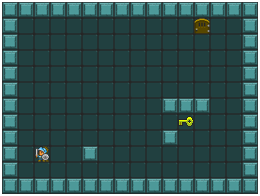

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=270032, Sun Oct 30 12:49:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.900000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 6.800000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
    3     42 6.900000000000000e+01 1.1e+00 4.45e-01  4e-01  4e-01 0:00.3
   36    504 6.300000000000000e+01 1.8e+00 5.72e-01  5e-01  7e-01 0:03.1
   37    518 6.300000000000000e+01 1.8e+00 5.72e-01  5e-01  7e-01 0:03.2
   38    532 6.300000000000000e+01 1.8e+00 5.69e-01  5e-01  7e-01 0:03.3
   42    588 6.300000000000000e+01 1.9e+00 5.50e-01  5e-01  7e-01 0:03.6
   45    630 6.300000000000000e+01 2.0e+00 5.69e-01  5e-01  7e-01 0:03.9
   46    644 6.300000000000000e+01 2.0e+00 5.65e-01  5e-01  7e-01 0:04.0
   47    658 6.300000000000000e+01 2.0e+00 5.54e-01  5e-01  7e-01 0:04.1
   48    672 6.300000000000000e+01 2.0e+00 5.41e-01  5e-01  6e-01 0:04.2
   49    686 6.300000000000000e+0

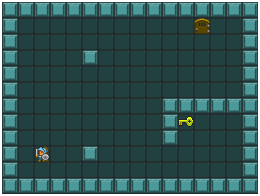

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=276184, Sun Oct 30 12:50:13 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.400000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 6.400000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 6.400000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.3
   35    490 6.000000000000000e+01 1.8e+00 5.67e-01  5e-01  6e-01 0:03.4
   55    770 6.000000000000000e+01 2.0e+00 4.98e-01  5e-01  6e-01 0:05.2
   56    784 6.000000000000000e+01 2.0e+00 5.03e-01  5e-01  6e-01 0:05.3
   57    798 6.000000000000000e+01 2.1e+00 5.06e-01  5e-01  6e-01 0:05.4
   58    812 6.000000000000000e+01 2.1e+00 5.15e-01  5e-01  6e-01 0:05.5
   59    826 6.000000000000000e+01 2.1e+00 5.21e-01  5e-01  6e-01 0:05.6
   60    840 6.000000000000000e+01 2.1e+00 5.20e-01  5e-01  6e-01 0:05.7
   65    910 6.000000000000000e+01 2.1e+00 4.92e-01  5e-01  6e-01 0:06.1
   66    924 6.000000000000000e+0

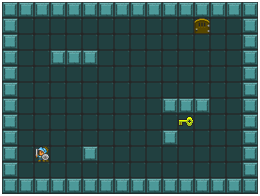

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=228149, Sun Oct 30 12:50:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.400000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 7.500000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 7.400000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
   37    518 6.000000000000000e+01 1.7e+00 8.42e-01  8e-01  1e+00 0:03.3
   70    980 6.000000000000000e+01 2.3e+00 1.38e+00  1e+00  2e+00 0:06.3
   77   1078 6.000000000000000e+01 2.4e+00 1.34e+00  1e+00  2e+00 0:07.0
   80   1120 6.000000000000000e+01 2.4e+00 1.33e+00  1e+00  2e+00 0:07.2
   81   1134 6.000000000000000e+01 2.4e+00 1.31e+00  1e+00  2e+00 0:07.3
   94   1316 6.000000000000000e+01 2.5e+00 1.09e+00  1e+00  1e+00 0:08.5
  100   1400 6.000000000000000e+01 2.5e+00 9.18e-01  8e-01  1e+00 0:09.1
  105   1470 6.000000000000000e+01 2.5e+00 8.46e-01  8e-01  1e+00 0:09.5
  106   1484 6.000000000000000e+0

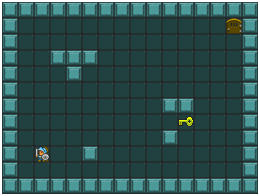

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=261414, Sun Oct 30 12:50:41 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.800000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 7.500000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.2
    3     42 6.800000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.3
   37    518 5.900000000000000e+01 1.8e+00 6.42e-01  6e-01  7e-01 0:03.3
   53    742 5.900000000000000e+01 1.9e+00 5.16e-01  5e-01  6e-01 0:04.7
   54    756 5.900000000000000e+01 2.0e+00 5.03e-01  5e-01  5e-01 0:04.8
   55    770 5.900000000000000e+01 2.0e+00 5.01e-01  5e-01  6e-01 0:04.9
   56    784 5.900000000000000e+01 2.0e+00 4.93e-01  5e-01  5e-01 0:04.9
   57    798 5.900000000000000e+01 2.0e+00 4.80e-01  4e-01  5e-01 0:05.0
   58    812 5.900000000000000e+01 2.0e+00 4.74e-01  4e-01  5e-01 0:05.1
   59    826 5.900000000000000e+01 2.0e+00 4.80e-01  4e-01  5e-01 0:05.2
   60    840 5.900000000000000e+0

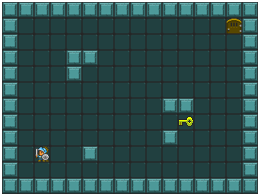

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=154735, Sun Oct 30 12:50:55 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.400000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 6.800000000000000e+01 1.1e+00 4.60e-01  5e-01  5e-01 0:00.2
    3     42 6.800000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.3
   36    504 5.900000000000000e+01 1.8e+00 7.82e-01  7e-01  9e-01 0:03.3
   47    658 5.900000000000000e+01 2.0e+00 9.66e-01  9e-01  1e+00 0:04.3
   60    840 5.900000000000000e+01 2.1e+00 8.94e-01  8e-01  1e+00 0:05.3
   69    966 5.900000000000000e+01 2.2e+00 7.98e-01  7e-01  9e-01 0:06.2
   72   1008 5.900000000000000e+01 2.2e+00 7.38e-01  7e-01  9e-01 0:06.5
   73   1022 5.900000000000000e+01 2.2e+00 7.28e-01  7e-01  9e-01 0:06.5
   89   1246 5.900000000000000e+01 2.3e+00 6.76e-01  6e-01  8e-01 0:08.0
   92   1288 5.900000000000000e+01 2.3e+00 6.59e-01  6e-01  8e-01 0:08.3
   93   1302 5.900000000000000e+0

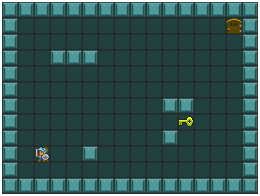

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=190852, Sun Oct 30 12:51:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.400000000000000e+01 1.0e+00 4.79e-01  5e-01  5e-01 0:00.1
    2     28 8.000000000000000e+01 1.1e+00 4.68e-01  5e-01  5e-01 0:00.2
    3     42 7.800000000000000e+01 1.1e+00 4.67e-01  5e-01  5e-01 0:00.3
   38    532 6.000000000000000e+01 2.1e+00 8.62e-01  8e-01  1e+00 0:03.4
   39    546 6.000000000000000e+01 2.1e+00 8.63e-01  8e-01  1e+00 0:03.4
   70    980 6.000000000000000e+01 2.6e+00 7.30e-01  7e-01  9e-01 0:06.3
   76   1064 6.000000000000000e+01 2.6e+00 7.22e-01  7e-01  9e-01 0:06.7
   77   1078 6.000000000000000e+01 2.6e+00 7.24e-01  7e-01  9e-01 0:06.8
   78   1092 6.000000000000000e+01 2.6e+00 7.36e-01  7e-01  9e-01 0:06.9
   79   1106 6.000000000000000e+01 2.6e+00 7.46e-01  7e-01  9e-01 0:07.0
   80   1120 6.000000000000000e+01 2.6e+00 7.50e-01  7e-01  9e-01 0:07.1
   81   1134 6.000000000000000e+0

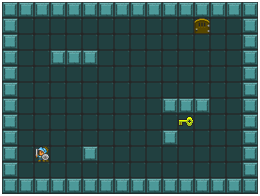

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=252074, Sun Oct 30 12:51:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.100000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 7.200000000000000e+01 1.1e+00 4.69e-01  5e-01  5e-01 0:00.2
    3     42 7.300000000000000e+01 1.1e+00 4.69e-01  5e-01  5e-01 0:00.3
   38    532 5.900000000000000e+01 1.5e+00 4.52e-01  4e-01  5e-01 0:03.3
   83   1162 5.800000000000000e+01 1.8e+00 4.44e-01  4e-01  5e-01 0:07.4
   86   1204 5.800000000000000e+01 1.8e+00 4.72e-01  4e-01  5e-01 0:07.7
  100   1400 5.800000000000000e+01 1.8e+00 4.01e-01  4e-01  4e-01 0:09.0
  101   1414 5.800000000000000e+01 1.8e+00 4.00e-01  4e-01  4e-01 0:09.1
  102   1428 5.800000000000000e+01 1.8e+00 4.00e-01  4e-01  4e-01 0:09.2
  124   1736 5.700000000000000e+01 2.0e+00 3.66e-01  3e-01  4e-01 0:11.2
  125   1750 5.700000000000000e+01 2.0e+00 3.64e-01  3e-01  4e-01 0:11.3
  126   1764 5.700000000000000e+0

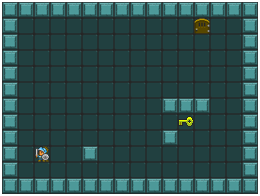

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=275962, Sun Oct 30 12:51:36 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.700000000000000e+01 1.0e+00 4.80e-01  5e-01  5e-01 0:00.1
    2     28 7.300000000000000e+01 1.1e+00 4.67e-01  5e-01  5e-01 0:00.2
    3     42 7.400000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.3
   29    406 6.600000000000000e+01 1.6e+00 4.68e-01  4e-01  5e-01 0:02.7
   32    448 6.600000000000000e+01 1.7e+00 4.76e-01  5e-01  5e-01 0:03.0
   38    532 6.600000000000000e+01 1.7e+00 4.51e-01  4e-01  5e-01 0:03.5
   44    616 6.600000000000000e+01 1.8e+00 4.43e-01  4e-01  5e-01 0:04.0
   45    630 6.600000000000000e+01 1.8e+00 4.43e-01  4e-01  5e-01 0:04.1
   46    644 6.600000000000000e+01 1.8e+00 4.38e-01  4e-01  5e-01 0:04.2
   47    658 6.600000000000000e+01 1.8e+00 4.37e-01  4e-01  5e-01 0:04.3
   50    700 6.600000000000000e+01 1.8e+00 4.42e-01  4e-01  5e-01 0:04.6
   62    868 6.600000000000000e+0

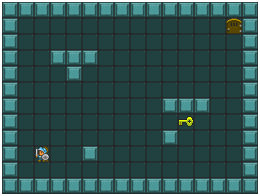

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=257799, Sun Oct 30 12:51:50 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.500000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 7.500000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.2
    3     42 7.400000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.3
   37    518 5.900000000000000e+01 2.0e+00 8.12e-01  8e-01  9e-01 0:03.3
   50    700 5.900000000000000e+01 2.1e+00 8.16e-01  8e-01  9e-01 0:04.5
   51    714 5.900000000000000e+01 2.1e+00 8.09e-01  8e-01  9e-01 0:04.6
   59    826 5.900000000000000e+01 2.1e+00 6.75e-01  6e-01  8e-01 0:05.2
   60    840 5.900000000000000e+01 2.1e+00 6.60e-01  6e-01  8e-01 0:05.3
   61    854 5.900000000000000e+01 2.1e+00 6.58e-01  6e-01  8e-01 0:05.4
   64    896 5.900000000000000e+01 2.1e+00 6.52e-01  6e-01  7e-01 0:05.7
   65    910 5.900000000000000e+01 2.1e+00 6.25e-01  6e-01  7e-01 0:05.8
   68    952 5.900000000000000e+0

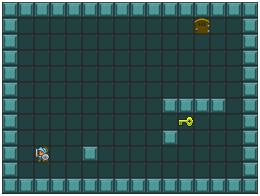

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=176375, Sun Oct 30 12:52:04 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.500000000000000e+01 1.0e+00 4.64e-01  5e-01  5e-01 0:00.1
    2     28 6.500000000000000e+01 1.1e+00 4.43e-01  4e-01  4e-01 0:00.2
    3     42 6.400000000000000e+01 1.1e+00 4.35e-01  4e-01  4e-01 0:00.3
   38    532 5.800000000000000e+01 1.7e+00 4.73e-01  5e-01  5e-01 0:03.4
   43    602 5.800000000000000e+01 1.7e+00 4.63e-01  4e-01  5e-01 0:03.9
   49    686 5.700000000000000e+01 1.8e+00 4.60e-01  4e-01  5e-01 0:04.4
   50    700 5.700000000000000e+01 1.8e+00 4.56e-01  4e-01  5e-01 0:04.5
   51    714 5.700000000000000e+01 1.8e+00 4.52e-01  4e-01  5e-01 0:04.6
   52    728 5.700000000000000e+01 1.8e+00 4.47e-01  4e-01  5e-01 0:04.6
   67    938 5.700000000000000e+01 1.9e+00 4.16e-01  4e-01  4e-01 0:06.0
   68    952 5.700000000000000e+01 1.9e+00 4.05e-01  4e-01  4e-01 0:06.1
   69    966 5.700000000000000e+0

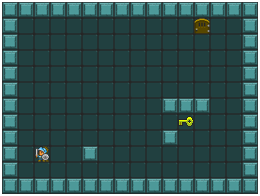

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=318186, Sun Oct 30 12:52:17 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.600000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 7.500000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 7.400000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.3
   36    504 6.700000000000000e+01 1.8e+00 5.85e-01  6e-01  6e-01 0:03.4
   39    546 6.700000000000000e+01 1.8e+00 5.54e-01  5e-01  6e-01 0:03.7
   73   1022 6.600000000000000e+01 1.9e+00 4.22e-01  4e-01  5e-01 0:06.6
   74   1036 6.600000000000000e+01 1.9e+00 4.31e-01  4e-01  5e-01 0:06.7
   75   1050 6.600000000000000e+01 1.9e+00 4.37e-01  4e-01  5e-01 0:06.8
   82   1148 6.600000000000000e+01 2.0e+00 4.34e-01  4e-01  5e-01 0:07.4
   83   1162 6.600000000000000e+01 2.0e+00 4.31e-01  4e-01  5e-01 0:07.5
   84   1176 6.600000000000000e+01 2.0e+00 4.36e-01  4e-01  5e-01 0:07.6
   85   1190 6.600000000000000e+0

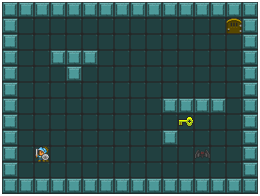

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=241988, Sun Oct 30 12:52:31 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.400000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 7.600000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
    3     42 7.400000000000000e+01 1.1e+00 4.29e-01  4e-01  4e-01 0:00.4
   37    518 6.000000000000000e+01 2.0e+00 6.99e-01  7e-01  8e-01 0:03.5
   61    854 5.800000000000000e+01 2.3e+00 1.05e+00  1e+00  1e+00 0:05.6
   65    910 5.800000000000000e+01 2.4e+00 1.04e+00  1e+00  1e+00 0:05.9
   66    924 5.800000000000000e+01 2.4e+00 1.06e+00  1e+00  1e+00 0:06.1
   72   1008 5.800000000000000e+01 2.7e+00 1.12e+00  1e+00  1e+00 0:06.5
   78   1092 5.800000000000000e+01 2.7e+00 9.87e-01  9e-01  1e+00 0:07.1
   79   1106 5.800000000000000e+01 2.7e+00 9.69e-01  9e-01  1e+00 0:07.2
   80   1120 5.800000000000000e+01 2.7e+00 9.61e-01  9e-01  1e+00 0:07.3
   81   1134 5.800000000000000e+0

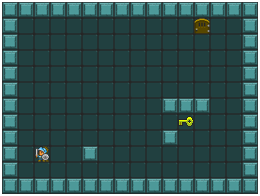

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=261383, Sun Oct 30 12:52:45 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.200000000000000e+01 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 8.400000000000000e+01 1.1e+00 4.46e-01  4e-01  5e-01 0:00.2
    3     42 7.900000000000000e+01 1.1e+00 4.34e-01  4e-01  4e-01 0:00.3
   36    504 6.100000000000000e+01 1.9e+00 6.91e-01  7e-01  8e-01 0:03.3
   76   1064 5.900000000000000e+01 2.1e+00 6.88e-01  6e-01  8e-01 0:06.9
   77   1078 5.900000000000000e+01 2.1e+00 6.93e-01  6e-01  8e-01 0:07.0
   88   1232 5.900000000000000e+01 2.2e+00 6.19e-01  6e-01  7e-01 0:07.9
   89   1246 5.900000000000000e+01 2.2e+00 6.23e-01  6e-01  7e-01 0:08.0
   94   1316 5.900000000000000e+01 2.2e+00 5.56e-01  5e-01  6e-01 0:08.4
   95   1330 5.900000000000000e+01 2.2e+00 5.51e-01  5e-01  6e-01 0:08.6
   96   1344 5.900000000000000e+01 2.2e+00 5.49e-01  5e-01  6e-01 0:08.7
   97   1358 5.900000000000000e+0

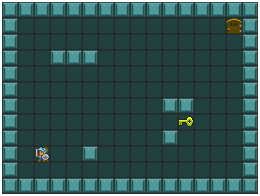

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=272852, Sun Oct 30 12:52:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.000000000000000e+01 1.0e+00 4.62e-01  5e-01  5e-01 0:00.1
    2     28 7.700000000000000e+01 1.1e+00 4.39e-01  4e-01  4e-01 0:00.2
    3     42 7.600000000000000e+01 1.1e+00 4.24e-01  4e-01  4e-01 0:00.3
   36    504 6.200000000000000e+01 2.0e+00 6.00e-01  6e-01  7e-01 0:03.3
   80   1120 6.000000000000000e+01 2.3e+00 4.39e-01  4e-01  5e-01 0:07.4
   84   1176 6.000000000000000e+01 2.3e+00 4.50e-01  4e-01  5e-01 0:07.7
   87   1218 6.000000000000000e+01 2.3e+00 4.29e-01  4e-01  5e-01 0:08.0
   88   1232 6.000000000000000e+01 2.3e+00 4.31e-01  4e-01  5e-01 0:08.1
   91   1274 6.000000000000000e+01 2.3e+00 4.41e-01  4e-01  5e-01 0:08.3
   95   1330 6.000000000000000e+01 2.4e+00 4.36e-01  4e-01  5e-01 0:08.7
   98   1372 6.000000000000000e+01 2.4e+00 4.27e-01  4e-01  5e-01 0:09.0
   99   1386 6.000000000000000e+0

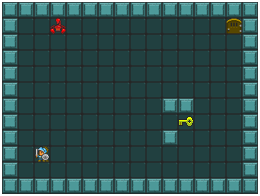

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=268085, Sun Oct 30 12:53:13 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.700000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 6.500000000000000e+01 1.1e+00 4.60e-01  5e-01  5e-01 0:00.2
    3     42 6.400000000000000e+01 1.1e+00 4.54e-01  5e-01  5e-01 0:00.3
   37    518 6.000000000000000e+01 1.8e+00 6.98e-01  7e-01  8e-01 0:03.4
   60    840 6.000000000000000e+01 2.1e+00 6.24e-01  6e-01  7e-01 0:05.7
   61    854 6.000000000000000e+01 2.1e+00 6.38e-01  6e-01  7e-01 0:05.8
   64    896 6.000000000000000e+01 2.2e+00 6.67e-01  6e-01  8e-01 0:06.1
   65    910 6.000000000000000e+01 2.2e+00 6.85e-01  6e-01  8e-01 0:06.1
   94   1316 5.700000000000000e+01 2.3e+00 8.63e-01  8e-01  1e+00 0:08.8
   97   1358 5.700000000000000e+01 2.3e+00 8.70e-01  8e-01  1e+00 0:09.0
  100   1400 5.700000000000000e+01 2.4e+00 8.27e-01  8e-01  1e+00 0:09.3
  104   1456 5.700000000000000e+0

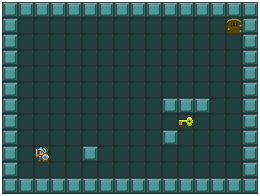

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=310991, Sun Oct 30 12:53:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.000000000000000e+01 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 7.600000000000000e+01 1.1e+00 4.47e-01  4e-01  4e-01 0:00.2
    3     42 7.800000000000000e+01 1.1e+00 4.34e-01  4e-01  4e-01 0:00.3
   31    434 6.500000000000000e+01 1.5e+00 4.16e-01  4e-01  4e-01 0:02.8
   32    448 6.500000000000000e+01 1.6e+00 4.06e-01  4e-01  4e-01 0:02.9
   40    560 6.500000000000000e+01 1.6e+00 3.89e-01  4e-01  4e-01 0:03.7
   41    574 6.500000000000000e+01 1.7e+00 3.94e-01  4e-01  4e-01 0:03.8
   63    882 6.000000000000000e+01 1.8e+00 4.54e-01  4e-01  5e-01 0:05.8
   66    924 6.000000000000000e+01 1.8e+00 4.52e-01  4e-01  5e-01 0:06.1
   69    966 6.000000000000000e+01 1.8e+00 4.41e-01  4e-01  5e-01 0:06.3
   70    980 6.000000000000000e+01 1.8e+00 4.35e-01  4e-01  5e-01 0:06.4
   71    994 6.000000000000000e+0

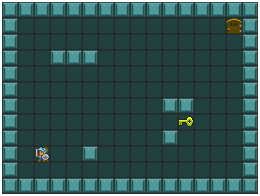

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=311251, Sun Oct 30 12:53:41 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.500000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 7.400000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 6.900000000000000e+01 1.1e+00 4.40e-01  4e-01  4e-01 0:00.3
   36    504 6.500000000000000e+01 1.7e+00 5.99e-01  6e-01  7e-01 0:03.3
   43    602 6.500000000000000e+01 1.8e+00 5.48e-01  5e-01  6e-01 0:03.9
   44    616 6.500000000000000e+01 1.8e+00 5.58e-01  5e-01  6e-01 0:04.0
   45    630 6.500000000000000e+01 1.8e+00 5.60e-01  5e-01  6e-01 0:04.0
   46    644 6.500000000000000e+01 1.9e+00 5.60e-01  5e-01  6e-01 0:04.1
   47    658 6.500000000000000e+01 1.9e+00 5.63e-01  5e-01  6e-01 0:04.2
   50    700 6.500000000000000e+01 1.9e+00 5.13e-01  5e-01  6e-01 0:04.4
   51    714 6.500000000000000e+01 1.9e+00 5.00e-01  5e-01  6e-01 0:04.5
   52    728 6.500000000000000e+0

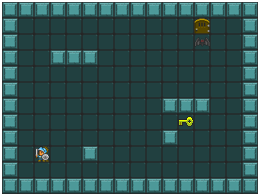

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=248679, Sun Oct 30 12:53:55 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.700000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 7.500000000000000e+01 1.1e+00 4.67e-01  5e-01  5e-01 0:00.2
    3     42 7.400000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.3
   36    504 5.900000000000000e+01 1.9e+00 1.14e+00  1e+00  1e+00 0:03.3
   62    868 5.900000000000000e+01 2.4e+00 1.49e+00  1e+00  2e+00 0:05.6
   63    882 5.900000000000000e+01 2.4e+00 1.49e+00  1e+00  2e+00 0:05.7
   66    924 5.900000000000000e+01 2.4e+00 1.53e+00  1e+00  2e+00 0:06.0
   70    980 5.900000000000000e+01 2.6e+00 1.61e+00  2e+00  2e+00 0:06.4
   71    994 5.900000000000000e+01 2.6e+00 1.59e+00  2e+00  2e+00 0:06.5
   72   1008 5.900000000000000e+01 2.6e+00 1.57e+00  1e+00  2e+00 0:06.5
   73   1022 5.900000000000000e+01 2.6e+00 1.52e+00  1e+00  2e+00 0:06.6
   74   1036 5.900000000000000e+0

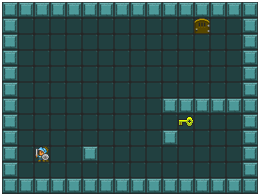

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=302998, Sun Oct 30 12:54:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.000000000000000e+01 1.0e+00 4.62e-01  5e-01  5e-01 0:00.1
    2     28 7.900000000000000e+01 1.1e+00 4.43e-01  4e-01  4e-01 0:00.2
    3     42 7.800000000000000e+01 1.1e+00 4.39e-01  4e-01  4e-01 0:00.3
   36    504 6.500000000000000e+01 1.7e+00 5.10e-01  5e-01  6e-01 0:03.3
   49    686 6.500000000000000e+01 1.8e+00 5.16e-01  5e-01  5e-01 0:04.5
   50    700 6.500000000000000e+01 1.8e+00 5.17e-01  5e-01  6e-01 0:04.6
   51    714 6.500000000000000e+01 1.8e+00 5.14e-01  5e-01  5e-01 0:04.7
   52    728 6.500000000000000e+01 1.8e+00 5.11e-01  5e-01  5e-01 0:04.8
   53    742 6.500000000000000e+01 1.8e+00 5.01e-01  5e-01  5e-01 0:04.9
   54    756 6.500000000000000e+01 1.8e+00 4.75e-01  4e-01  5e-01 0:04.9
   55    770 6.500000000000000e+01 1.8e+00 4.57e-01  4e-01  5e-01 0:05.0
   58    812 6.500000000000000e+0

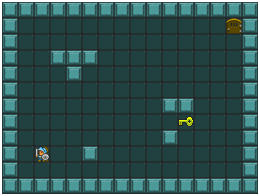

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=232661, Sun Oct 30 12:54:23 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.400000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 8.200000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.2
    3     42 7.800000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
   36    504 6.000000000000000e+01 2.0e+00 6.65e-01  6e-01  7e-01 0:03.2
   37    518 6.000000000000000e+01 2.0e+00 6.63e-01  6e-01  7e-01 0:03.3
   40    560 6.000000000000000e+01 2.1e+00 6.43e-01  6e-01  7e-01 0:03.5
   41    574 6.000000000000000e+01 2.1e+00 6.46e-01  6e-01  7e-01 0:03.6
   42    588 6.000000000000000e+01 2.1e+00 6.47e-01  6e-01  7e-01 0:03.7
   47    658 6.000000000000000e+01 2.2e+00 5.77e-01  5e-01  7e-01 0:04.2
   48    672 6.000000000000000e+01 2.2e+00 5.79e-01  5e-01  7e-01 0:04.2
   49    686 6.000000000000000e+01 2.2e+00 5.68e-01  5e-01  6e-01 0:04.3
   50    700 6.000000000000000e+0

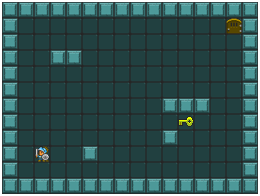

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=230232, Sun Oct 30 12:54:37 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.400000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 7.400000000000000e+01 1.1e+00 4.70e-01  5e-01  5e-01 0:00.2
    3     42 7.300000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.3
   20    280 6.700000000000000e+01 1.5e+00 5.16e-01  5e-01  5e-01 0:01.7
   34    476 6.700000000000000e+01 1.7e+00 4.68e-01  4e-01  5e-01 0:03.0
   35    490 6.700000000000000e+01 1.7e+00 4.69e-01  4e-01  5e-01 0:03.1
   38    532 6.700000000000000e+01 1.7e+00 4.95e-01  5e-01  5e-01 0:03.4
   39    546 6.700000000000000e+01 1.7e+00 4.98e-01  5e-01  5e-01 0:03.4
   40    560 6.700000000000000e+01 1.7e+00 4.90e-01  5e-01  5e-01 0:03.5
   41    574 6.700000000000000e+01 1.7e+00 4.72e-01  4e-01  5e-01 0:03.6
   42    588 6.700000000000000e+01 1.7e+00 4.46e-01  4e-01  5e-01 0:03.7
   43    602 6.700000000000000e+0

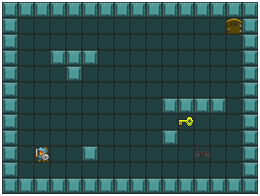

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=256680, Sun Oct 30 12:54:51 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.900000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 8.400000000000000e+01 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 7.600000000000000e+01 1.1e+00 4.41e-01  4e-01  4e-01 0:00.3
   37    518 6.700000000000000e+01 2.1e+00 1.20e+00  1e+00  2e+00 0:03.3
   83   1162 6.300000000000000e+01 2.6e+00 1.57e+00  1e+00  2e+00 0:07.4
  100   1400 6.200000000000000e+01 2.6e+00 1.76e+00  2e+00  2e+00 0:08.9
  111   1554 6.200000000000000e+01 2.5e+00 1.79e+00  2e+00  2e+00 0:09.9
  116   1624 6.200000000000000e+01 2.6e+00 1.71e+00  2e+00  2e+00 0:10.3
  123   1722 6.200000000000000e+01 2.5e+00 1.46e+00  1e+00  2e+00 0:10.9
  124   1736 6.200000000000000e+01 2.6e+00 1.42e+00  1e+00  2e+00 0:11.0
  125   1750 6.200000000000000e+01 2.6e+00 1.39e+00  1e+00  2e+00 0:11.1
  126   1764 6.200000000000000e+0

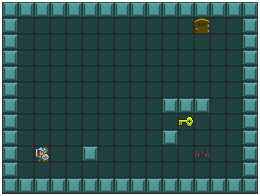

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=156420, Sun Oct 30 12:55:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.900000000000000e+01 1.0e+00 4.80e-01  5e-01  5e-01 0:00.1
    2     28 7.900000000000000e+01 1.1e+00 4.66e-01  5e-01  5e-01 0:00.2
    3     42 7.800000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.3
   37    518 6.600000000000000e+01 1.6e+00 4.47e-01  4e-01  5e-01 0:03.3
   54    756 6.400000000000000e+01 1.8e+00 3.66e-01  3e-01  4e-01 0:04.9
   82   1148 6.400000000000000e+01 1.9e+00 3.45e-01  3e-01  4e-01 0:07.5
   89   1246 6.400000000000000e+01 1.9e+00 2.95e-01  3e-01  3e-01 0:08.1
   90   1260 6.400000000000000e+01 1.9e+00 2.84e-01  3e-01  3e-01 0:08.3
   91   1274 6.400000000000000e+01 1.9e+00 2.75e-01  2e-01  3e-01 0:08.4
   92   1288 6.400000000000000e+01 1.9e+00 2.67e-01  2e-01  3e-01 0:08.5
   93   1302 6.400000000000000e+01 1.9e+00 2.63e-01  2e-01  3e-01 0:08.5
   96   1344 6.400000000000000e+0

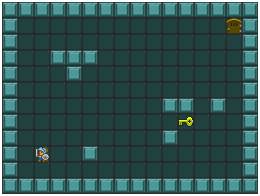

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=236611, Sun Oct 30 12:55:19 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.500000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 7.900000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 8.000000000000000e+01 1.1e+00 4.45e-01  4e-01  5e-01 0:00.3
   36    504 6.000000000000000e+01 1.9e+00 7.60e-01  7e-01  9e-01 0:03.4
   48    672 6.000000000000000e+01 2.1e+00 7.00e-01  7e-01  8e-01 0:04.4
   56    784 6.000000000000000e+01 2.1e+00 6.46e-01  6e-01  7e-01 0:05.1
   57    798 6.000000000000000e+01 2.1e+00 6.42e-01  6e-01  7e-01 0:05.1
   58    812 6.000000000000000e+01 2.1e+00 6.20e-01  6e-01  7e-01 0:05.2
   59    826 6.000000000000000e+01 2.1e+00 6.06e-01  6e-01  7e-01 0:05.3
   60    840 6.000000000000000e+01 2.1e+00 6.12e-01  6e-01  7e-01 0:05.4
   63    882 6.000000000000000e+01 2.1e+00 6.26e-01  6e-01  7e-01 0:05.7
   64    896 6.000000000000000e+0

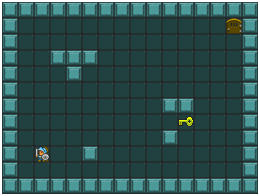

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=301593, Sun Oct 30 12:55:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.900000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 7.400000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 7.300000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.3
   36    504 6.300000000000000e+01 1.8e+00 5.49e-01  5e-01  6e-01 0:03.4
   69    966 6.200000000000000e+01 2.2e+00 7.37e-01  7e-01  8e-01 0:06.4
   82   1148 5.700000000000000e+01 2.3e+00 6.55e-01  6e-01  7e-01 0:07.6
   86   1204 5.700000000000000e+01 2.3e+00 6.01e-01  6e-01  7e-01 0:07.9
   87   1218 5.700000000000000e+01 2.3e+00 5.79e-01  5e-01  6e-01 0:08.0
   88   1232 5.700000000000000e+01 2.3e+00 5.73e-01  5e-01  6e-01 0:08.1
   89   1246 5.700000000000000e+01 2.3e+00 5.72e-01  5e-01  6e-01 0:08.2
   93   1302 5.700000000000000e+01 2.3e+00 5.41e-01  5e-01  6e-01 0:08.5
   94   1316 5.700000000000000e+0

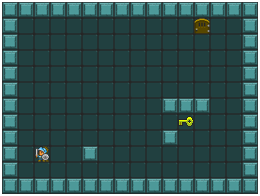

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=223852, Sun Oct 30 12:55:47 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.800000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 7.300000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 6.800000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.3
   38    532 5.900000000000000e+01 1.8e+00 7.46e-01  7e-01  8e-01 0:03.4
   67    938 5.800000000000000e+01 2.0e+00 5.04e-01  5e-01  6e-01 0:06.1
   92   1288 5.800000000000000e+01 2.1e+00 6.47e-01  6e-01  7e-01 0:08.4
   93   1302 5.800000000000000e+01 2.1e+00 6.48e-01  6e-01  7e-01 0:08.5
  100   1400 5.800000000000000e+01 2.1e+00 6.77e-01  6e-01  8e-01 0:09.2
  101   1414 5.800000000000000e+01 2.1e+00 6.75e-01  6e-01  8e-01 0:09.3
  102   1428 5.800000000000000e+01 2.1e+00 6.78e-01  6e-01  8e-01 0:09.3
  103   1442 5.800000000000000e+01 2.2e+00 6.79e-01  6e-01  8e-01 0:09.4
  104   1456 5.800000000000000e+0

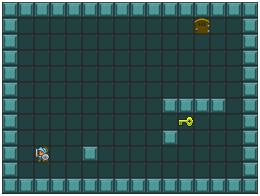

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=238853, Sun Oct 30 12:56:01 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.700000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 7.700000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 7.200000000000000e+01 1.1e+00 4.40e-01  4e-01  4e-01 0:00.3
   37    518 6.000000000000000e+01 1.7e+00 4.42e-01  4e-01  5e-01 0:03.4
   49    686 6.000000000000000e+01 1.9e+00 4.83e-01  5e-01  5e-01 0:04.5
   50    700 6.000000000000000e+01 2.0e+00 4.87e-01  5e-01  6e-01 0:04.5
   51    714 6.000000000000000e+01 2.0e+00 4.89e-01  5e-01  6e-01 0:04.6
   62    868 6.000000000000000e+01 2.2e+00 6.22e-01  6e-01  8e-01 0:05.7
   63    882 6.000000000000000e+01 2.2e+00 6.37e-01  6e-01  8e-01 0:05.8
   70    980 6.000000000000000e+01 2.3e+00 7.21e-01  7e-01  9e-01 0:06.4
   83   1162 6.000000000000000e+01 2.4e+00 6.35e-01  6e-01  8e-01 0:07.6
   84   1176 6.000000000000000e+0

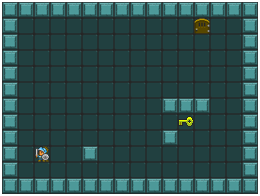

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=231803, Sun Oct 30 12:56:15 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.100000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 6.900000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.2
    3     42 7.400000000000000e+01 1.1e+00 4.25e-01  4e-01  4e-01 0:00.3
   36    504 6.100000000000000e+01 1.9e+00 6.87e-01  7e-01  9e-01 0:03.3
   46    644 6.100000000000000e+01 2.1e+00 7.40e-01  7e-01  1e+00 0:04.1
   51    714 6.100000000000000e+01 2.3e+00 7.77e-01  7e-01  1e+00 0:04.6
   54    756 6.100000000000000e+01 2.3e+00 8.26e-01  8e-01  1e+00 0:04.8
   55    770 6.100000000000000e+01 2.4e+00 8.53e-01  8e-01  1e+00 0:04.9
   56    784 6.100000000000000e+01 2.4e+00 8.62e-01  8e-01  1e+00 0:05.0
   59    826 6.100000000000000e+01 2.4e+00 8.32e-01  8e-01  1e+00 0:05.2
   60    840 6.100000000000000e+01 2.4e+00 8.13e-01  8e-01  1e+00 0:05.3
   64    896 6.100000000000000e+0

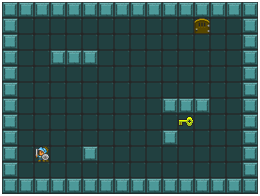

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=233405, Sun Oct 30 12:56:29 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.700000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 8.600000000000000e+01 1.1e+00 4.56e-01  5e-01  5e-01 0:00.2
    3     42 7.700000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.3
   37    518 6.200000000000000e+01 1.7e+00 7.00e-01  7e-01  8e-01 0:03.3
   75   1050 6.100000000000000e+01 2.3e+00 8.28e-01  8e-01  1e+00 0:07.3
   94   1316 6.100000000000000e+01 2.4e+00 8.85e-01  8e-01  1e+00 0:09.0
   95   1330 6.100000000000000e+01 2.4e+00 8.83e-01  8e-01  1e+00 0:09.1
  100   1400 6.100000000000000e+01 2.5e+00 8.53e-01  8e-01  1e+00 0:09.6
  102   1428 6.100000000000000e+01 2.5e+00 7.83e-01  7e-01  9e-01 0:09.8
  103   1442 6.100000000000000e+01 2.5e+00 7.64e-01  7e-01  9e-01 0:09.9
  104   1456 6.100000000000000e+01 2.5e+00 7.52e-01  7e-01  9e-01 0:10.0
  105   1470 6.100000000000000e+0

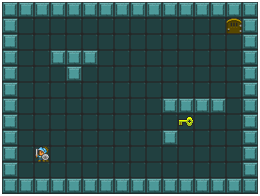

mean score:59.76
mean counts:59.76
mean changes:-22.88
mean playability:1.0
mean hamming dist:4.429387755102041


In [6]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-700/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf2)

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=314755, Sun Oct 30 12:56:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.100000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 -9.500000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.2
    3     42 -9.200000000000000e+01 1.1e+00 4.31e-01  4e-01  4e-01 0:00.3
   39    546 -1.300000000000000e+02 1.7e+00 4.39e-01  4e-01  5e-01 0:03.3
   86   1204 -1.330000000000000e+02 2.2e+00 3.14e-01  3e-01  4e-01 0:07.4
   91   1274 -1.330000000000000e+02 2.3e+00 2.73e-01  2e-01  3e-01 0:07.8
  100   1400 -1.330000000000000e+02 2.3e+00 2.18e-01  2e-01  2e-01 0:08.6
  106   1484 -1.330000000000000e+02 2.3e+00 2.07e-01  2e-01  2e-01 0:09.1
  107   1498 -1.330000000000000e+02 2.3e+00 2.07e-01  2e-01  2e-01 0:09.2
  110   1540 -1.330000000000000e+02 2.4e+00 2.06e-01  2e-01  2e-01 0:09.4
  113   1582 -1.330000000000000e+02 2.4e+00 1.97e-01  2e-01  2e-01 0:09.7
  114   1596 -1.330000

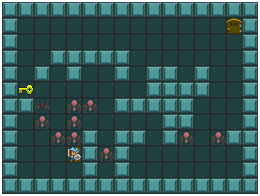

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=224078, Sun Oct 30 12:56:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.79e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.64e-01  5e-01  5e-01 0:00.2
    3     42 -8.100000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.73e-01  5e-01  5e-01 0:00.4
    6     84 1.000000000000000e+02 1.2e+00 4.82e-01  5e-01  5e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.96e-01  5e-01  5e-01 0:00.6
   81   1134 -1.250000000000000e+02 2.4e+00 8.81e-01  8e-01  1e+00 0:06.6
  100   1400 -1.280000000000000e+02 2.7e+00 7.61e-01  7e-01  9e-01 0:08.3
  133   1862 -1.280000000000000e+02 2.9e+00 3.77e-01  3e-01  5e-01 0:10.9
  134   1876 -1.280000000000000e+02 2.9e+00 3.70e-01  3e-01  4e-01 0:11.0
  135   1890 -1.280000000000000e+02 2.9e+00 3.62e-01  3e-01  4e-01 0:11.1
  136   1904 -1.28000000000

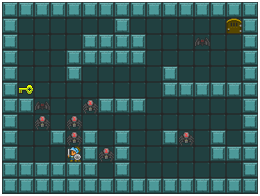

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=310121, Sun Oct 30 12:57:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.300000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -9.500000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 -1.010000000000000e+02 1.1e+00 4.47e-01  4e-01  5e-01 0:00.3
   41    574 -1.280000000000000e+02 1.7e+00 7.26e-01  7e-01  8e-01 0:03.3
   96   1344 -1.450000000000000e+02 2.3e+00 5.24e-01  5e-01  6e-01 0:07.4
  100   1400 -1.450000000000000e+02 2.3e+00 5.00e-01  4e-01  6e-01 0:07.7
  136   1904 -1.450000000000000e+02 2.4e+00 2.62e-01  2e-01  3e-01 0:10.5


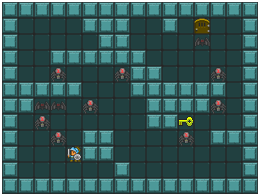

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=237077, Sun Oct 30 12:57:21 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.52e-01  4e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.39e-01  4e-01  4e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.21e-01  4e-01  4e-01 0:00.3
   55    770 -1.320000000000000e+02 1.7e+00 4.23e-01  4e-01  4e-01 0:04.3
  100   1400 -1.440000000000000e+02 2.0e+00 1.87e-01  2e-01  2e-01 0:07.8


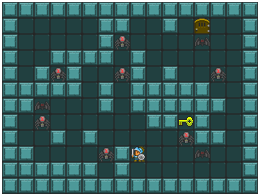

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=294922, Sun Oct 30 12:57:33 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.900000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -1.070000000000000e+02 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 -1.080000000000000e+02 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
   41    574 -1.390000000000000e+02 1.6e+00 3.72e-01  4e-01  4e-01 0:03.3
   92   1288 -1.520000000000000e+02 1.7e+00 1.77e-01  2e-01  2e-01 0:07.3
  100   1400 -1.520000000000000e+02 1.8e+00 1.56e-01  1e-01  2e-01 0:07.9
  145   2030 -1.520000000000000e+02 2.0e+00 6.51e-02  6e-02  7e-02 0:11.4
  146   2044 -1.520000000000000e+02 2.0e+00 6.38e-02  6e-02  6e-02 0:11.4
  147   2058 -1.520000000000000e+02 2.0e+00 6.34e-02  6e-02  6e-02 0:11.5
  148   2072 -1.520000000000000e+02 2.0e+00 6.29e-02  6e-02  6e-02 0:11.6
  149   2086 -1.520000000000000e+02 2.0e+00 6.28e-02  6e-02  6e-02 0:11.7
  150   2100 -1.520000

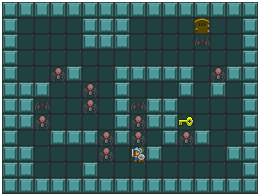

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=300973, Sun Oct 30 12:57:45 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.900000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.60e-01  5e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.63e-01  5e-01  5e-01 0:00.3
    5     70 1.000000000000000e+02 1.2e+00 4.67e-01  5e-01  5e-01 0:00.4
    6     84 1.000000000000000e+02 1.2e+00 4.63e-01  5e-01  5e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.58e-01  5e-01  5e-01 0:00.6
    8    112 1.000000000000000e+02 1.2e+00 4.60e-01  5e-01  5e-01 0:00.6
    9    126 1.000000000000000e+02 1.2e+00 4.51e-01  4e-01  5e-01 0:00.7
  100   1400 -1.500000000000000e+02 2.2e+00 3.09e-01  3e-01  3e-01 0:07.6


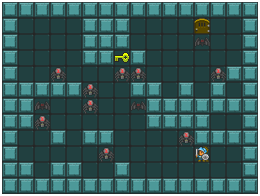

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=188871, Sun Oct 30 12:57:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.040000000000000e+02 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -1.050000000000000e+02 1.1e+00 4.60e-01  5e-01  5e-01 0:00.2
    3     42 -9.200000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
   43    602 -1.230000000000000e+02 2.1e+00 7.57e-01  7e-01  8e-01 0:03.3
   96   1344 -1.260000000000000e+02 2.5e+00 4.66e-01  4e-01  5e-01 0:07.4
  100   1400 -1.260000000000000e+02 2.6e+00 4.06e-01  4e-01  4e-01 0:07.7
  118   1652 -1.260000000000000e+02 2.7e+00 3.05e-01  3e-01  3e-01 0:09.2
  119   1666 -1.260000000000000e+02 2.7e+00 3.01e-01  3e-01  3e-01 0:09.2
  124   1736 -1.260000000000000e+02 2.7e+00 2.87e-01  3e-01  3e-01 0:09.6
  130   1820 -1.260000000000000e+02 2.7e+00 3.06e-01  3e-01  3e-01 0:10.2


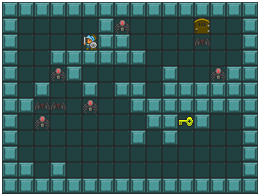

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=243769, Sun Oct 30 12:58:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.600000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -1.050000000000000e+02 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 -1.030000000000000e+02 1.1e+00 4.45e-01  4e-01  4e-01 0:00.2
    6     84 1.000000000000000e+02 1.2e+00 4.61e-01  5e-01  5e-01 0:00.5
   57    798 -1.410000000000000e+02 1.7e+00 4.22e-01  4e-01  4e-01 0:04.5
  100   1400 -1.530000000000000e+02 2.0e+00 5.41e-01  5e-01  6e-01 0:07.9


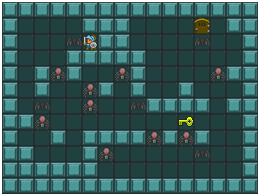

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=203030, Sun Oct 30 12:58:21 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.900000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 -9.800000000000000e+01 1.1e+00 4.60e-01  5e-01  5e-01 0:00.2
    3     42 -1.020000000000000e+02 1.1e+00 4.55e-01  5e-01  5e-01 0:00.3
   43    602 -1.210000000000000e+02 1.8e+00 4.99e-01  5e-01  5e-01 0:03.3
   96   1344 -1.300000000000000e+02 2.1e+00 2.98e-01  3e-01  3e-01 0:07.4
  100   1400 -1.310000000000000e+02 2.1e+00 3.06e-01  3e-01  4e-01 0:07.7


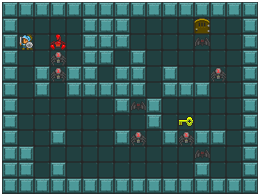

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=204944, Sun Oct 30 12:58:33 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.600000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 -9.400000000000000e+01 1.1e+00 4.47e-01  4e-01  4e-01 0:00.2
    3     42 -9.500000000000000e+01 1.1e+00 4.41e-01  4e-01  4e-01 0:00.3
   39    546 -1.400000000000000e+02 1.8e+00 5.43e-01  5e-01  6e-01 0:03.3
   89   1246 -1.470000000000000e+02 2.3e+00 3.61e-01  3e-01  4e-01 0:07.3
  100   1400 -1.490000000000000e+02 2.3e+00 3.64e-01  3e-01  4e-01 0:08.3


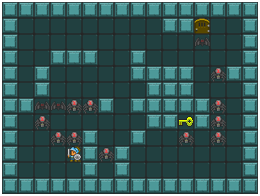

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=236256, Sun Oct 30 12:58:46 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.030000000000000e+02 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -1.080000000000000e+02 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 -1.000000000000000e+02 1.1e+00 4.33e-01  4e-01  4e-01 0:00.3
   43    602 -1.360000000000000e+02 1.7e+00 3.65e-01  3e-01  4e-01 0:03.3
   91   1274 -1.400000000000000e+02 1.9e+00 1.53e-01  1e-01  2e-01 0:07.3
   97   1358 -1.400000000000000e+02 1.9e+00 1.41e-01  1e-01  2e-01 0:07.9
   98   1372 -1.400000000000000e+02 1.9e+00 1.39e-01  1e-01  1e-01 0:08.0
   99   1386 -1.400000000000000e+02 2.0e+00 1.35e-01  1e-01  1e-01 0:08.1
  100   1400 -1.400000000000000e+02 2.0e+00 1.32e-01  1e-01  1e-01 0:08.1
  108   1512 -1.410000000000000e+02 2.0e+00 1.16e-01  1e-01  1e-01 0:08.8
  109   1526 -1.410000000000000e+02 2.0e+00 1.15e-01  1e-01  1e-01 0:08.9
  110   1540 -1.410000

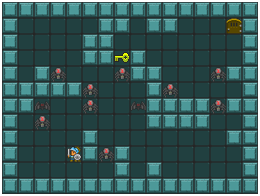

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=213002, Sun Oct 30 12:58:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.900000000000000e+01 1.0e+00 4.65e-01  5e-01  5e-01 0:00.1
    2     28 -8.300000000000000e+01 1.1e+00 4.36e-01  4e-01  4e-01 0:00.2
    3     42 -8.600000000000000e+01 1.1e+00 4.26e-01  4e-01  4e-01 0:00.3
   38    532 -1.160000000000000e+02 1.7e+00 6.17e-01  6e-01  7e-01 0:03.3
   88   1232 -1.280000000000000e+02 2.3e+00 6.12e-01  6e-01  7e-01 0:07.3
  100   1400 -1.290000000000000e+02 2.4e+00 5.26e-01  5e-01  6e-01 0:08.3


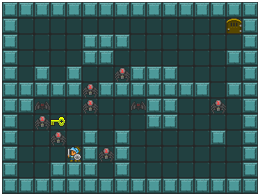

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=238569, Sun Oct 30 12:59:11 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.600000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 -9.000000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.3
    3     42 -1.030000000000000e+02 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
   42    588 -1.310000000000000e+02 1.7e+00 4.26e-01  4e-01  4e-01 0:03.4
   95   1330 -1.360000000000000e+02 2.3e+00 2.86e-01  3e-01  3e-01 0:07.4
  100   1400 -1.360000000000000e+02 2.3e+00 2.60e-01  2e-01  3e-01 0:07.9


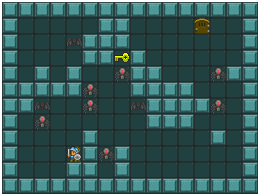

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=167966, Sun Oct 30 12:59:24 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.020000000000000e+02 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -9.400000000000000e+01 1.1e+00 4.47e-01  4e-01  4e-01 0:00.2
    3     42 -1.030000000000000e+02 1.1e+00 4.39e-01  4e-01  4e-01 0:00.3
   39    546 -1.410000000000000e+02 1.7e+00 5.97e-01  6e-01  7e-01 0:03.3
   90   1260 -1.490000000000000e+02 2.3e+00 4.98e-01  5e-01  6e-01 0:07.3
  100   1400 -1.500000000000000e+02 2.3e+00 5.31e-01  5e-01  6e-01 0:08.1
  147   2058 -1.530000000000000e+02 2.5e+00 2.24e-01  2e-01  3e-01 0:11.8
  148   2072 -1.530000000000000e+02 2.5e+00 2.17e-01  2e-01  2e-01 0:11.8
  149   2086 -1.530000000000000e+02 2.5e+00 2.08e-01  2e-01  2e-01 0:11.9
  150   2100 -1.530000000000000e+02 2.5e+00 2.01e-01  2e-01  2e-01 0:12.0


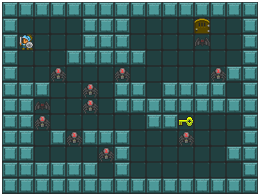

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=239239, Sun Oct 30 12:59:36 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.000000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -1.010000000000000e+02 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 -9.800000000000000e+01 1.1e+00 4.33e-01  4e-01  4e-01 0:00.3
   40    560 -1.270000000000000e+02 1.7e+00 4.15e-01  4e-01  5e-01 0:03.3
   88   1232 -1.350000000000000e+02 2.2e+00 3.56e-01  3e-01  4e-01 0:07.3
  100   1400 -1.360000000000000e+02 2.4e+00 3.49e-01  3e-01  4e-01 0:08.2


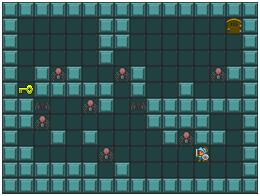

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=225802, Sun Oct 30 12:59:48 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.090000000000000e+02 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -1.090000000000000e+02 1.1e+00 4.59e-01  5e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
   41    574 -1.180000000000000e+02 1.6e+00 3.65e-01  3e-01  4e-01 0:03.3
   92   1288 -1.410000000000000e+02 2.3e+00 6.70e-01  6e-01  7e-01 0:07.3
  100   1400 -1.480000000000000e+02 2.4e+00 5.53e-01  5e-01  6e-01 0:07.9


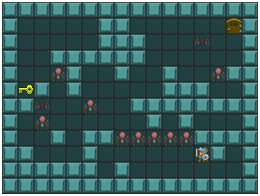

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=229029, Sun Oct 30 13:00:00 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.80e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.63e-01  5e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.43e-01  4e-01  4e-01 0:00.3
    4     56 1.000000000000000e+02 1.1e+00 4.43e-01  4e-01  4e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.52e-01  4e-01  5e-01 0:00.4
    6     84 1.000000000000000e+02 1.2e+00 4.53e-01  4e-01  5e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.55e-01  4e-01  5e-01 0:00.5
    8    112 1.000000000000000e+02 1.2e+00 4.52e-01  4e-01  5e-01 0:00.6
    9    126 1.000000000000000e+02 1.2e+00 4.45e-01  4e-01  5e-01 0:00.7
   10    140 1.000000000000000e+02 1.2e+00 4.44e-01  4e-01  5e-01 0:00.7
   11    154 1.000000000000000e+02 1.3e+00 4.47e-01  4e-01  5e-01 0:00.8
   12    168 1.000000000000000e+0

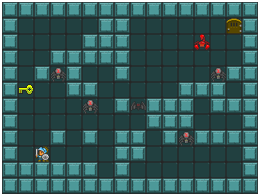

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=180074, Sun Oct 30 13:00:13 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.160000000000000e+02 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 -1.160000000000000e+02 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 -1.110000000000000e+02 1.1e+00 4.43e-01  4e-01  4e-01 0:00.3
   41    574 -1.490000000000000e+02 1.8e+00 5.43e-01  5e-01  6e-01 0:03.3
   92   1288 -1.550000000000000e+02 2.7e+00 1.01e+00  9e-01  1e+00 0:07.3
  100   1400 -1.590000000000000e+02 2.7e+00 9.36e-01  9e-01  1e+00 0:08.0


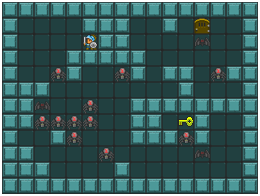

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=168203, Sun Oct 30 13:00:25 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -1.100000000000000e+02 1.1e+00 4.52e-01  4e-01  5e-01 0:00.2
    3     42 -1.110000000000000e+02 1.1e+00 4.44e-01  4e-01  5e-01 0:00.3
   38    532 -1.350000000000000e+02 1.8e+00 6.36e-01  6e-01  7e-01 0:03.3
   87   1218 -1.370000000000000e+02 2.2e+00 4.00e-01  4e-01  4e-01 0:07.4
   96   1344 -1.370000000000000e+02 2.3e+00 3.40e-01  3e-01  4e-01 0:08.2
  100   1400 -1.370000000000000e+02 2.3e+00 3.09e-01  3e-01  3e-01 0:08.5
  107   1498 -1.370000000000000e+02 2.4e+00 2.55e-01  2e-01  3e-01 0:09.1
  108   1512 -1.370000000000000e+02 2.4e+00 2.46e-01  2e-01  3e-01 0:09.2
  109   1526 -1.370000000000000e+02 2.4e+00 2.40e-01  2e-01  3e-01 0:09.3
  110   1540 -1.370000000000000e+02 2.4e+00 2.35e-01  2e-01  3e-01 0:09.4
  111   1554 -1.3700000

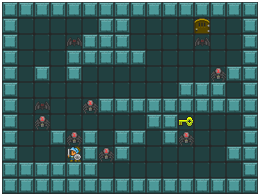

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=151283, Sun Oct 30 13:00:38 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.010000000000000e+02 1.0e+00 4.80e-01  5e-01  5e-01 0:00.1
    2     28 -1.030000000000000e+02 1.1e+00 4.76e-01  5e-01  5e-01 0:00.1
    3     42 -1.010000000000000e+02 1.1e+00 4.72e-01  5e-01  5e-01 0:00.2
   40    560 -1.370000000000000e+02 1.8e+00 6.33e-01  6e-01  7e-01 0:03.3
   91   1274 -1.540000000000000e+02 2.2e+00 3.56e-01  3e-01  4e-01 0:07.3
  100   1400 -1.530000000000000e+02 2.3e+00 3.60e-01  3e-01  4e-01 0:08.0


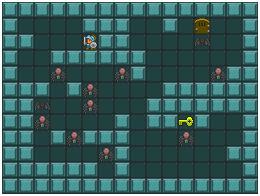

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=190866, Sun Oct 30 13:00:50 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.500000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 -8.300000000000000e+01 1.1e+00 4.45e-01  4e-01  4e-01 0:00.2
    3     42 -9.700000000000000e+01 1.1e+00 4.40e-01  4e-01  4e-01 0:00.3
   42    588 -1.210000000000000e+02 1.8e+00 5.39e-01  5e-01  6e-01 0:03.3
   93   1302 -1.460000000000000e+02 2.9e+00 5.55e-01  5e-01  7e-01 0:07.4
  100   1400 -1.460000000000000e+02 3.0e+00 5.47e-01  5e-01  7e-01 0:08.0
  145   2030 -1.480000000000000e+02 3.3e+00 3.21e-01  3e-01  4e-01 0:11.6
  146   2044 -1.480000000000000e+02 3.3e+00 3.17e-01  3e-01  4e-01 0:11.7
  147   2058 -1.480000000000000e+02 3.3e+00 3.04e-01  3e-01  4e-01 0:11.8


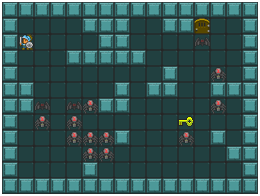

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=221174, Sun Oct 30 13:01:02 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.200000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 -1.010000000000000e+02 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
    3     42 -1.000000000000000e+02 1.1e+00 4.47e-01  4e-01  5e-01 0:00.2
   42    588 -1.190000000000000e+02 1.6e+00 3.56e-01  3e-01  4e-01 0:03.3
   91   1274 -1.270000000000000e+02 2.2e+00 2.78e-01  3e-01  3e-01 0:07.3
  100   1400 -1.270000000000000e+02 2.3e+00 2.14e-01  2e-01  2e-01 0:08.0
  113   1582 -1.270000000000000e+02 2.4e+00 1.59e-01  1e-01  2e-01 0:09.1
  133   1862 -1.270000000000000e+02 2.6e+00 1.49e-01  1e-01  2e-01 0:10.8
  134   1876 -1.270000000000000e+02 2.6e+00 1.49e-01  1e-01  2e-01 0:10.8
  135   1890 -1.270000000000000e+02 2.6e+00 1.47e-01  1e-01  2e-01 0:10.9
  136   1904 -1.270000000000000e+02 2.6e+00 1.46e-01  1e-01  2e-01 0:11.0
  139   1946 -1.270000

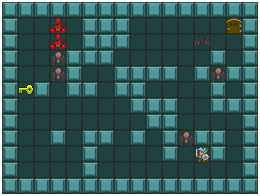

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=285094, Sun Oct 30 13:01:14 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.58e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.33e-01  4e-01  4e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.22e-01  4e-01  4e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.13e-01  4e-01  4e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.12e-01  4e-01  4e-01 0:00.4
    6     84 1.000000000000000e+02 1.1e+00 4.07e-01  4e-01  4e-01 0:00.5
   84   1176 -1.390000000000000e+02 3.4e+00 1.05e+00  1e+00  1e+00 0:06.5
  100   1400 -1.400000000000000e+02 3.6e+00 7.56e-01  7e-01  1e+00 0:07.8


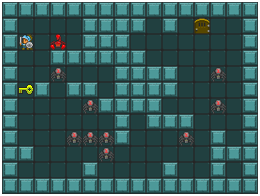

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=277453, Sun Oct 30 13:01:26 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.77e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.69e-01  5e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.65e-01  5e-01  5e-01 0:00.3
    4     56 1.000000000000000e+02 1.1e+00 4.65e-01  5e-01  5e-01 0:00.4
    5     70 1.000000000000000e+02 1.1e+00 4.60e-01  5e-01  5e-01 0:00.5
    6     84 1.000000000000000e+02 1.2e+00 4.58e-01  5e-01  5e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.56e-01  4e-01  5e-01 0:00.6
    8    112 1.000000000000000e+02 1.2e+00 4.49e-01  4e-01  5e-01 0:00.7
    9    126 1.000000000000000e+02 1.2e+00 4.51e-01  4e-01  5e-01 0:00.8
   10    140 1.000000000000000e+02 1.2e+00 4.52e-01  4e-01  5e-01 0:00.8
   11    154 1.000000000000000e+02 1.2e+00 4.56e-01  4e-01  5e-01 0:00.9
   12    168 1.000000000000000e+0

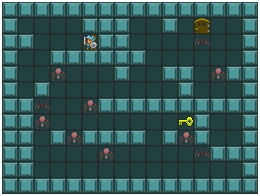

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=252409, Sun Oct 30 13:01:38 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.130000000000000e+02 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 -1.120000000000000e+02 1.1e+00 4.68e-01  5e-01  5e-01 0:00.2
    3     42 -1.150000000000000e+02 1.1e+00 4.53e-01  4e-01  5e-01 0:00.3
   40    560 -1.410000000000000e+02 1.6e+00 4.23e-01  4e-01  5e-01 0:03.3
   87   1218 -1.460000000000000e+02 2.2e+00 3.53e-01  3e-01  4e-01 0:07.4
  100   1400 -1.490000000000000e+02 2.4e+00 2.82e-01  3e-01  3e-01 0:08.4
  149   2086 -1.490000000000000e+02 2.6e+00 1.45e-01  1e-01  2e-01 0:12.4


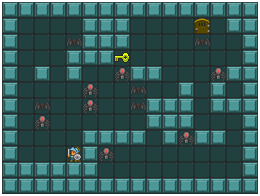

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=214585, Sun Oct 30 13:01:51 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 -8.500000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.33e-01  4e-01  4e-01 0:00.2
   40    560 -1.150000000000000e+02 1.9e+00 8.96e-01  8e-01  1e+00 0:03.3
   92   1288 -1.340000000000000e+02 3.2e+00 1.90e+00  2e+00  2e+00 0:07.3
  100   1400 -1.370000000000000e+02 3.3e+00 1.81e+00  2e+00  2e+00 0:08.0


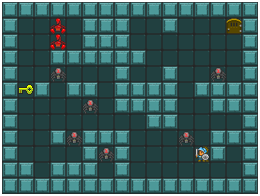

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=232766, Sun Oct 30 13:02:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.62e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.35e-01  4e-01  4e-01 0:00.2
    3     42 -8.900000000000000e+01 1.1e+00 4.18e-01  4e-01  4e-01 0:00.3
   42    588 -1.400000000000000e+02 2.1e+00 9.39e-01  9e-01  1e+00 0:03.3
   95   1330 -1.420000000000000e+02 2.8e+00 9.32e-01  9e-01  1e+00 0:07.4
  100   1400 -1.450000000000000e+02 2.8e+00 8.98e-01  8e-01  1e+00 0:07.8


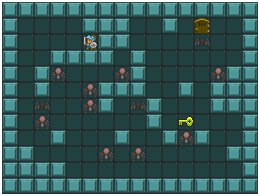

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=248374, Sun Oct 30 13:02:15 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.600000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -1.050000000000000e+02 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 -1.010000000000000e+02 1.1e+00 4.49e-01  4e-01  5e-01 0:00.3
   40    560 -1.430000000000000e+02 1.9e+00 4.61e-01  4e-01  5e-01 0:03.3
   93   1302 -1.470000000000000e+02 2.3e+00 2.22e-01  2e-01  3e-01 0:07.4
  100   1400 -1.470000000000000e+02 2.3e+00 1.94e-01  2e-01  2e-01 0:07.9


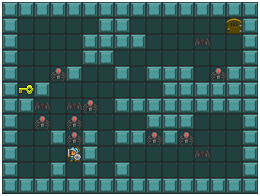

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=238961, Sun Oct 30 13:02:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.010000000000000e+02 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 -1.160000000000000e+02 1.1e+00 4.54e-01  4e-01  5e-01 0:00.2
    3     42 -1.010000000000000e+02 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
   42    588 -1.450000000000000e+02 1.6e+00 4.00e-01  4e-01  4e-01 0:03.3
   95   1330 -1.580000000000000e+02 2.1e+00 3.13e-01  3e-01  4e-01 0:07.3
  100   1400 -1.580000000000000e+02 2.1e+00 2.88e-01  3e-01  3e-01 0:07.7


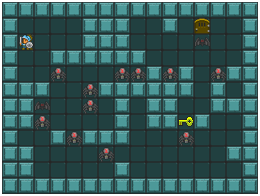

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=293120, Sun Oct 30 13:02:39 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.140000000000000e+02 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -1.180000000000000e+02 1.1e+00 4.71e-01  5e-01  5e-01 0:00.2
    3     42 -1.190000000000000e+02 1.1e+00 4.71e-01  5e-01  5e-01 0:00.3
   40    560 -1.350000000000000e+02 1.8e+00 5.00e-01  5e-01  5e-01 0:03.3
   90   1260 -1.390000000000000e+02 2.5e+00 3.29e-01  3e-01  4e-01 0:07.4
  100   1400 -1.430000000000000e+02 2.6e+00 3.31e-01  3e-01  4e-01 0:08.2


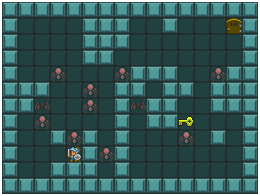

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=173929, Sun Oct 30 13:02:52 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.020000000000000e+02 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -9.900000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.2
    3     42 -1.000000000000000e+02 1.1e+00 4.51e-01  4e-01  5e-01 0:00.3
   41    574 -1.230000000000000e+02 1.7e+00 3.58e-01  3e-01  4e-01 0:03.3
   93   1302 -1.440000000000000e+02 2.2e+00 3.39e-01  3e-01  4e-01 0:07.3
  100   1400 -1.440000000000000e+02 2.3e+00 3.56e-01  3e-01  4e-01 0:07.9


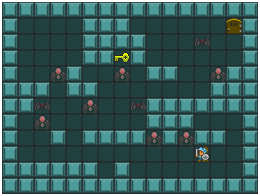

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=198942, Sun Oct 30 13:03:04 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.100000000000000e+02 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 -1.060000000000000e+02 1.1e+00 4.52e-01  4e-01  5e-01 0:00.2
    3     42 -1.130000000000000e+02 1.1e+00 4.42e-01  4e-01  4e-01 0:00.3
   38    532 -1.350000000000000e+02 1.8e+00 6.75e-01  6e-01  7e-01 0:03.3
   89   1246 -1.520000000000000e+02 2.6e+00 7.31e-01  7e-01  9e-01 0:07.3
  100   1400 -1.530000000000000e+02 2.7e+00 7.13e-01  7e-01  9e-01 0:08.2
  142   1988 -1.530000000000000e+02 2.9e+00 4.03e-01  4e-01  5e-01 0:11.7
  143   2002 -1.530000000000000e+02 2.9e+00 3.92e-01  4e-01  5e-01 0:11.8
  146   2044 -1.530000000000000e+02 2.9e+00 3.65e-01  3e-01  4e-01 0:12.1


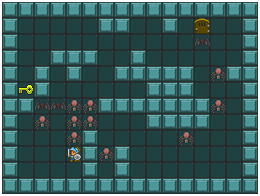

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=313970, Sun Oct 30 13:03:16 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.000000000000000e+01 1.0e+00 4.64e-01  5e-01  5e-01 0:00.1
    2     28 -8.700000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.2
    3     42 -9.500000000000000e+01 1.1e+00 4.16e-01  4e-01  4e-01 0:00.3
   39    546 -1.240000000000000e+02 1.7e+00 3.80e-01  4e-01  4e-01 0:03.3
   86   1204 -1.310000000000000e+02 2.0e+00 2.82e-01  3e-01  3e-01 0:07.4
  100   1400 -1.360000000000000e+02 2.0e+00 2.78e-01  3e-01  3e-01 0:08.6


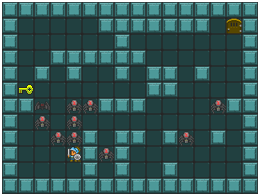

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=193461, Sun Oct 30 13:03:30 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.300000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 -9.900000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.2
    3     42 -9.800000000000000e+01 1.1e+00 4.34e-01  4e-01  4e-01 0:00.3
   41    574 -1.380000000000000e+02 1.8e+00 4.05e-01  4e-01  4e-01 0:03.3
   90   1260 -1.510000000000000e+02 2.0e+00 2.40e-01  2e-01  3e-01 0:07.4
  100   1400 -1.520000000000000e+02 2.1e+00 2.29e-01  2e-01  3e-01 0:08.2
  122   1708 -1.520000000000000e+02 2.4e+00 1.41e-01  1e-01  2e-01 0:10.0
  130   1820 -1.520000000000000e+02 2.4e+00 1.49e-01  1e-01  2e-01 0:10.6
  144   2016 -1.520000000000000e+02 2.6e+00 1.26e-01  1e-01  1e-01 0:11.7
  145   2030 -1.520000000000000e+02 2.6e+00 1.24e-01  1e-01  1e-01 0:11.8
  148   2072 -1.520000000000000e+02 2.6e+00 1.22e-01  1e-01  1e-01 0:12.0
  149   2086 -1.520000

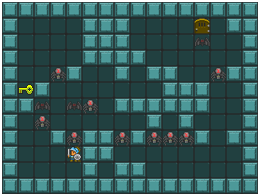

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=281338, Sun Oct 30 13:03:42 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.58e-01  5e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.51e-01  4e-01  5e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.55e-01  4e-01  5e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.59e-01  4e-01  5e-01 0:00.4
    6     84 1.000000000000000e+02 1.2e+00 4.57e-01  4e-01  5e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.59e-01  4e-01  5e-01 0:00.6
    8    112 1.000000000000000e+02 1.2e+00 4.55e-01  4e-01  5e-01 0:00.6
    9    126 1.000000000000000e+02 1.2e+00 4.52e-01  4e-01  5e-01 0:00.7
   10    140 1.000000000000000e+02 1.2e+00 4.55e-01  4e-01  5e-01 0:00.8
   11    154 1.000000000000000e+02 1.3e+00 4.63e-01  5e-01  5e-01 0:00.9
   12    168 1.000000000000000e+0

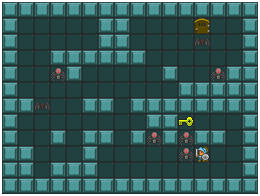

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=270462, Sun Oct 30 13:03:54 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.000000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -7.800000000000000e+01 1.1e+00 4.60e-01  5e-01  5e-01 0:00.2
    3     42 -7.700000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.3
   40    560 -1.200000000000000e+02 2.2e+00 8.43e-01  8e-01  9e-01 0:03.3
   87   1218 -1.320000000000000e+02 2.8e+00 8.58e-01  8e-01  1e+00 0:07.4
  100   1400 -1.330000000000000e+02 2.9e+00 8.12e-01  7e-01  9e-01 0:08.6
  112   1568 -1.330000000000000e+02 2.8e+00 7.69e-01  7e-01  9e-01 0:09.6
  115   1610 -1.330000000000000e+02 2.8e+00 7.04e-01  6e-01  8e-01 0:09.8
  147   2058 -1.330000000000000e+02 3.1e+00 5.34e-01  5e-01  6e-01 0:12.6
  148   2072 -1.330000000000000e+02 3.1e+00 5.35e-01  5e-01  6e-01 0:12.7
  149   2086 -1.330000000000000e+02 3.1e+00 5.45e-01  5e-01  6e-01 0:12.8


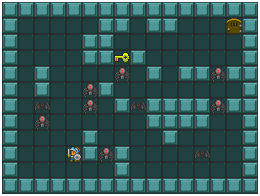

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=208940, Sun Oct 30 13:04:07 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.070000000000000e+02 1.0e+00 4.82e-01  5e-01  5e-01 0:00.1
    2     28 -1.040000000000000e+02 1.1e+00 4.71e-01  5e-01  5e-01 0:00.2
    3     42 -1.080000000000000e+02 1.1e+00 4.70e-01  5e-01  5e-01 0:00.3
   42    588 -1.340000000000000e+02 1.7e+00 5.81e-01  6e-01  6e-01 0:03.3
   95   1330 -1.430000000000000e+02 2.0e+00 3.72e-01  3e-01  4e-01 0:07.4
  100   1400 -1.450000000000000e+02 2.0e+00 3.66e-01  3e-01  4e-01 0:07.8


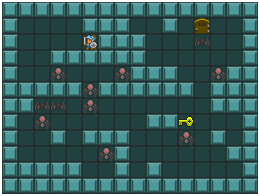

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=239695, Sun Oct 30 13:04:19 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.060000000000000e+02 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 -1.110000000000000e+02 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
    3     42 -1.070000000000000e+02 1.1e+00 4.32e-01  4e-01  4e-01 0:00.3
   40    560 -1.400000000000000e+02 1.7e+00 4.33e-01  4e-01  5e-01 0:03.3
   90   1260 -1.500000000000000e+02 2.2e+00 3.33e-01  3e-01  4e-01 0:07.4
  100   1400 -1.520000000000000e+02 2.3e+00 3.27e-01  3e-01  4e-01 0:08.2


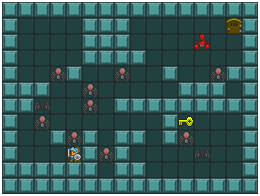

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=236933, Sun Oct 30 13:04:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.68e-01  5e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.67e-01  5e-01  5e-01 0:00.2
   38    532 -1.270000000000000e+02 1.9e+00 7.40e-01  7e-01  8e-01 0:03.3
   85   1190 -1.350000000000000e+02 2.3e+00 5.59e-01  5e-01  7e-01 0:07.3
  100   1400 -1.360000000000000e+02 2.4e+00 5.20e-01  5e-01  6e-01 0:08.6


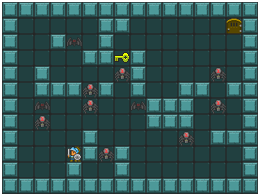

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=157658, Sun Oct 30 13:04:45 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.900000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 -9.200000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.2
    3     42 -9.400000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.3
   43    602 -1.350000000000000e+02 1.6e+00 5.28e-01  5e-01  6e-01 0:03.3
   95   1330 -1.520000000000000e+02 1.8e+00 3.47e-01  3e-01  4e-01 0:07.4
  100   1400 -1.520000000000000e+02 1.8e+00 3.49e-01  3e-01  4e-01 0:07.8


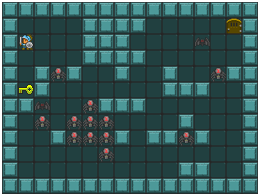

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=219116, Sun Oct 30 13:04:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.200000000000000e+02 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -1.250000000000000e+02 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 -1.250000000000000e+02 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
   43    602 -1.390000000000000e+02 1.5e+00 2.39e-01  2e-01  2e-01 0:03.3
   96   1344 -1.440000000000000e+02 2.0e+00 1.21e-01  1e-01  1e-01 0:07.4
  100   1400 -1.440000000000000e+02 2.0e+00 1.12e-01  1e-01  1e-01 0:07.7
  111   1554 -1.440000000000000e+02 2.1e+00 1.18e-01  1e-01  1e-01 0:08.6
  124   1736 -1.440000000000000e+02 2.1e+00 1.01e-01  9e-02  1e-01 0:09.5
  127   1778 -1.440000000000000e+02 2.1e+00 9.42e-02  8e-02  1e-01 0:09.8
  128   1792 -1.440000000000000e+02 2.1e+00 9.29e-02  8e-02  1e-01 0:09.8
  129   1806 -1.440000000000000e+02 2.1e+00 9.32e-02  8e-02  1e-01 0:09.9
  136   1904 -1.440000

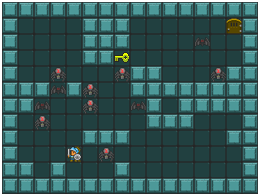

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=262516, Sun Oct 30 13:05:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.500000000000000e+01 1.0e+00 4.79e-01  5e-01  5e-01 0:00.1
    2     28 -9.300000000000000e+01 1.1e+00 4.73e-01  5e-01  5e-01 0:00.3
    3     42 -1.000000000000000e+02 1.1e+00 4.68e-01  5e-01  5e-01 0:00.4
   40    560 -1.310000000000000e+02 1.7e+00 5.32e-01  5e-01  6e-01 0:03.4
   90   1260 -1.350000000000000e+02 2.3e+00 4.00e-01  4e-01  5e-01 0:07.4
  100   1400 -1.340000000000000e+02 2.3e+00 3.38e-01  3e-01  4e-01 0:08.2
  138   1932 -1.350000000000000e+02 2.6e+00 1.57e-01  1e-01  2e-01 0:11.3
  139   1946 -1.350000000000000e+02 2.6e+00 1.55e-01  1e-01  2e-01 0:11.3
  140   1960 -1.350000000000000e+02 2.6e+00 1.55e-01  1e-01  2e-01 0:11.4
  141   1974 -1.350000000000000e+02 2.6e+00 1.52e-01  1e-01  2e-01 0:11.5
  142   1988 -1.350000000000000e+02 2.6e+00 1.52e-01  1e-01  2e-01 0:11.6
  143   2002 -1.350000

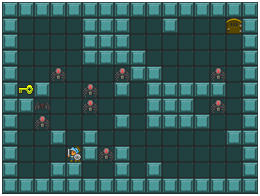

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=239266, Sun Oct 30 13:05:21 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.010000000000000e+02 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 -1.060000000000000e+02 1.1e+00 4.53e-01  4e-01  5e-01 0:00.2
    3     42 -1.020000000000000e+02 1.1e+00 4.39e-01  4e-01  4e-01 0:00.3
   42    588 -1.270000000000000e+02 1.7e+00 5.12e-01  5e-01  6e-01 0:03.3
   93   1302 -1.360000000000000e+02 2.0e+00 2.58e-01  2e-01  3e-01 0:07.4
  100   1400 -1.370000000000000e+02 2.1e+00 2.42e-01  2e-01  3e-01 0:08.0


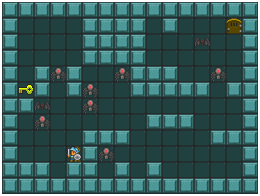

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=221177, Sun Oct 30 13:05:34 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -8.800000000000000e+01 1.1e+00 4.47e-01  4e-01  4e-01 0:00.2
    3     42 -9.700000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.3
   43    602 -1.360000000000000e+02 2.0e+00 7.75e-01  7e-01  9e-01 0:03.3
   95   1330 -1.410000000000000e+02 2.5e+00 5.02e-01  5e-01  6e-01 0:07.3
  100   1400 -1.410000000000000e+02 2.5e+00 4.41e-01  4e-01  5e-01 0:07.7
  115   1610 -1.410000000000000e+02 2.6e+00 3.55e-01  3e-01  4e-01 0:08.9
  116   1624 -1.410000000000000e+02 2.6e+00 3.56e-01  3e-01  4e-01 0:09.0
  125   1750 -1.410000000000000e+02 2.7e+00 3.53e-01  3e-01  4e-01 0:09.7
  126   1764 -1.410000000000000e+02 2.7e+00 3.43e-01  3e-01  4e-01 0:09.8
  136   1904 -1.410000000000000e+02 2.9e+00 3.14e-01  3e-01  4e-01 0:10.7
  141   1974 -1.4100000

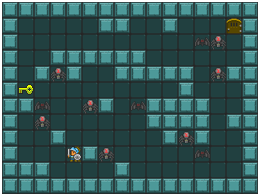

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=261999, Sun Oct 30 13:05:46 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.700000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -8.900000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
    3     42 -9.400000000000000e+01 1.1e+00 4.40e-01  4e-01  4e-01 0:00.3
   41    574 -1.500000000000000e+02 1.7e+00 5.29e-01  5e-01  6e-01 0:03.4
   92   1288 -1.510000000000000e+02 2.1e+00 2.31e-01  2e-01  2e-01 0:07.4
  100   1400 -1.520000000000000e+02 2.1e+00 2.02e-01  2e-01  2e-01 0:08.0
  137   1918 -1.530000000000000e+02 2.3e+00 1.28e-01  1e-01  1e-01 0:10.9


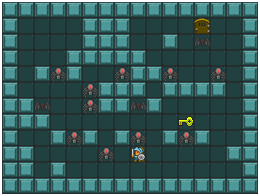

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=244791, Sun Oct 30 13:05:58 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.700000000000000e+01 1.0e+00 4.79e-01  5e-01  5e-01 0:00.1
    2     28 -9.200000000000000e+01 1.1e+00 4.69e-01  5e-01  5e-01 0:00.2
    3     42 -1.090000000000000e+02 1.1e+00 4.69e-01  5e-01  5e-01 0:00.2
   42    588 -1.350000000000000e+02 1.9e+00 6.51e-01  6e-01  7e-01 0:03.3
   95   1330 -1.440000000000000e+02 2.4e+00 6.97e-01  6e-01  8e-01 0:07.3
  100   1400 -1.440000000000000e+02 2.5e+00 6.13e-01  6e-01  7e-01 0:07.8


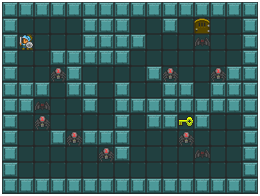

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=243190, Sun Oct 30 13:06:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.700000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -1.030000000000000e+02 1.1e+00 4.64e-01  5e-01  5e-01 0:00.2
    3     42 -9.300000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
   42    588 -1.290000000000000e+02 1.7e+00 4.67e-01  4e-01  5e-01 0:03.3
   92   1288 -1.340000000000000e+02 2.4e+00 2.82e-01  3e-01  3e-01 0:07.4
  100   1400 -1.340000000000000e+02 2.5e+00 2.71e-01  2e-01  3e-01 0:08.1
  129   1806 -1.340000000000000e+02 2.8e+00 2.20e-01  2e-01  2e-01 0:10.4
  130   1820 -1.340000000000000e+02 2.8e+00 2.19e-01  2e-01  2e-01 0:10.6
  131   1834 -1.340000000000000e+02 2.8e+00 2.21e-01  2e-01  2e-01 0:10.7
  132   1848 -1.340000000000000e+02 2.8e+00 2.17e-01  2e-01  2e-01 0:10.7
  133   1862 -1.340000000000000e+02 2.8e+00 2.12e-01  2e-01  2e-01 0:10.8
  134   1876 -1.340000

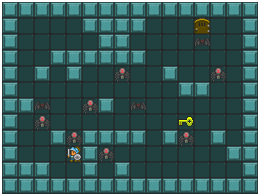

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=239207, Sun Oct 30 13:06:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.65e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.41e-01  4e-01  4e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.25e-01  4e-01  4e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.12e-01  4e-01  4e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 3.98e-01  4e-01  4e-01 0:00.4
    6     84 1.000000000000000e+02 1.1e+00 3.99e-01  4e-01  4e-01 0:00.5
    7     98 1.000000000000000e+02 1.1e+00 3.99e-01  4e-01  4e-01 0:00.5
    8    112 1.000000000000000e+02 1.1e+00 3.93e-01  4e-01  4e-01 0:00.6
    9    126 1.000000000000000e+02 1.2e+00 3.83e-01  4e-01  4e-01 0:00.7
   10    140 1.000000000000000e+02 1.2e+00 3.75e-01  4e-01  4e-01 0:00.8
   11    154 1.000000000000000e+02 1.2e+00 3.60e-01  4e-01  4e-01 0:00.8
   12    168 1.000000000000000e+0

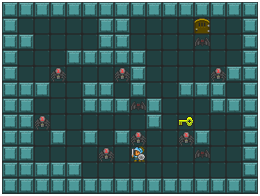

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=276033, Sun Oct 30 13:06:34 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.140000000000000e+02 1.0e+00 4.63e-01  5e-01  5e-01 0:00.1
    2     28 -1.160000000000000e+02 1.1e+00 4.40e-01  4e-01  4e-01 0:00.2
    3     42 -1.140000000000000e+02 1.1e+00 4.30e-01  4e-01  4e-01 0:00.3
   39    546 -1.360000000000000e+02 1.6e+00 3.54e-01  3e-01  4e-01 0:03.3
   87   1218 -1.440000000000000e+02 1.9e+00 1.87e-01  2e-01  2e-01 0:07.4
  100   1400 -1.440000000000000e+02 2.0e+00 1.55e-01  1e-01  2e-01 0:08.4
  113   1582 -1.440000000000000e+02 2.0e+00 1.28e-01  1e-01  1e-01 0:09.5
  116   1624 -1.440000000000000e+02 2.0e+00 1.17e-01  1e-01  1e-01 0:09.8
  117   1638 -1.440000000000000e+02 2.0e+00 1.15e-01  1e-01  1e-01 0:09.9
  118   1652 -1.440000000000000e+02 2.0e+00 1.15e-01  1e-01  1e-01 0:09.9
  138   1932 -1.450000000000000e+02 2.2e+00 9.91e-02  9e-02  1e-01 0:11.6
  139   1946 -1.450000

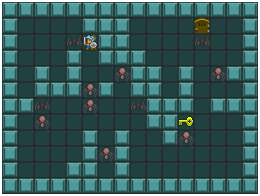

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=224219, Sun Oct 30 13:06:47 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.070000000000000e+02 1.0e+00 4.77e-01  5e-01  5e-01 0:00.1
    2     28 -1.100000000000000e+02 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 -1.060000000000000e+02 1.1e+00 4.44e-01  4e-01  4e-01 0:00.2
   42    588 -1.380000000000000e+02 1.7e+00 2.91e-01  3e-01  3e-01 0:03.3
   94   1316 -1.400000000000000e+02 2.1e+00 1.37e-01  1e-01  1e-01 0:07.3
   98   1372 -1.400000000000000e+02 2.2e+00 1.39e-01  1e-01  1e-01 0:07.7
  100   1400 -1.400000000000000e+02 2.2e+00 1.32e-01  1e-01  1e-01 0:07.8
  105   1470 -1.400000000000000e+02 2.2e+00 1.21e-01  1e-01  1e-01 0:08.2
  106   1484 -1.400000000000000e+02 2.3e+00 1.18e-01  1e-01  1e-01 0:08.3
  107   1498 -1.400000000000000e+02 2.3e+00 1.17e-01  1e-01  1e-01 0:08.4
  110   1540 -1.400000000000000e+02 2.3e+00 1.16e-01  1e-01  1e-01 0:08.6
  121   1694 -1.400000

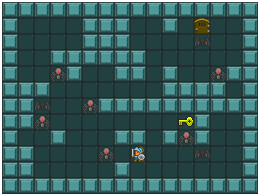

mean score:-144.18
mean counts:144.18
mean changes:50.42
mean playability:1.0
mean hamming dist:40.80816326530612


In [7]:
# ours2
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-714/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])

check(generator,fitnessf1)


(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=277784, Sun Oct 30 13:06:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.58e-01  5e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.48e-01  4e-01  5e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.39e-01  4e-01  4e-01 0:00.4
    6     84 1.000000000000000e+02 1.2e+00 4.33e-01  4e-01  4e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.28e-01  4e-01  4e-01 0:00.5
    8    112 1.000000000000000e+02 1.2e+00 4.26e-01  4e-01  4e-01 0:00.6
    9    126 1.000000000000000e+02 1.2e+00 4.29e-01  4e-01  4e-01 0:00.7
   10    140 1.000000000000000e+02 1.2e+00 4.28e-01  4e-01  4e-01 0:00.8
   11    154 1.000000000000000e+02 1.2e+00 4.21e-01  4e-01  4e-01 0:00.8
   12    168 1.000000000000000e+0

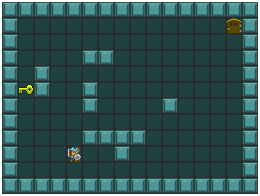

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=254418, Sun Oct 30 13:07:11 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.200000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 8.300000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 8.000000000000000e+01 1.1e+00 4.34e-01  4e-01  4e-01 0:00.3
   38    532 6.300000000000000e+01 1.8e+00 5.96e-01  6e-01  7e-01 0:03.3
   84   1176 5.800000000000000e+01 2.5e+00 7.80e-01  7e-01  9e-01 0:07.4
  100   1400 5.800000000000000e+01 2.8e+00 8.06e-01  7e-01  1e+00 0:08.8
  102   1428 5.800000000000000e+01 2.8e+00 8.02e-01  7e-01  1e+00 0:09.0
  106   1484 5.800000000000000e+01 2.9e+00 8.50e-01  8e-01  1e+00 0:09.3
  107   1498 5.800000000000000e+01 2.9e+00 8.49e-01  8e-01  1e+00 0:09.4
  122   1708 5.800000000000000e+01 3.1e+00 6.38e-01  6e-01  8e-01 0:10.7
  123   1722 5.800000000000000e+01 3.1e+00 6.28e-01  6e-01  8e-01 0:10.8
  124   1736 5.800000000000000e+0

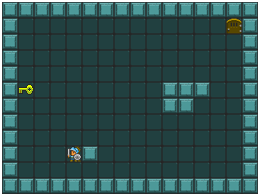

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=258145, Sun Oct 30 13:07:25 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.600000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 8.400000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.2
    3     42 8.800000000000000e+01 1.1e+00 4.27e-01  4e-01  4e-01 0:00.3
   38    532 6.900000000000000e+01 1.6e+00 3.73e-01  4e-01  4e-01 0:03.3
   86   1204 5.900000000000000e+01 2.0e+00 2.66e-01  2e-01  3e-01 0:07.4
  100   1400 5.900000000000000e+01 2.1e+00 2.41e-01  2e-01  3e-01 0:08.6
  128   1792 5.900000000000000e+01 2.3e+00 1.68e-01  1e-01  2e-01 0:11.0
  129   1806 5.900000000000000e+01 2.3e+00 1.69e-01  1e-01  2e-01 0:11.1
  145   2030 5.900000000000000e+01 2.4e+00 1.59e-01  1e-01  2e-01 0:12.5
  148   2072 5.900000000000000e+01 2.4e+00 1.49e-01  1e-01  2e-01 0:12.7
  149   2086 5.900000000000000e+01 2.4e+00 1.45e-01  1e-01  2e-01 0:12.8
  150   2100 5.900000000000000e+0

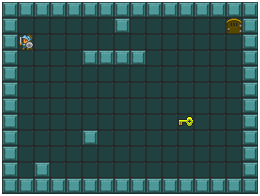

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=209595, Sun Oct 30 13:07:38 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.400000000000000e+01 1.0e+00 4.63e-01  5e-01  5e-01 0:00.1
    2     28 8.000000000000000e+01 1.1e+00 4.43e-01  4e-01  4e-01 0:00.2
    3     42 7.900000000000000e+01 1.1e+00 4.31e-01  4e-01  4e-01 0:00.3
   40    560 6.000000000000000e+01 2.0e+00 7.96e-01  8e-01  9e-01 0:03.3
   86   1204 5.600000000000000e+01 2.5e+00 6.23e-01  6e-01  8e-01 0:07.4
   89   1246 5.600000000000000e+01 2.5e+00 6.02e-01  6e-01  8e-01 0:07.7
   99   1386 5.600000000000000e+01 2.5e+00 5.30e-01  5e-01  7e-01 0:08.6
  100   1400 5.600000000000000e+01 2.5e+00 5.51e-01  5e-01  7e-01 0:08.7
  106   1484 5.600000000000000e+01 2.5e+00 5.99e-01  6e-01  8e-01 0:09.3
  107   1498 5.600000000000000e+01 2.6e+00 6.12e-01  6e-01  8e-01 0:09.4
  108   1512 5.600000000000000e+01 2.6e+00 6.22e-01  6e-01  8e-01 0:09.5
  109   1526 5.600000000000000e+0

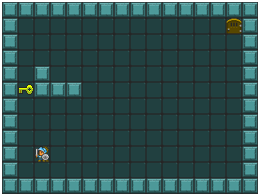

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=218139, Sun Oct 30 13:07:52 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 9.100000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.2
    3     42 9.800000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
   39    546 6.200000000000000e+01 1.9e+00 5.23e-01  5e-01  7e-01 0:03.3
   85   1190 6.100000000000000e+01 2.2e+00 3.24e-01  3e-01  4e-01 0:07.4
  100   1400 6.100000000000000e+01 2.5e+00 3.61e-01  3e-01  5e-01 0:08.8
  124   1736 6.100000000000000e+01 2.7e+00 2.74e-01  2e-01  4e-01 0:10.9
  125   1750 6.100000000000000e+01 2.7e+00 2.70e-01  2e-01  4e-01 0:11.0
  126   1764 6.100000000000000e+01 2.7e+00 2.69e-01  2e-01  4e-01 0:11.1
  135   1890 6.100000000000000e+01 2.8e+00 2.59e-01  2e-01  4e-01 0:11.9
  136   1904 6.100000000000000e+01 2.9e+00 2.56e-01  2e-01  4e-01 0:12.0
  137   1918 6.100000000000000e+0

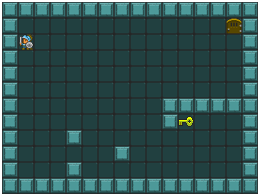

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=307492, Sun Oct 30 13:08:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.900000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 9.900000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.2
    3     42 9.800000000000000e+01 1.1e+00 4.44e-01  4e-01  4e-01 0:00.2
   40    560 7.800000000000000e+01 1.9e+00 8.84e-01  8e-01  1e+00 0:03.3
   89   1246 6.700000000000000e+01 2.3e+00 1.08e+00  1e+00  1e+00 0:07.3
  100   1400 6.600000000000000e+01 2.3e+00 1.03e+00  9e-01  1e+00 0:08.2
  132   1848 6.500000000000000e+01 2.7e+00 1.01e+00  9e-01  1e+00 0:10.9
  133   1862 6.500000000000000e+01 2.7e+00 1.01e+00  9e-01  1e+00 0:11.0
  134   1876 6.500000000000000e+01 2.7e+00 9.95e-01  9e-01  1e+00 0:11.0
  140   1960 6.500000000000000e+01 2.7e+00 8.80e-01  8e-01  1e+00 0:11.6
  141   1974 6.500000000000000e+01 2.7e+00 8.93e-01  8e-01  1e+00 0:11.6
  142   1988 6.500000000000000e+0

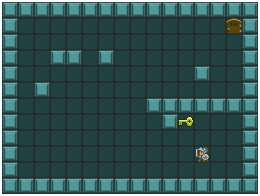

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=223520, Sun Oct 30 13:08:18 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 9.100000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.1
    3     42 8.400000000000000e+01 1.1e+00 4.41e-01  4e-01  4e-01 0:00.2
   41    574 6.600000000000000e+01 1.8e+00 6.33e-01  6e-01  7e-01 0:03.3
   88   1232 6.100000000000000e+01 2.2e+00 5.27e-01  5e-01  6e-01 0:07.3
  100   1400 6.000000000000000e+01 2.3e+00 4.37e-01  4e-01  5e-01 0:08.4
  128   1792 6.000000000000000e+01 2.4e+00 3.06e-01  3e-01  3e-01 0:10.8
  132   1848 6.000000000000000e+01 2.5e+00 3.22e-01  3e-01  4e-01 0:11.2
  133   1862 6.000000000000000e+01 2.5e+00 3.22e-01  3e-01  4e-01 0:11.3
  134   1876 6.000000000000000e+01 2.4e+00 3.23e-01  3e-01  4e-01 0:11.4
  135   1890 6.000000000000000e+01 2.4e+00 3.29e-01  3e-01  4e-01 0:11.5
  136   1904 6.000000000000000e+0

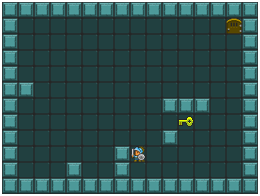

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=225195, Sun Oct 30 13:08:31 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.700000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 9.100000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.2
    3     42 9.100000000000000e+01 1.1e+00 4.31e-01  4e-01  4e-01 0:00.3
   39    546 7.100000000000000e+01 1.7e+00 7.04e-01  7e-01  8e-01 0:03.3
   88   1232 6.200000000000000e+01 2.2e+00 8.97e-01  8e-01  1e+00 0:07.4
  100   1400 5.800000000000000e+01 2.3e+00 9.23e-01  8e-01  1e+00 0:08.4
  132   1848 5.800000000000000e+01 2.7e+00 7.91e-01  7e-01  9e-01 0:11.1
  136   1904 5.800000000000000e+01 2.8e+00 7.00e-01  6e-01  8e-01 0:11.4
  137   1918 5.800000000000000e+01 2.8e+00 6.84e-01  6e-01  8e-01 0:11.5
  138   1932 5.800000000000000e+01 2.8e+00 6.69e-01  6e-01  8e-01 0:11.5
  139   1946 5.800000000000000e+01 2.8e+00 6.64e-01  6e-01  8e-01 0:11.6
  140   1960 5.800000000000000e+0

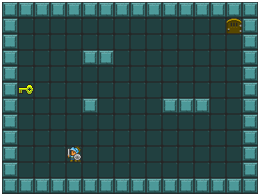

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=242108, Sun Oct 30 13:08:44 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.62e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.38e-01  4e-01  4e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.23e-01  4e-01  4e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.17e-01  4e-01  4e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.16e-01  4e-01  4e-01 0:00.4
    6     84 1.000000000000000e+02 1.1e+00 4.16e-01  4e-01  4e-01 0:00.4
    7     98 1.000000000000000e+02 1.2e+00 4.11e-01  4e-01  4e-01 0:00.5
    8    112 1.000000000000000e+02 1.2e+00 4.00e-01  4e-01  4e-01 0:00.6
    9    126 1.000000000000000e+02 1.2e+00 3.99e-01  4e-01  4e-01 0:00.6
   10    140 1.000000000000000e+02 1.2e+00 3.96e-01  4e-01  4e-01 0:00.7
   11    154 1.000000000000000e+02 1.2e+00 3.95e-01  4e-01  4e-01 0:00.8
   12    168 1.000000000000000e+0

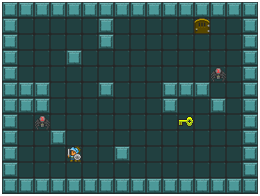

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=275119, Sun Oct 30 13:08:55 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.500000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 8.800000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 8.300000000000000e+01 1.1e+00 4.47e-01  4e-01  5e-01 0:00.3
   39    546 7.800000000000000e+01 1.6e+00 4.21e-01  4e-01  5e-01 0:03.3
   88   1232 7.300000000000000e+01 1.9e+00 2.67e-01  2e-01  3e-01 0:07.3
   97   1358 7.300000000000000e+01 2.0e+00 2.48e-01  2e-01  3e-01 0:08.1
  100   1400 7.300000000000000e+01 2.1e+00 2.47e-01  2e-01  3e-01 0:08.4
  104   1456 7.300000000000000e+01 2.1e+00 2.45e-01  2e-01  3e-01 0:08.7
  105   1470 7.300000000000000e+01 2.2e+00 2.43e-01  2e-01  3e-01 0:08.8
  106   1484 7.300000000000000e+01 2.2e+00 2.42e-01  2e-01  3e-01 0:08.9
  107   1498 7.300000000000000e+01 2.2e+00 2.38e-01  2e-01  2e-01 0:09.0
  116   1624 7.300000000000000e+0

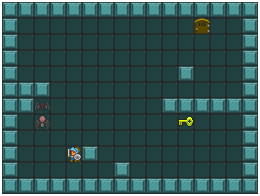

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=269778, Sun Oct 30 13:09:08 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.64e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.33e-01  4e-01  4e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.11e-01  4e-01  4e-01 0:00.2
   39    546 6.400000000000000e+01 1.8e+00 5.35e-01  5e-01  6e-01 0:03.3
   84   1176 5.900000000000000e+01 2.5e+00 5.73e-01  5e-01  6e-01 0:07.3
  100   1400 5.900000000000000e+01 2.6e+00 5.17e-01  5e-01  6e-01 0:08.7
  110   1540 5.900000000000000e+01 2.7e+00 4.79e-01  4e-01  5e-01 0:09.6
  111   1554 5.900000000000000e+01 2.7e+00 4.67e-01  4e-01  5e-01 0:09.7
  120   1680 5.900000000000000e+01 2.7e+00 4.25e-01  4e-01  5e-01 0:10.5
  123   1722 5.900000000000000e+01 2.8e+00 4.29e-01  4e-01  5e-01 0:10.7
  124   1736 5.900000000000000e+01 2.7e+00 4.27e-01  4e-01  5e-01 0:10.8
  125   1750 5.900000000000000e+0

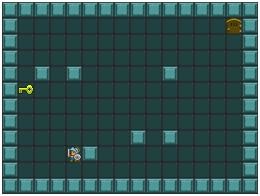

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=205222, Sun Oct 30 13:09:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.500000000000000e+01 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 8.600000000000000e+01 1.1e+00 4.40e-01  4e-01  4e-01 0:00.2
    3     42 8.300000000000000e+01 1.1e+00 4.29e-01  4e-01  4e-01 0:00.3
   39    546 6.200000000000000e+01 1.6e+00 3.06e-01  3e-01  3e-01 0:03.3
   85   1190 5.700000000000000e+01 1.9e+00 2.41e-01  2e-01  3e-01 0:07.3
  100   1400 5.700000000000000e+01 2.2e+00 3.00e-01  3e-01  3e-01 0:08.6


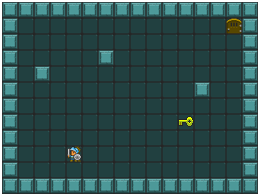

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=198108, Sun Oct 30 13:09:35 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.400000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 9.200000000000000e+01 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 8.800000000000000e+01 1.1e+00 4.30e-01  4e-01  4e-01 0:00.2
   41    574 7.000000000000000e+01 1.6e+00 3.69e-01  3e-01  4e-01 0:03.3
   88   1232 6.300000000000000e+01 1.9e+00 3.43e-01  3e-01  4e-01 0:07.3
  100   1400 6.200000000000000e+01 2.0e+00 2.95e-01  3e-01  3e-01 0:08.3
  133   1862 6.200000000000000e+01 2.2e+00 2.30e-01  2e-01  3e-01 0:11.2
  134   1876 6.200000000000000e+01 2.3e+00 2.25e-01  2e-01  3e-01 0:11.3
  135   1890 6.200000000000000e+01 2.3e+00 2.21e-01  2e-01  3e-01 0:11.4
  136   1904 6.200000000000000e+01 2.3e+00 2.24e-01  2e-01  3e-01 0:11.5
  137   1918 6.200000000000000e+01 2.3e+00 2.29e-01  2e-01  3e-01 0:11.6
  138   1932 6.200000000000000e+0

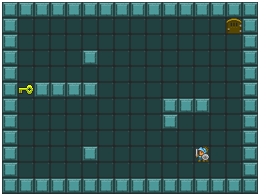

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=221017, Sun Oct 30 13:09:48 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.000000000000000e+01 1.0e+00 4.78e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.61e-01  5e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.55e-01  4e-01  5e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.61e-01  4e-01  5e-01 0:00.4
    6     84 1.000000000000000e+02 1.2e+00 4.78e-01  5e-01  5e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.91e-01  5e-01  5e-01 0:00.5
    8    112 1.000000000000000e+02 1.2e+00 4.96e-01  5e-01  5e-01 0:00.6
    9    126 1.000000000000000e+02 1.3e+00 5.02e-01  5e-01  5e-01 0:00.7
   10    140 1.000000000000000e+02 1.3e+00 5.08e-01  5e-01  5e-01 0:00.8
   13    182 1.000000000000000e+02 1.4e+00 5.01e-01  5e-01  5e-01 0:01.0
   14    196 1.000000000000000e+0

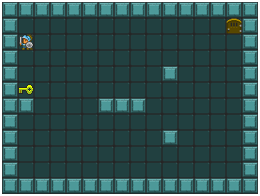

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=312886, Sun Oct 30 13:10:00 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.500000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 6.900000000000000e+01 1.1e+00 4.67e-01  5e-01  5e-01 0:00.2
    3     42 6.900000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.3
   38    532 5.600000000000000e+01 2.0e+00 5.74e-01  5e-01  6e-01 0:03.4
   83   1162 5.300000000000000e+01 2.3e+00 3.18e-01  3e-01  4e-01 0:07.3
   84   1176 5.300000000000000e+01 2.4e+00 3.10e-01  3e-01  4e-01 0:07.3
  100   1400 5.300000000000000e+01 2.4e+00 2.72e-01  2e-01  3e-01 0:08.8
  103   1442 5.300000000000000e+01 2.5e+00 2.79e-01  3e-01  3e-01 0:09.0
  108   1512 5.300000000000000e+01 2.5e+00 2.68e-01  2e-01  3e-01 0:09.5
  109   1526 5.300000000000000e+01 2.5e+00 2.62e-01  2e-01  3e-01 0:09.6
  110   1540 5.300000000000000e+01 2.5e+00 2.58e-01  2e-01  3e-01 0:09.7
  111   1554 5.300000000000000e+0

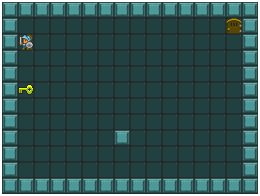

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=246158, Sun Oct 30 13:10:14 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.700000000000000e+01 1.0e+00 4.65e-01  5e-01  5e-01 0:00.1
    2     28 8.400000000000000e+01 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 8.300000000000000e+01 1.1e+00 4.37e-01  4e-01  4e-01 0:00.3
   40    560 7.000000000000000e+01 1.8e+00 5.50e-01  5e-01  6e-01 0:03.3
   87   1218 5.600000000000000e+01 2.6e+00 7.02e-01  6e-01  8e-01 0:07.4
  100   1400 5.500000000000000e+01 2.7e+00 6.56e-01  6e-01  8e-01 0:08.4
  113   1582 5.500000000000000e+01 2.8e+00 5.13e-01  5e-01  6e-01 0:09.6
  114   1596 5.500000000000000e+01 2.8e+00 5.09e-01  5e-01  6e-01 0:09.7
  115   1610 5.500000000000000e+01 2.8e+00 5.13e-01  5e-01  6e-01 0:09.8
  118   1652 5.500000000000000e+01 2.9e+00 5.21e-01  5e-01  6e-01 0:10.0
  119   1666 5.500000000000000e+01 2.9e+00 5.17e-01  5e-01  6e-01 0:10.1
  129   1806 5.500000000000000e+0

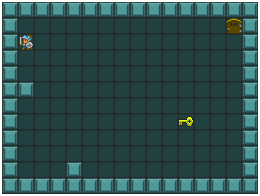

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=213008, Sun Oct 30 13:10:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.37e-01  4e-01  4e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.35e-01  4e-01  4e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.35e-01  4e-01  4e-01 0:00.4
    6     84 1.000000000000000e+02 1.1e+00 4.32e-01  4e-01  4e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.47e-01  4e-01  5e-01 0:00.6
    8    112 1.000000000000000e+02 1.2e+00 4.54e-01  4e-01  5e-01 0:00.6
   14    196 1.000000000000000e+02 1.3e+00 5.05e-01  5e-01  5e-01 0:01.1
   15    210 1.000000000000000e+02 1.4e+00 5.01e-01  5e-01  5e-01 0:01.2
   16    224 1.000000000000000e+02 1.4e+00 4.97e-01  5e-01  5e-01 0:01.3
   19    266 1.000000000000000e+0

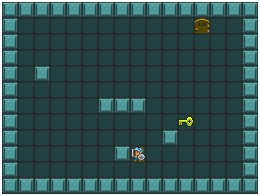

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=251377, Sun Oct 30 13:10:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
    4     56 1.000000000000000e+02 1.1e+00 4.46e-01  4e-01  5e-01 0:00.4
   55    770 5.900000000000000e+01 1.7e+00 5.31e-01  5e-01  6e-01 0:04.4
  100   1400 5.600000000000000e+01 2.2e+00 4.22e-01  4e-01  5e-01 0:08.3
  148   2072 5.600000000000000e+01 2.6e+00 3.25e-01  3e-01  4e-01 0:12.4
  149   2086 5.600000000000000e+01 2.6e+00 3.28e-01  3e-01  4e-01 0:12.5
  150   2100 5.600000000000000e+01 2.6e+00 3.32e-01  3e-01  4e-01 0:12.6


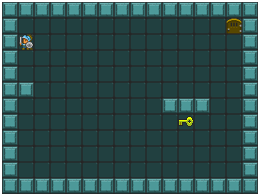

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=220953, Sun Oct 30 13:10:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.000000000000000e+01 1.0e+00 4.65e-01  5e-01  5e-01 0:00.1
    2     28 7.100000000000000e+01 1.1e+00 4.44e-01  4e-01  4e-01 0:00.2
    3     42 7.100000000000000e+01 1.1e+00 4.34e-01  4e-01  4e-01 0:00.3
   38    532 6.000000000000000e+01 1.7e+00 4.95e-01  5e-01  5e-01 0:03.3
   85   1190 5.600000000000000e+01 2.1e+00 4.40e-01  4e-01  5e-01 0:07.3
  100   1400 5.600000000000000e+01 2.1e+00 3.33e-01  3e-01  4e-01 0:08.7
  114   1596 5.600000000000000e+01 2.2e+00 3.19e-01  3e-01  4e-01 0:09.8
  115   1610 5.600000000000000e+01 2.2e+00 3.14e-01  3e-01  3e-01 0:09.9
  125   1750 5.600000000000000e+01 2.2e+00 2.92e-01  3e-01  3e-01 0:10.7
  130   1820 5.600000000000000e+01 2.2e+00 2.93e-01  3e-01  3e-01 0:11.2
  133   1862 5.600000000000000e+01 2.2e+00 2.98e-01  3e-01  3e-01 0:11.4
  140   1960 5.600000000000000e+0

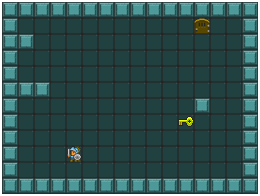

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=286700, Sun Oct 30 13:11:06 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.400000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 8.900000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.3
    3     42 9.100000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.5
   40    560 6.800000000000000e+01 1.8e+00 6.72e-01  6e-01  8e-01 0:03.5
   87   1218 6.300000000000000e+01 2.2e+00 7.18e-01  7e-01  8e-01 0:07.5
  100   1400 6.300000000000000e+01 2.2e+00 5.76e-01  5e-01  7e-01 0:08.7
  117   1638 6.300000000000000e+01 2.3e+00 5.16e-01  5e-01  6e-01 0:10.1
  118   1652 6.300000000000000e+01 2.3e+00 4.95e-01  4e-01  6e-01 0:10.2
  119   1666 6.300000000000000e+01 2.3e+00 4.86e-01  4e-01  6e-01 0:10.3
  120   1680 6.300000000000000e+01 2.3e+00 4.74e-01  4e-01  5e-01 0:10.3
  121   1694 6.300000000000000e+01 2.3e+00 4.68e-01  4e-01  5e-01 0:10.4
  124   1736 6.300000000000000e+0

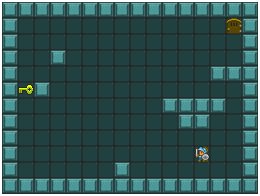

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=253157, Sun Oct 30 13:11:19 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.900000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 8.300000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 7.600000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.3
   37    518 6.700000000000000e+01 1.5e+00 3.56e-01  3e-01  4e-01 0:03.3
   84   1176 6.300000000000000e+01 1.7e+00 1.73e-01  2e-01  2e-01 0:07.3
   93   1302 6.300000000000000e+01 1.7e+00 1.36e-01  1e-01  1e-01 0:08.1
   94   1316 6.300000000000000e+01 1.7e+00 1.31e-01  1e-01  1e-01 0:08.2
   95   1330 6.300000000000000e+01 1.8e+00 1.28e-01  1e-01  1e-01 0:08.3
   98   1372 6.300000000000000e+01 1.7e+00 1.27e-01  1e-01  1e-01 0:08.7
   99   1386 6.300000000000000e+01 1.8e+00 1.30e-01  1e-01  1e-01 0:08.8
  100   1400 6.300000000000000e+01 1.8e+00 1.33e-01  1e-01  1e-01 0:08.8
  101   1414 6.300000000000000e+0

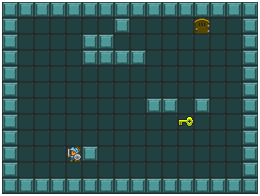

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=184246, Sun Oct 30 13:11:33 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.100000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 9.000000000000000e+01 1.1e+00 4.55e-01  4e-01  5e-01 0:00.3
    3     42 8.400000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.3
   38    532 6.500000000000000e+01 1.8e+00 6.10e-01  6e-01  7e-01 0:03.4
   80   1120 6.100000000000000e+01 2.2e+00 3.76e-01  3e-01  4e-01 0:07.1
   83   1162 6.100000000000000e+01 2.2e+00 3.70e-01  3e-01  4e-01 0:07.3
   87   1218 6.100000000000000e+01 2.2e+00 3.72e-01  3e-01  4e-01 0:07.7
   90   1260 6.100000000000000e+01 2.2e+00 3.60e-01  3e-01  4e-01 0:07.9
   94   1316 6.100000000000000e+01 2.2e+00 3.63e-01  3e-01  4e-01 0:08.2
  100   1400 6.100000000000000e+01 2.2e+00 3.81e-01  3e-01  4e-01 0:08.9
  110   1540 6.100000000000000e+01 2.2e+00 3.68e-01  3e-01  4e-01 0:09.7
  119   1666 6.100000000000000e+0

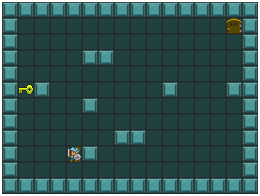

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=226170, Sun Oct 30 13:11:47 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.200000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 9.100000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
    3     42 8.900000000000000e+01 1.1e+00 4.41e-01  4e-01  4e-01 0:00.3
   39    546 7.100000000000000e+01 1.7e+00 3.36e-01  3e-01  4e-01 0:03.4
   80   1120 6.400000000000000e+01 1.9e+00 2.40e-01  2e-01  3e-01 0:06.8
  100   1400 6.100000000000000e+01 2.0e+00 2.76e-01  3e-01  3e-01 0:08.7
  149   2086 5.700000000000000e+01 2.3e+00 2.04e-01  2e-01  2e-01 0:12.8
  150   2100 5.700000000000000e+01 2.3e+00 2.02e-01  2e-01  2e-01 0:12.9


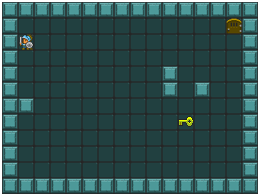

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=248632, Sun Oct 30 13:12:00 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.28e-01  4e-01  4e-01 0:00.3
   40    560 6.900000000000000e+01 1.7e+00 5.02e-01  5e-01  5e-01 0:03.3
   86   1204 6.500000000000000e+01 1.8e+00 3.04e-01  3e-01  3e-01 0:07.4
  100   1400 6.300000000000000e+01 1.9e+00 2.89e-01  3e-01  3e-01 0:08.7
  113   1582 6.300000000000000e+01 2.0e+00 2.58e-01  2e-01  3e-01 0:10.2
  138   1932 6.300000000000000e+01 2.2e+00 2.50e-01  2e-01  3e-01 0:12.5
  144   2016 6.300000000000000e+01 2.2e+00 2.16e-01  2e-01  2e-01 0:13.1
  150   2100 6.300000000000000e+01 2.2e+00 1.78e-01  2e-01  2e-01 0:13.6


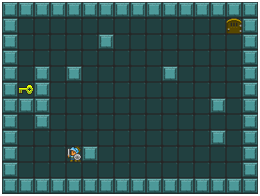

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=235020, Sun Oct 30 13:12:14 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.700000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 8.700000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.3
    3     42 9.400000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.4
   41    574 6.700000000000000e+01 1.7e+00 4.71e-01  4e-01  5e-01 0:03.5
   91   1274 5.600000000000000e+01 2.1e+00 4.72e-01  4e-01  5e-01 0:07.5
   97   1358 5.600000000000000e+01 2.1e+00 4.16e-01  4e-01  5e-01 0:08.0
   98   1372 5.600000000000000e+01 2.1e+00 4.13e-01  4e-01  5e-01 0:08.2
  100   1400 5.600000000000000e+01 2.1e+00 3.96e-01  4e-01  5e-01 0:08.4
  109   1526 5.600000000000000e+01 2.2e+00 3.56e-01  3e-01  4e-01 0:09.1
  110   1540 5.600000000000000e+01 2.2e+00 3.49e-01  3e-01  4e-01 0:09.2
  111   1554 5.600000000000000e+01 2.3e+00 3.42e-01  3e-01  4e-01 0:09.3
  119   1666 5.600000000000000e+0

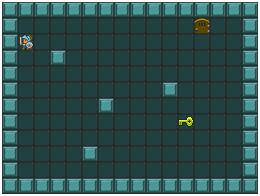

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=165036, Sun Oct 30 13:12:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.500000000000000e+01 1.0e+00 4.84e-01  5e-01  5e-01 0:00.1
    2     28 7.600000000000000e+01 1.1e+00 4.78e-01  5e-01  5e-01 0:00.2
    3     42 7.500000000000000e+01 1.1e+00 4.64e-01  5e-01  5e-01 0:00.3
   41    574 6.700000000000000e+01 1.7e+00 3.51e-01  3e-01  4e-01 0:03.3
   87   1218 6.100000000000000e+01 2.2e+00 3.92e-01  4e-01  5e-01 0:07.4
  100   1400 6.000000000000000e+01 2.3e+00 4.80e-01  4e-01  6e-01 0:08.6
  113   1582 6.000000000000000e+01 2.4e+00 3.57e-01  3e-01  4e-01 0:09.6
  116   1624 6.000000000000000e+01 2.4e+00 3.56e-01  3e-01  4e-01 0:09.8
  123   1722 6.000000000000000e+01 2.5e+00 3.24e-01  3e-01  4e-01 0:10.4
  124   1736 6.000000000000000e+01 2.5e+00 3.18e-01  3e-01  4e-01 0:10.5
  125   1750 6.000000000000000e+01 2.5e+00 3.12e-01  3e-01  4e-01 0:10.6
  126   1764 6.000000000000000e+0

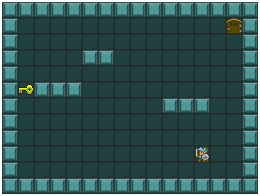

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=225611, Sun Oct 30 13:12:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.54e-01  5e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.47e-01  4e-01  4e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.46e-01  4e-01  4e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.48e-01  4e-01  5e-01 0:00.4
    6     84 1.000000000000000e+02 1.2e+00 4.47e-01  4e-01  5e-01 0:00.5
   12    168 1.000000000000000e+02 1.4e+00 5.19e-01  5e-01  5e-01 0:00.9
   15    210 1.000000000000000e+02 1.4e+00 5.14e-01  5e-01  5e-01 0:01.2
   16    224 1.000000000000000e+02 1.5e+00 5.11e-01  5e-01  5e-01 0:01.2
   17    238 1.000000000000000e+02 1.5e+00 4.91e-01  5e-01  5e-01 0:01.3
   18    252 1.000000000000000e+02 1.5e+00 4.83e-01  5e-01  5e-01 0:01.4
   19    266 1.000000000000000e+0

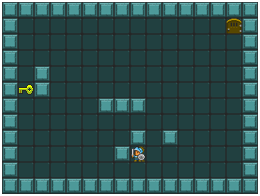

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=233547, Sun Oct 30 13:12:52 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.600000000000000e+01 1.0e+00 4.65e-01  5e-01  5e-01 0:00.1
    2     28 7.800000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.2
    3     42 7.600000000000000e+01 1.1e+00 4.39e-01  4e-01  4e-01 0:00.3
   37    518 6.000000000000000e+01 1.7e+00 4.11e-01  4e-01  4e-01 0:03.3
   72   1008 5.700000000000000e+01 1.8e+00 2.46e-01  2e-01  3e-01 0:06.3
   73   1022 5.700000000000000e+01 1.8e+00 2.40e-01  2e-01  3e-01 0:06.4
   77   1078 5.700000000000000e+01 1.8e+00 2.19e-01  2e-01  2e-01 0:06.7
   78   1092 5.700000000000000e+01 1.9e+00 2.16e-01  2e-01  2e-01 0:06.8
   79   1106 5.700000000000000e+01 1.9e+00 2.08e-01  2e-01  2e-01 0:06.9
   80   1120 5.700000000000000e+01 1.9e+00 2.01e-01  2e-01  2e-01 0:07.0
   81   1134 5.700000000000000e+01 1.9e+00 1.98e-01  2e-01  2e-01 0:07.1
   82   1148 5.700000000000000e+0

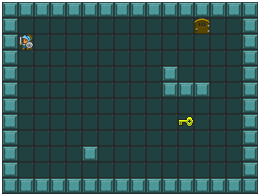

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=245451, Sun Oct 30 13:13:06 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.46e-01  4e-01  4e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.43e-01  4e-01  4e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.51e-01  4e-01  5e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.54e-01  4e-01  5e-01 0:00.4
    6     84 1.000000000000000e+02 1.2e+00 4.54e-01  4e-01  5e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.50e-01  4e-01  5e-01 0:00.5
    8    112 1.000000000000000e+02 1.2e+00 4.36e-01  4e-01  4e-01 0:00.6
    9    126 1.000000000000000e+02 1.2e+00 4.24e-01  4e-01  4e-01 0:00.7
   10    140 1.000000000000000e+02 1.2e+00 4.15e-01  4e-01  4e-01 0:00.7
   11    154 1.000000000000000e+02 1.2e+00 4.09e-01  4e-01  4e-01 0:00.8
   12    168 1.000000000000000e+0

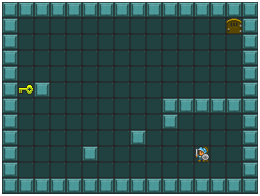

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=315774, Sun Oct 30 13:13:19 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.600000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 8.800000000000000e+01 1.1e+00 4.56e-01  5e-01  5e-01 0:00.2
    3     42 7.900000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
   39    546 6.100000000000000e+01 1.9e+00 6.43e-01  6e-01  8e-01 0:03.2
   89   1246 5.700000000000000e+01 2.4e+00 3.60e-01  3e-01  4e-01 0:07.3
   99   1386 5.700000000000000e+01 2.4e+00 2.92e-01  3e-01  3e-01 0:08.3
  100   1400 5.700000000000000e+01 2.4e+00 2.85e-01  3e-01  3e-01 0:08.4
  103   1442 5.700000000000000e+01 2.4e+00 2.51e-01  2e-01  3e-01 0:08.7
  107   1498 5.700000000000000e+01 2.5e+00 2.39e-01  2e-01  3e-01 0:09.0
  108   1512 5.700000000000000e+01 2.5e+00 2.42e-01  2e-01  3e-01 0:09.0
  109   1526 5.700000000000000e+01 2.5e+00 2.44e-01  2e-01  3e-01 0:09.1
  110   1540 5.700000000000000e+0

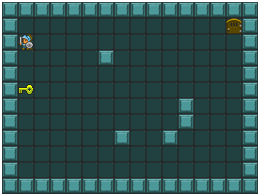

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=310325, Sun Oct 30 13:13:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.000000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 7.500000000000000e+01 1.1e+00 4.45e-01  4e-01  4e-01 0:00.3
    3     42 7.300000000000000e+01 1.1e+00 4.29e-01  4e-01  4e-01 0:00.4
   37    518 6.500000000000000e+01 1.8e+00 4.60e-01  4e-01  5e-01 0:03.4
   84   1176 6.200000000000000e+01 2.5e+00 4.18e-01  4e-01  5e-01 0:07.5
   95   1330 6.200000000000000e+01 2.5e+00 3.28e-01  3e-01  4e-01 0:08.4
   96   1344 6.200000000000000e+01 2.6e+00 3.25e-01  3e-01  4e-01 0:08.5
  100   1400 6.200000000000000e+01 2.6e+00 3.09e-01  3e-01  4e-01 0:08.9
  101   1414 6.200000000000000e+01 2.6e+00 3.22e-01  3e-01  4e-01 0:09.0
  102   1428 6.200000000000000e+01 2.6e+00 3.26e-01  3e-01  4e-01 0:09.0
  103   1442 6.200000000000000e+01 2.6e+00 3.29e-01  3e-01  4e-01 0:09.1
  104   1456 6.200000000000000e+0

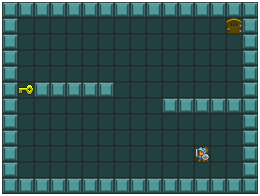

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=239312, Sun Oct 30 13:13:46 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.300000000000000e+01 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 8.300000000000000e+01 1.1e+00 4.51e-01  4e-01  5e-01 0:00.2
    3     42 7.100000000000000e+01 1.1e+00 4.47e-01  4e-01  5e-01 0:00.3
   39    546 6.500000000000000e+01 1.6e+00 4.39e-01  4e-01  5e-01 0:03.3
   86   1204 5.900000000000000e+01 2.4e+00 6.60e-01  6e-01  8e-01 0:07.4
  100   1400 5.800000000000000e+01 2.6e+00 6.16e-01  5e-01  7e-01 0:08.6


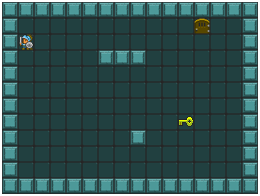

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=243302, Sun Oct 30 13:14:00 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.800000000000000e+01 1.0e+00 4.63e-01  5e-01  5e-01 0:00.1
    2     28 9.300000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.1
    3     42 8.500000000000000e+01 1.1e+00 4.35e-01  4e-01  4e-01 0:00.2
   41    574 6.400000000000000e+01 1.8e+00 4.78e-01  4e-01  5e-01 0:03.3
   89   1246 6.100000000000000e+01 1.9e+00 1.52e-01  1e-01  2e-01 0:07.4
   91   1274 6.100000000000000e+01 1.9e+00 1.55e-01  1e-01  2e-01 0:07.5
   92   1288 6.100000000000000e+01 1.9e+00 1.56e-01  1e-01  2e-01 0:07.6
   93   1302 6.100000000000000e+01 1.9e+00 1.55e-01  1e-01  2e-01 0:07.7
  100   1400 6.100000000000000e+01 2.0e+00 1.55e-01  1e-01  2e-01 0:08.3
  120   1680 6.100000000000000e+01 2.1e+00 1.68e-01  2e-01  2e-01 0:10.0
  130   1820 6.100000000000000e+01 2.2e+00 1.48e-01  1e-01  2e-01 0:10.9
  131   1834 6.100000000000000e+0

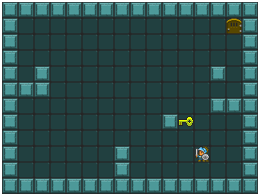

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=236639, Sun Oct 30 13:14:13 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.100000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 8.800000000000000e+01 1.1e+00 4.48e-01  4e-01  4e-01 0:00.2
    3     42 9.400000000000000e+01 1.1e+00 4.41e-01  4e-01  4e-01 0:00.3
   40    560 6.500000000000000e+01 1.7e+00 4.15e-01  4e-01  4e-01 0:03.3
   87   1218 6.300000000000000e+01 2.1e+00 2.26e-01  2e-01  2e-01 0:07.3
   94   1316 6.300000000000000e+01 2.1e+00 2.03e-01  2e-01  2e-01 0:07.9
   95   1330 6.300000000000000e+01 2.1e+00 2.01e-01  2e-01  2e-01 0:08.0
   96   1344 6.300000000000000e+01 2.1e+00 2.03e-01  2e-01  2e-01 0:08.1
   97   1358 6.300000000000000e+01 2.1e+00 2.05e-01  2e-01  2e-01 0:08.1
   98   1372 6.300000000000000e+01 2.1e+00 2.06e-01  2e-01  2e-01 0:08.2
   99   1386 6.300000000000000e+01 2.1e+00 2.07e-01  2e-01  2e-01 0:08.3
  100   1400 6.300000000000000e+0

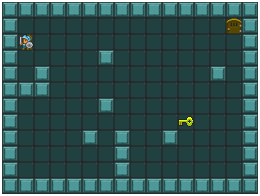

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=235689, Sun Oct 30 13:14:26 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.000000000000000e+01 1.0e+00 4.80e-01  5e-01  5e-01 0:00.1
    2     28 9.100000000000000e+01 1.1e+00 4.65e-01  5e-01  5e-01 0:00.2
    3     42 8.600000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.3
   38    532 7.100000000000000e+01 1.8e+00 4.84e-01  5e-01  6e-01 0:03.3
   87   1218 6.200000000000000e+01 2.3e+00 3.36e-01  3e-01  4e-01 0:07.3
  100   1400 6.000000000000000e+01 2.3e+00 4.07e-01  4e-01  5e-01 0:08.4


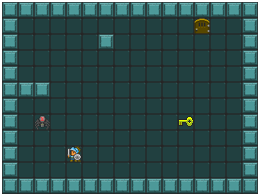

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=175663, Sun Oct 30 13:14:39 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.100000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 9.100000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 8.300000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.2
   39    546 6.000000000000000e+01 1.9e+00 6.99e-01  7e-01  8e-01 0:03.3
   73   1022 5.900000000000000e+01 2.2e+00 4.37e-01  4e-01  5e-01 0:06.1
  100   1400 5.800000000000000e+01 2.3e+00 4.49e-01  4e-01  5e-01 0:08.5
  133   1862 5.600000000000000e+01 2.4e+00 3.38e-01  3e-01  4e-01 0:11.2
  134   1876 5.600000000000000e+01 2.4e+00 3.42e-01  3e-01  4e-01 0:11.3


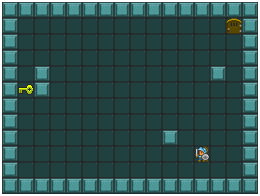

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=226833, Sun Oct 30 13:14:52 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.100000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 7.500000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 7.300000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.2
   40    560 6.200000000000000e+01 1.7e+00 4.66e-01  4e-01  5e-01 0:03.3
   87   1218 5.900000000000000e+01 2.0e+00 2.62e-01  2e-01  3e-01 0:07.3
   99   1386 5.900000000000000e+01 2.0e+00 2.11e-01  2e-01  2e-01 0:08.4
  100   1400 5.900000000000000e+01 2.0e+00 2.10e-01  2e-01  2e-01 0:08.5
  105   1470 5.900000000000000e+01 2.0e+00 2.11e-01  2e-01  2e-01 0:08.9
  108   1512 5.900000000000000e+01 2.0e+00 2.05e-01  2e-01  2e-01 0:09.2
  109   1526 5.900000000000000e+01 2.0e+00 2.00e-01  2e-01  2e-01 0:09.3
  110   1540 5.900000000000000e+01 2.0e+00 1.96e-01  2e-01  2e-01 0:09.4
  116   1624 5.900000000000000e+0

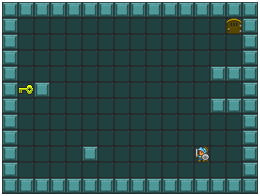

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=157797, Sun Oct 30 13:15:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 9.900000000000000e+01 1.1e+00 4.30e-01  4e-01  4e-01 0:00.2
   40    560 6.000000000000000e+01 1.7e+00 5.75e-01  6e-01  6e-01 0:03.3
   87   1218 5.400000000000000e+01 2.2e+00 4.04e-01  4e-01  5e-01 0:07.3
  100   1400 5.400000000000000e+01 2.3e+00 4.08e-01  4e-01  5e-01 0:08.5
  124   1736 5.400000000000000e+01 2.4e+00 3.48e-01  3e-01  4e-01 0:10.6
  127   1778 5.400000000000000e+01 2.4e+00 3.46e-01  3e-01  4e-01 0:10.9
  130   1820 5.400000000000000e+01 2.4e+00 3.31e-01  3e-01  4e-01 0:11.2
  131   1834 5.400000000000000e+01 2.4e+00 3.28e-01  3e-01  4e-01 0:11.3
  132   1848 5.400000000000000e+01 2.4e+00 3.17e-01  3e-01  4e-01 0:11.4
  133   1862 5.400000000000000e+0

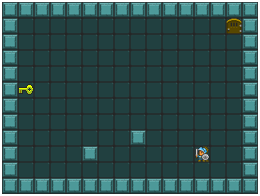

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=217860, Sun Oct 30 13:15:18 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.500000000000000e+01 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
    3     42 9.000000000000000e+01 1.1e+00 4.44e-01  4e-01  4e-01 0:00.2
   40    560 6.600000000000000e+01 1.7e+00 5.82e-01  6e-01  7e-01 0:03.3
   88   1232 6.300000000000000e+01 2.0e+00 3.67e-01  3e-01  4e-01 0:07.3
  100   1400 6.200000000000000e+01 2.1e+00 4.25e-01  4e-01  5e-01 0:08.3


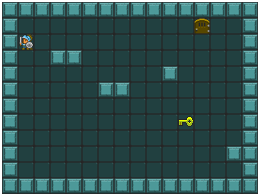

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=197975, Sun Oct 30 13:15:31 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.52e-01  4e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.35e-01  4e-01  4e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.23e-01  4e-01  4e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.15e-01  4e-01  4e-01 0:00.4
    6     84 1.000000000000000e+02 1.1e+00 4.14e-01  4e-01  4e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.13e-01  4e-01  4e-01 0:00.5
    8    112 1.000000000000000e+02 1.2e+00 4.08e-01  4e-01  4e-01 0:00.6
    9    126 1.000000000000000e+02 1.2e+00 4.01e-01  4e-01  4e-01 0:00.7
   10    140 1.000000000000000e+02 1.2e+00 4.03e-01  4e-01  4e-01 0:00.8
   11    154 1.000000000000000e+02 1.2e+00 4.05e-01  4e-01  4e-01 0:00.9
   12    168 1.000000000000000e+0

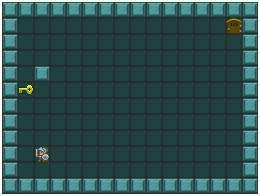

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=283452, Sun Oct 30 13:15:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.51e-01  4e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.37e-01  4e-01  4e-01 0:00.2
   38    532 6.800000000000000e+01 1.9e+00 8.48e-01  8e-01  9e-01 0:03.3
   86   1204 6.600000000000000e+01 2.5e+00 6.64e-01  6e-01  7e-01 0:07.3
  100   1400 6.600000000000000e+01 2.6e+00 5.57e-01  5e-01  6e-01 0:08.6
  101   1414 6.600000000000000e+01 2.6e+00 5.54e-01  5e-01  6e-01 0:08.7
  102   1428 6.600000000000000e+01 2.6e+00 5.62e-01  5e-01  6e-01 0:08.8
  109   1526 6.600000000000000e+01 2.6e+00 6.14e-01  5e-01  7e-01 0:09.4
  128   1792 6.500000000000000e+01 2.7e+00 5.97e-01  5e-01  7e-01 0:11.0
  129   1806 6.500000000000000e+01 2.7e+00 5.95e-01  5e-01  7e-01 0:11.1
  130   1820 6.500000000000000e+0

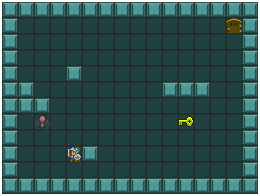

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=182985, Sun Oct 30 13:15:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 7.900000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 8.400000000000000e+01 1.1e+00 4.31e-01  4e-01  4e-01 0:00.2
   39    546 6.400000000000000e+01 1.6e+00 5.10e-01  5e-01  5e-01 0:03.3
   85   1190 6.100000000000000e+01 2.0e+00 3.13e-01  3e-01  3e-01 0:07.3
   87   1218 6.100000000000000e+01 2.0e+00 3.01e-01  3e-01  3e-01 0:07.5
   88   1232 6.100000000000000e+01 2.0e+00 2.98e-01  3e-01  3e-01 0:07.6
   89   1246 6.100000000000000e+01 2.0e+00 2.95e-01  3e-01  3e-01 0:07.7
   90   1260 6.100000000000000e+01 2.0e+00 2.91e-01  3e-01  3e-01 0:07.8
   91   1274 6.100000000000000e+01 2.0e+00 2.87e-01  3e-01  3e-01 0:07.8
   92   1288 6.100000000000000e+01 2.0e+00 2.84e-01  3e-01  3e-01 0:07.9
   95   1330 6.100000000000000e+0

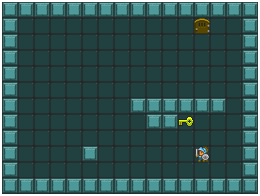

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=231293, Sun Oct 30 13:16:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.400000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 8.200000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.35e-01  4e-01  4e-01 0:00.3
   41    574 6.800000000000000e+01 1.6e+00 4.27e-01  4e-01  5e-01 0:03.3
   90   1260 6.300000000000000e+01 2.9e+00 9.39e-01  9e-01  1e+00 0:07.4
  100   1400 6.200000000000000e+01 3.1e+00 8.60e-01  8e-01  1e+00 0:08.2
  150   2100 6.000000000000000e+01 3.5e+00 7.14e-01  6e-01  9e-01 0:12.3


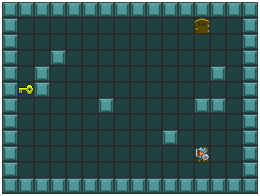

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=263701, Sun Oct 30 13:16:23 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.700000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 7.300000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.2
    3     42 7.900000000000000e+01 1.1e+00 4.35e-01  4e-01  4e-01 0:00.3
   40    560 6.900000000000000e+01 2.0e+00 9.15e-01  9e-01  1e+00 0:03.3
   88   1232 6.400000000000000e+01 2.7e+00 6.58e-01  6e-01  9e-01 0:07.3
  100   1400 6.400000000000000e+01 2.8e+00 6.15e-01  6e-01  8e-01 0:08.4
  103   1442 6.400000000000000e+01 2.8e+00 6.16e-01  6e-01  8e-01 0:08.7
  112   1568 6.400000000000000e+01 2.9e+00 5.17e-01  5e-01  7e-01 0:09.5
  113   1582 6.400000000000000e+01 2.9e+00 5.03e-01  4e-01  7e-01 0:09.6
  117   1638 6.400000000000000e+01 2.9e+00 5.01e-01  4e-01  7e-01 0:10.0
  118   1652 6.400000000000000e+01 2.9e+00 5.11e-01  5e-01  7e-01 0:10.1
  123   1722 6.400000000000000e+0

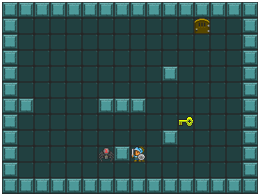

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=208085, Sun Oct 30 13:16:36 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.400000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 8.400000000000000e+01 1.1e+00 4.46e-01  4e-01  5e-01 0:00.2
    3     42 8.300000000000000e+01 1.1e+00 4.34e-01  4e-01  4e-01 0:00.2
   41    574 6.400000000000000e+01 2.0e+00 7.46e-01  7e-01  9e-01 0:03.3
   88   1232 5.400000000000000e+01 2.9e+00 8.28e-01  8e-01  1e+00 0:07.4
  100   1400 5.400000000000000e+01 2.9e+00 7.66e-01  7e-01  1e+00 0:08.4
  130   1820 5.400000000000000e+01 3.0e+00 5.10e-01  5e-01  7e-01 0:11.0
  133   1862 5.400000000000000e+01 3.1e+00 5.03e-01  4e-01  7e-01 0:11.3
  139   1946 5.400000000000000e+01 3.2e+00 4.99e-01  4e-01  7e-01 0:11.8
  140   1960 5.400000000000000e+01 3.2e+00 4.89e-01  4e-01  7e-01 0:11.9
  141   1974 5.400000000000000e+01 3.2e+00 4.79e-01  4e-01  7e-01 0:12.0
  142   1988 5.400000000000000e+0

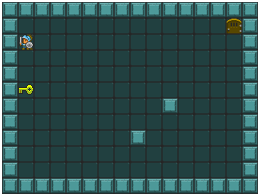

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=239285, Sun Oct 30 13:16:49 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.100000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 8.800000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.2
    3     42 8.800000000000000e+01 1.1e+00 4.44e-01  4e-01  4e-01 0:00.2
   41    574 6.600000000000000e+01 1.7e+00 5.72e-01  5e-01  6e-01 0:03.3
   86   1204 5.600000000000000e+01 2.6e+00 6.42e-01  6e-01  8e-01 0:07.3
  100   1400 5.600000000000000e+01 2.9e+00 5.50e-01  5e-01  7e-01 0:08.7
  129   1806 5.600000000000000e+01 3.1e+00 5.46e-01  5e-01  7e-01 0:11.3
  130   1820 5.600000000000000e+01 3.2e+00 5.28e-01  5e-01  7e-01 0:11.5


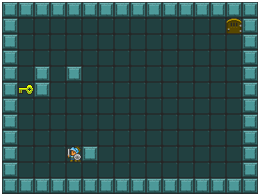

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=185633, Sun Oct 30 13:17:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 9.300000000000000e+01 1.1e+00 4.49e-01  4e-01  5e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.34e-01  4e-01  4e-01 0:00.3
   38    532 6.600000000000000e+01 1.8e+00 9.41e-01  9e-01  1e+00 0:03.4
   83   1162 6.000000000000000e+01 2.4e+00 1.49e+00  1e+00  2e+00 0:07.4
  100   1400 6.000000000000000e+01 2.5e+00 1.04e+00  9e-01  1e+00 0:08.9


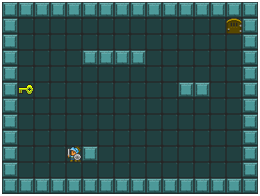

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=235238, Sun Oct 30 13:17:16 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 9.200000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.2
    3     42 9.600000000000000e+01 1.1e+00 4.41e-01  4e-01  4e-01 0:00.2
   41    574 6.600000000000000e+01 1.7e+00 6.94e-01  7e-01  8e-01 0:03.3
   90   1260 6.000000000000000e+01 2.0e+00 4.22e-01  4e-01  5e-01 0:07.4
  100   1400 6.000000000000000e+01 2.1e+00 3.25e-01  3e-01  4e-01 0:08.3
  101   1414 6.000000000000000e+01 2.1e+00 3.29e-01  3e-01  4e-01 0:08.3
  102   1428 6.000000000000000e+01 2.1e+00 3.32e-01  3e-01  4e-01 0:08.4
  103   1442 6.000000000000000e+01 2.1e+00 3.37e-01  3e-01  4e-01 0:08.5
  108   1512 6.000000000000000e+01 2.1e+00 3.37e-01  3e-01  4e-01 0:08.9
  109   1526 6.000000000000000e+01 2.1e+00 3.47e-01  3e-01  4e-01 0:09.0
  126   1764 6.000000000000000e+0

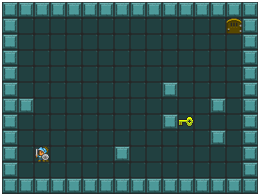

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=194197, Sun Oct 30 13:17:29 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.600000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 7.900000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 7.700000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
   40    560 6.100000000000000e+01 1.9e+00 4.62e-01  4e-01  5e-01 0:03.3
   88   1232 5.900000000000000e+01 2.2e+00 3.36e-01  3e-01  4e-01 0:07.4
  100   1400 5.800000000000000e+01 2.2e+00 3.44e-01  3e-01  4e-01 0:08.4
  143   2002 5.800000000000000e+01 2.4e+00 2.80e-01  2e-01  3e-01 0:12.1


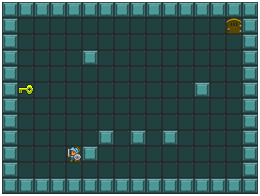

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=270158, Sun Oct 30 13:17:42 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 8.700000000000000e+01 1.1e+00 4.44e-01  4e-01  4e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.30e-01  4e-01  4e-01 0:00.2
    4     56 1.000000000000000e+02 1.1e+00 4.25e-01  4e-01  4e-01 0:00.3
    5     70 1.000000000000000e+02 1.1e+00 4.18e-01  4e-01  4e-01 0:00.4
    6     84 1.000000000000000e+02 1.1e+00 4.15e-01  4e-01  4e-01 0:00.5
    7     98 1.000000000000000e+02 1.2e+00 4.14e-01  4e-01  4e-01 0:00.5
    8    112 1.000000000000000e+02 1.2e+00 4.09e-01  4e-01  4e-01 0:00.6
    9    126 1.000000000000000e+02 1.2e+00 4.07e-01  4e-01  4e-01 0:00.7
   10    140 1.000000000000000e+02 1.2e+00 4.02e-01  4e-01  4e-01 0:00.8
   11    154 1.000000000000000e+02 1.2e+00 3.98e-01  4e-01  4e-01 0:00.8
   12    168 1.000000000000000e+0

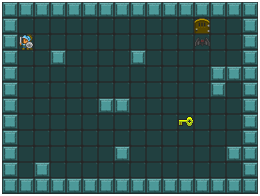

mean score:59.6
mean counts:59.6
mean changes:-33.7
mean playability:1.0
mean hamming dist:14.609795918367347


In [8]:
# ours2
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-714/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf2)
